## PROJECT SUMMARY:

Project is about finding similar friend clusters for peakup employees based on their break habbits. Data can be useful for HR Dept. Simiar friend groups may work together, or any project can be broken into pieces and split btw individuals according to their cluster.

**Some important point that has taken when filtering sql data:**

- 5995f7b9-cb5a-44a6-aabb-50e49e4cd331 for tenant_id
- 06a9e467-22c9-4688-9a9a-67930471edc5 for gate_id which is main entrance gate
- We should have 2 unique/distinct lock_id (one for enter and other one for exit)
- Readed_at column should be gmt +3 (timezone that turkey is in)
- Removed_at column should be null
- Is_Enabled column should be true

Most of the columns in unfiltered dataset/table is string that cant be used as categorical feature or even meaningful in a
Machine Learning sense. However I'll show them in df_raw format before filtering. I'll find some additional minor data analysis outputs along the way also. Last part will be about clustering

In [901]:
#Needed Libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ordered_set import OrderedSet
from collections import Counter,defaultdict
from scipy.stats import iqr
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler,normalize
from scipy.stats import boxcox
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from clusteval import clusteval
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.metrics import homogeneity_completeness_v_measure,homogeneity_score,make_scorer
from sklearn.preprocessing import LabelEncoder

In [699]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [700]:
cols=["Id","ReadedAt","Tenant_Id","CreatedAt","ChangedAt","IsEnabled","Card_Id","User_Id",
      "Lock_Id","Gate_Id","RemovedAt","Properties_Serialized"]

df_raw=pd.read_csv("dataset_for_test1.csv",header=None,names=cols)
print(df_raw.shape)

(382674, 12)


In [701]:
#only usable cols are ReadedAt and User_Id
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382674 entries, 0 to 382673
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Id                     382674 non-null  object 
 1   ReadedAt               382674 non-null  object 
 2   Tenant_Id              382674 non-null  object 
 3   CreatedAt              382674 non-null  object 
 4   ChangedAt              0 non-null       float64
 5   IsEnabled              382674 non-null  int64  
 6   Card_Id                381933 non-null  object 
 7   User_Id                372678 non-null  object 
 8   Lock_Id                382674 non-null  object 
 9   Gate_Id                382674 non-null  object 
 10  RemovedAt              0 non-null       float64
 11  Properties_Serialized  375406 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 35.0+ MB


In [702]:
df_raw.head()

Id                            ReadedAt  \
0  00000acc-8b87-44f5-8221-bce1efb4f58f  2020-01-17 21:21:48.0000000 +03:00   
1  00000c91-36cf-41ae-b8e9-0eefab874c7f  2020-04-14 23:59:29.0000000 +03:00   
2  000010BD-AC8A-4C3F-9C42-85C8642F4AA6  2018-12-20 14:27:36.0000000 +03:00   
3  000085da-3661-4105-a607-1f3c87544a48  2018-12-04 16:46:20.0000000 +03:00   
4  0000e2ee-c063-484d-8506-b6156cdb5b11  2018-01-26 14:02:55.0000000 +03:00   

                              Tenant_Id                           CreatedAt  \
0  5995f7b9-cb5a-44a6-aabb-50e49e4cd331  2020-01-21 08:30:42.9388414 +00:00   
1  5995f7b9-cb5a-44a6-aabb-50e49e4cd331  2020-05-21 08:22:19.5061551 +00:00   
2  5995f7b9-cb5a-44a6-aabb-50e49e4cd331  2018-12-25 13:34:17.6633333 +00:00   
3  5995f7b9-cb5a-44a6-aabb-50e49e4cd331  2018-12-04 13:48:09.4146892 +00:00   
4  5995f7b9-cb5a-44a6-aabb-50e49e4cd331  2018-01-26 11:02:56.3899299 +00:00   

   ChangedAt  IsEnabled                               Card_Id  \
0        NaN          1  4c1f79cc-d5c0-46aa-a83e-b2b83df56e7c   
1        NaN          1  a716afe4-2347-4741-ad00-ccb4dbb11906   
2        NaN          1  735B57F5-BDC7-4138-9458-46C23BDD984C   
3        NaN          1  551CD1D8-0D09-48B8-B9DD-2A9ED6D1CE06   
4        NaN          1  5A0C8899-24EF-4C9F-8EAF-3F356693C2E1   

                                User_Id                               Lock_Id  \
0  F2928023-0755-4401-AA18-CEFDD663A784  5380dc9a-6148-4362-8d25-e8be6d31b67a   
1  209B2018-577C-454A-B904-0B104CBCB1AC  5380dc9a-6148-4362-8d25-e8be6d31b67a   
2  D797847F-B9C6-4723-883F-C34D22F90C6A  5380dc9a-6148-4362-8d25-e8be6d31b67a   
3  6c564474-bc21-4b15-ad4f-5cb5c16e1c33  5380dc9a-6148-4362-8d25-e8be6d31b67a   
4  4EF9609D-DEBE-45CE-88CE-DA12F14092A2  c2323a12-a0b0-4fbb-82a7-92f531a86c7f   

                                Gate_Id  RemovedAt Properties_Serialized  
0  06a9e467-22c9-4688-9a9a-67930471edc5        NaN                    {}  
1  06a9e467-22c9-4688-9a9a-67930471edc5        NaN                    {}  
2  06a9e467-22c9-4688-9a9a-67930471edc5        NaN      {manuelLog:true}  
3  06a9e467-22c9-4688-9a9a-67930471edc5        NaN                    {}  
4  06a9e467-22c9-4688-9a9a-67930471edc5        NaN                    {}

In [703]:
df_raw.sort_values(by="ReadedAt",ascending=True).head(3)
#the furthest observation is in December 3, 2017.

Id  \
293429  c44cd15f-436a-4aef-9925-d6bb15b68e19   
352889  ec28d6d3-6915-40a8-a02a-f95a2363c87d   
363923  f38a1e08-da5d-48b9-b521-c1af665f1365   

                                  ReadedAt  \
293429  2017-12-03 13:50:19.8820000 +03:00   
352889  2017-12-03 13:50:19.8820000 +03:00   
363923  2017-12-03 13:50:19.8820000 +03:00   

                                   Tenant_Id  \
293429  5995f7b9-cb5a-44a6-aabb-50e49e4cd331   
352889  5995f7b9-cb5a-44a6-aabb-50e49e4cd331   
363923  5995f7b9-cb5a-44a6-aabb-50e49e4cd331   

                                 CreatedAt  ChangedAt  IsEnabled  \
293429  2020-01-29 08:56:52.3214680 +00:00        NaN          1   
352889  2019-05-06 07:42:03.1238269 +00:00        NaN          1   
363923  2019-05-09 10:25:21.9580442 +00:00        NaN          1   

                                     Card_Id  \
293429  492982D4-9C19-476E-A04A-AF44E9412226   
352889  32d56252-f60d-48cf-813d-0ab01e4b43d3   
363923  32d56252-f60d-48cf-813d-0ab01e4b43d3   

                                     User_Id  \
293429                                   NaN   
352889  0943084D-CBF5-4E82-B1B4-1D0235D177C4   
363923  0943084D-CBF5-4E82-B1B4-1D0235D177C4   

                                     Lock_Id  \
293429  c2323a12-a0b0-4fbb-82a7-92f531a86c7f   
352889  5380dc9a-6148-4362-8d25-e8be6d31b67a   
363923  5380dc9a-6148-4362-8d25-e8be6d31b67a   

                                     Gate_Id  RemovedAt Properties_Serialized  
293429  06a9e467-22c9-4688-9a9a-67930471edc5        NaN                    {}  
352889  06a9e467-22c9-4688-9a9a-67930471edc5        NaN                    {}  
363923  06a9e467-22c9-4688-9a9a-67930471edc5        NaN                    {}

In [704]:
df=df_raw.copy()
df=df.iloc[:,[1,7]]
df.head()
#let's test that our sql if it does its job and takes only gmt +03:00 as a timezone

ReadedAt                               User_Id
0  2020-01-17 21:21:48.0000000 +03:00  F2928023-0755-4401-AA18-CEFDD663A784
1  2020-04-14 23:59:29.0000000 +03:00  209B2018-577C-454A-B904-0B104CBCB1AC
2  2018-12-20 14:27:36.0000000 +03:00  D797847F-B9C6-4723-883F-C34D22F90C6A
3  2018-12-04 16:46:20.0000000 +03:00  6c564474-bc21-4b15-ad4f-5cb5c16e1c33
4  2018-01-26 14:02:55.0000000 +03:00  4EF9609D-DEBE-45CE-88CE-DA12F14092A2

In [705]:
df["ReadedAt"].str.split("+").str.get(1).value_counts()
#all the gmt values are +03:00, we re ok to move on. We could remove the gmt parts as well.

03:00    382674
Name: ReadedAt, dtype: int64

In [706]:
df["ReadedAt"]=pd.to_datetime(df["ReadedAt"].str.split("+").str.get(0),infer_datetime_format=True)
df.head()

ReadedAt                               User_Id
0 2020-01-17 21:21:48  F2928023-0755-4401-AA18-CEFDD663A784
1 2020-04-14 23:59:29  209B2018-577C-454A-B904-0B104CBCB1AC
2 2018-12-20 14:27:36  D797847F-B9C6-4723-883F-C34D22F90C6A
3 2018-12-04 16:46:20  6c564474-bc21-4b15-ad4f-5cb5c16e1c33
4 2018-01-26 14:02:55  4EF9609D-DEBE-45CE-88CE-DA12F14092A2

In [707]:
#lets check null/nan values, ml models cant work with user_id so we have to either impute it or drop it. we cant impute
#str data so we have to drop it if there is any
print(df.isnull().sum())
df["User_Id"].isnull().value_counts(dropna=False,normalize=True)
#its around %97 non nan data. We will drop them

ReadedAt       0
User_Id     9996
dtype: int64


False    0.973879
True     0.026121
Name: User_Id, dtype: float64

In [708]:
df.dropna(axis=0,how="any",inplace=True)

In [709]:
df["User_Id"].nunique()
#124 different entries.

124

In [710]:
df.sort_values(by="ReadedAt",ascending=True)
#there are many ReadedAt vals that has same millisecond(10^-3 sec), this is sth anormal. it could be good idea that we only
#take distinct logs that has dif second. lets try it.

ReadedAt                               User_Id
128575 2017-12-03 13:50:19.882  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
363923 2017-12-03 13:50:19.882  0943084D-CBF5-4E82-B1B4-1D0235D177C4
109954 2017-12-03 13:50:19.882  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
8638   2017-12-03 13:50:19.882  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
352889 2017-12-03 13:50:19.882  0943084D-CBF5-4E82-B1B4-1D0235D177C4
...                        ...                                   ...
168699 2020-06-15 16:32:44.000  15597C07-6169-4BBB-BC57-BCE6DD837C1C
109048 2020-06-15 16:33:40.000  D476FBE9-8901-4C11-9584-D8829A479ED7
45250  2020-06-15 17:00:52.000  15597C07-6169-4BBB-BC57-BCE6DD837C1C
308366 2020-06-15 17:01:59.000  6FFA7DFE-47B3-42FC-905B-44854F037F10
251429 2020-06-15 17:10:50.000  a9fbbb7d-b8e3-46e3-9ebf-c1036456e5f8

[372678 rows x 2 columns]

In [711]:
df[df.duplicated(subset="ReadedAt", keep='first')]
#we can drop the repeated cols but first lets see it in a df format
#we cant be sure without some domain knowledge however system reads some entries more than once. keep=first shows duplicated
#values after first one. Nonetheless we can get rid of this rows its just a system malfunction it seems.

ReadedAt                               User_Id
32     2020-04-14 23:59:29  209B2018-577C-454A-B904-0B104CBCB1AC
51     2020-04-14 23:59:29  209B2018-577C-454A-B904-0B104CBCB1AC
63     2020-04-14 23:59:29  209B2018-577C-454A-B904-0B104CBCB1AC
75     2020-04-14 23:59:29  209B2018-577C-454A-B904-0B104CBCB1AC
76     2020-04-14 23:59:29  209B2018-577C-454A-B904-0B104CBCB1AC
...                    ...                                   ...
382653 2018-05-18 10:57:43  3C2CC3D4-36AD-493C-AEC2-1034CED6517C
382664 2020-04-14 23:59:29  209B2018-577C-454A-B904-0B104CBCB1AC
382670 2020-04-14 23:59:29  209B2018-577C-454A-B904-0B104CBCB1AC
382671 2020-04-14 23:59:29  209B2018-577C-454A-B904-0B104CBCB1AC
382672 2018-05-25 15:32:19  82905E4B-F017-49BD-AE6B-ADC75CCD3797

[94721 rows x 2 columns]

In [712]:
df=df[~df.duplicated(subset="ReadedAt", keep='first')].sort_values(by="ReadedAt",ascending=True)
df.head()
#its a good idea to get rid of this milliseconds so...

ReadedAt                               User_Id
8638   2017-12-03 13:50:19.882  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
81177  2017-12-03 17:49:34.000  F2928023-0755-4401-AA18-CEFDD663A784
127351 2017-12-03 17:49:38.000  F2928023-0755-4401-AA18-CEFDD663A784
301234 2017-12-03 18:09:31.000  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
116790 2017-12-03 18:09:36.000  6c564474-bc21-4b15-ad4f-5cb5c16e1c33

In [713]:
df["ReadedAt"]=df['ReadedAt'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))\
                .apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
df=df.sort_values(by="ReadedAt",ascending=True)
df.head()

ReadedAt                               User_Id
8638   2017-12-03 13:50:19  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
81177  2017-12-03 17:49:34  F2928023-0755-4401-AA18-CEFDD663A784
127351 2017-12-03 17:49:38  F2928023-0755-4401-AA18-CEFDD663A784
301234 2017-12-03 18:09:31  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
116790 2017-12-03 18:09:36  6c564474-bc21-4b15-ad4f-5cb5c16e1c33

In [714]:
#we have both entering/and exiting times on same column, it could be good idea create 2 columns. we just copied our df first
dft=df.copy()
dft.head()

ReadedAt                               User_Id
8638   2017-12-03 13:50:19  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
81177  2017-12-03 17:49:34  F2928023-0755-4401-AA18-CEFDD663A784
127351 2017-12-03 17:49:38  F2928023-0755-4401-AA18-CEFDD663A784
301234 2017-12-03 18:09:31  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
116790 2017-12-03 18:09:36  6c564474-bc21-4b15-ad4f-5cb5c16e1c33

***We will get insights about 5 additional topic before clustering part***

### Q1: Month with Most Breaks (Dec 2017 to June 2020)

In [715]:
dft=df.copy()

In [716]:
dft.set_index(keys=["ReadedAt"],inplace=True)
dft.head()
#i think rather than timestamp format we need to add date as a column as well.

User_Id
ReadedAt                                                 
2017-12-03 13:50:19  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
2017-12-03 17:49:34  F2928023-0755-4401-AA18-CEFDD663A784
2017-12-03 17:49:38  F2928023-0755-4401-AA18-CEFDD663A784
2017-12-03 18:09:31  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
2017-12-03 18:09:36  6c564474-bc21-4b15-ad4f-5cb5c16e1c33

In [717]:
dft["Date"]=dft.index.date
dft=dft[["Date","User_Id"]]
dft["User_Id"]=pd.Categorical(dft["User_Id"],ordered=False)
dft

Date                               User_Id
ReadedAt                                                             
2017-12-03 13:50:19  2017-12-03  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
2017-12-03 17:49:34  2017-12-03  F2928023-0755-4401-AA18-CEFDD663A784
2017-12-03 17:49:38  2017-12-03  F2928023-0755-4401-AA18-CEFDD663A784
2017-12-03 18:09:31  2017-12-03  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
2017-12-03 18:09:36  2017-12-03  6c564474-bc21-4b15-ad4f-5cb5c16e1c33
...                         ...                                   ...
2020-06-15 16:32:44  2020-06-15  15597C07-6169-4BBB-BC57-BCE6DD837C1C
2020-06-15 16:33:40  2020-06-15  D476FBE9-8901-4C11-9584-D8829A479ED7
2020-06-15 17:00:52  2020-06-15  15597C07-6169-4BBB-BC57-BCE6DD837C1C
2020-06-15 17:01:59  2020-06-15  6FFA7DFE-47B3-42FC-905B-44854F037F10
2020-06-15 17:10:50  2020-06-15  a9fbbb7d-b8e3-46e3-9ebf-c1036456e5f8

[277957 rows x 2 columns]

In [21]:
# %matplotlib inline
# sns.set_style("darkgrid")
# plt.figure(figsize=(10,6))
# ax.set_xticks(np.arange(len(dft.resample('M').count()["User_Id"])))
# plt.bar(x=dft.resample('M').count()["User_Id"].index,height=dft.resample('M').count()["User_Id"],width=20)
# plt.xticks(rotation=90)
# plt.axhline(dft.resample('M').count()["User_Id"].mean(),c="r")
# dft.resample('M').count()["User_Id"].plot.bar()

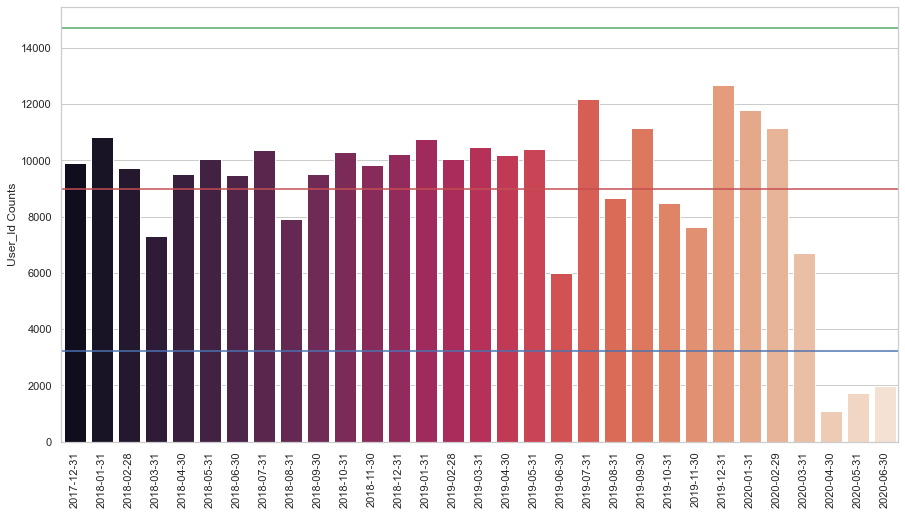

In [718]:
sns.set(style="whitegrid")
sns.set_palette("Set1", 8, .75)
plt.figure(figsize=(15,8))
sns.barplot(x=dft.resample('M').count()["User_Id"].index.date, y=dft.resample('M').count()["User_Id"],palette="rocket")
plt.ylabel("User_Id Counts")
plt.axhline(dft.resample('M').count()["User_Id"].mean(),c="r")
plt.axhline(dft.resample('M').count()["User_Id"].mean()+2*dft.resample('M').count()["User_Id"].std(),c="g")
plt.axhline(dft.resample('M').count()["User_Id"].mean()-2*dft.resample('M').count()["User_Id"].std(),c="b")
plt.xticks(rotation=90)
plt.show()
#ofc this dist isnt normal distribution so we can use median+-1.5IQR if u prefer it makes much sense however visually we can
#see that there is no outliers other than april-june 2020 due to covid-19 break.

***There is no excessive breaks, nothing statistically significant monthwise***

### Q2: BusinessHours That Have Most Breaks (Dec 2017 to June 2020)

In [719]:
dft=df.copy()
dft.set_index(keys=["ReadedAt"],inplace=True)
dft["Date"]=dft.index.date
dft=dft[["Date","User_Id"]]
dft["User_Id"]=pd.Categorical(dft["User_Id"],ordered=False)
dft=dft[(dft.index.year==2019)].resample("H").count()[["User_Id"]]
dft

User_Id
ReadedAt                    
2019-01-01 17:00:00        2
2019-01-01 18:00:00        0
2019-01-01 19:00:00        0
2019-01-01 20:00:00        0
2019-01-01 21:00:00        0
...                      ...
2019-12-31 16:00:00       38
2019-12-31 17:00:00       50
2019-12-31 18:00:00       10
2019-12-31 19:00:00       15
2019-12-31 20:00:00        2

[8740 rows x 1 columns]

In [26]:
#uid_by_hr = Counter()
# dict_test=defaultdict(int)
# for idx,row in dft.iterrows():
#     dict_test[idx.hour]+=row["User_Id"]
#     #uid_by_hr=Counter((idx.hour,row["User_Id"]))
#     #print(idx.hour,row["User_Id"])
# dict_test

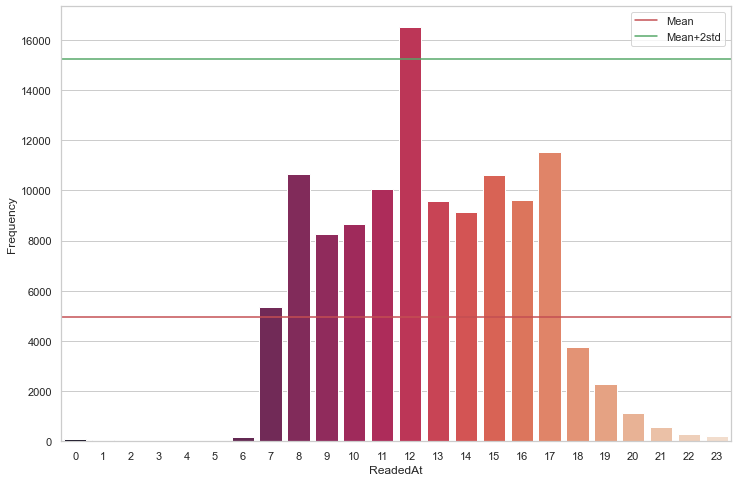

In [720]:
dft_hr_sum=dft.set_index([dft.index.hour]).groupby("ReadedAt").sum()
%matplotlib inline
sns.set(style="whitegrid")
sns.set_palette("Set1", 8, .75)
plt.figure(figsize=(12,8))

sns.barplot(x=dft_hr_sum.index,
            y=dft_hr_sum.values.flatten(),palette="rocket")
plt.axhline(dft_hr_sum.mean().values,c="r",label="Mean")
plt.axhline(dft_hr_sum.mean().values+2*dft_hr_sum.std().values,c="g",label="Mean+2std")
plt.legend()
plt.ylabel("Frequency")
plt.show()


we can see that outside of the lunch break, ***individuals mostly take a break btw 15-15:59 (compared to other time ranges)***

### Q3: Users By Their Break Amount

In [721]:
dft=df.copy()
dft.set_index(keys=["ReadedAt"],inplace=True)
dft["Date"]=dft.index.date
dft=dft[["Date","User_Id"]]

In [722]:
dft["User_Id"].value_counts().nlargest(10)
#12k data recorded for 3 years is sth far from normal, thats being said its good idea to do some outlier removal..

6FFA7DFE-47B3-42FC-905B-44854F037F10    12180
D797847F-B9C6-4723-883F-C34D22F90C6A    11597
3D25B51C-DB5E-40F1-99CD-D7899B85FA75    11486
15597C07-6169-4BBB-BC57-BCE6DD837C1C     9839
E5708F27-7AA7-43E7-92E4-AC7AD8660616     9474
D476FBE9-8901-4C11-9584-D8829A479ED7     9234
6c564474-bc21-4b15-ad4f-5cb5c16e1c33     9125
CDD35C57-F849-47B3-8B63-E52BCAC406BF     8606
6E748509-98D8-4457-B7DA-092612601352     7703
1746596B-884C-4CFD-BBE4-9CA7959567F9     6851
Name: User_Id, dtype: int64

In [723]:
dft["User_Id"].value_counts().nsmallest(20)
#also ~100 data recorded for 2.5-3 year data is very few and will skew our data and damage our findings.

D06F84F3-3DB1-443F-89FE-780D85475329      1
2ababa41-ae16-4587-9761-fff8ba2a99e1      1
14ac8b0a-bbe1-4ad1-8506-3fea49fa8445      3
B0F865D7-DCCD-42BA-9DA7-15B0B66B9B3F      5
42DE9467-FC1E-4279-814A-2F3DAF2CEF53      6
2A745459-E3C9-4920-85CA-24B6446D8AC1     10
3F131DD5-6EE9-4C87-B252-C945B008CDE3     28
7c8074bb-47f0-421f-9d02-951bf84e9d75     31
302FCFE5-F28E-4B20-A327-5401D45823A7     37
28C4B758-2C90-4B9C-A27C-0E62C97C45E0     39
58FF185D-FF93-401C-A5D7-7B8DADEAA74E     44
53D66313-30D0-4953-A67F-86233E4B40C1     46
152A42EF-A534-43AE-B45B-CEFEEF9C9956     46
061817A6-6D99-424D-809E-2C00AF175AB8     52
6682B7E3-4704-4C99-AFB2-7965390336D5     54
F59A27A8-3825-4F53-BE25-E587C848776C     62
5235F400-C91A-4CED-9D8F-41BE1D2F5B43     68
7F5CD07F-4081-43AB-8150-58E1B269F0FF     91
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5    106
3BA01AB7-D623-4EF1-B994-0580DFA6B965    117
Name: User_Id, dtype: int64

In [724]:
print(len(dft["Date"].resample("B"))) #662 Business Day if you work 5 days (this is according to american calendar )
print(len(dft["Date"].resample("D"))) #926 Business Day if you work 7 days 
print(int((len(dft["Date"].resample("B"))+len(dft["Date"].resample("D")))/2)) # around 800 days if you work 6 days for 2.5yrs

662
926
794


***662 business days which means at least 1300 in-out data has recorded for each individual adding lunch breaks etc individual
should have at least 1500 or more recorded case. Also anything more than 8000 in-out is abnormal bcs its 12-14 in-out per day***

***So i select [1500,8000] as upper and lower boundaries,*** of course without knowing company's working conditions this is somewhat
vague approximation. I dont add/subtract annual leave because 40-45 days (30-35 business days) doesnt affect the result if
you work 6 days at least once in a week in every 1 month.

In [725]:
dft_uid_vc=dft["User_Id"].value_counts()[dft["User_Id"].value_counts().between(1500,8000,inclusive=True)]
dft_uid_vc
#df['two'].between(-0.5, 0.5, inclusive=False)

6E748509-98D8-4457-B7DA-092612601352    7703
1746596B-884C-4CFD-BBE4-9CA7959567F9    6851
FF571F23-A909-40AA-ADD3-704585B150D6    6498
CE86C4D5-11F6-4126-8BA2-D12F6A60C5A2    6471
AF110C73-5378-4EC3-AB27-AECC36A74ADA    6443
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665    6164
F2928023-0755-4401-AA18-CEFDD663A784    5995
209B2018-577C-454A-B904-0B104CBCB1AC    5941
21B66374-DCE1-47F0-B37A-4C718D42AA37    5795
712044DF-CC59-4BBB-9D9B-7C889582EF58    5552
70017663-AEB6-45BF-9079-FFCFD89951D4    5265
4EF9609D-DEBE-45CE-88CE-DA12F14092A2    5228
5EC1864B-1E20-4A11-B927-CA523DB100C9    4913
0A597706-B8DA-4994-B4F5-C76146454951    4908
9E52DA09-CF46-4888-A348-C9A9C3487B5C    4897
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0    4807
2A1A028F-ACA1-403E-A6B9-F17C9EA01721    4721
19A57063-45EC-4EE2-A097-6CEFE624879E    4380
26C11AB0-1D82-4FB6-B65E-8D5431BE0456    4068
56EC977C-786D-42CB-A371-41F2841FEE13    3734
8E113ECD-EFA0-448F-A9FB-6634AE9032C5    3344
f445fc9b-98e3-4026-b00e-a98c541f81df    3324
1A158EA8-2

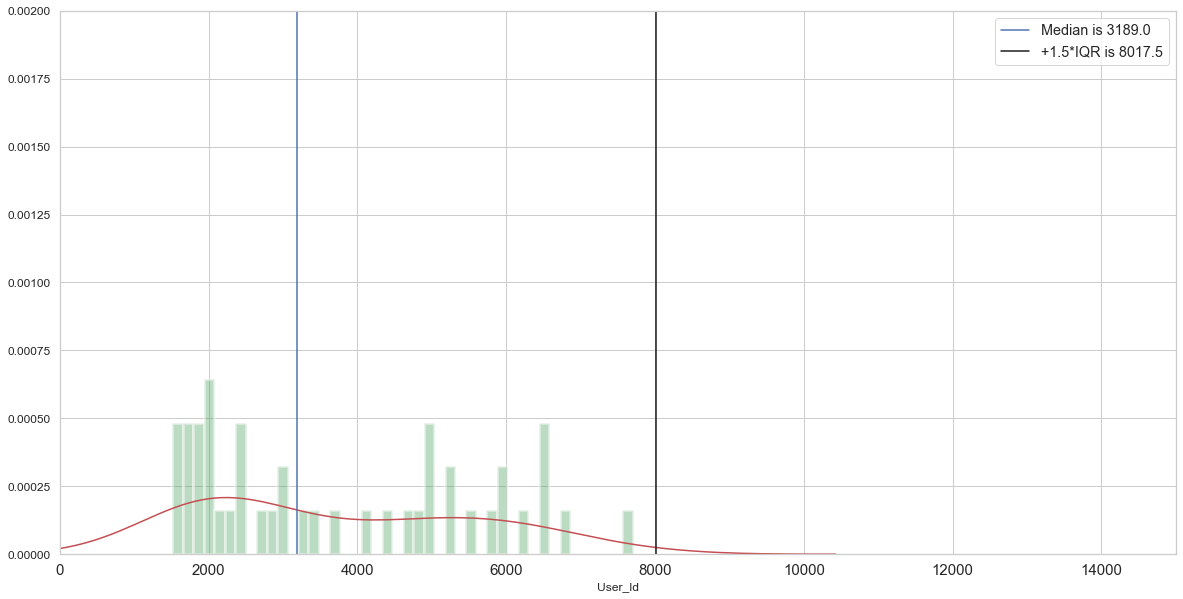

In [726]:
plt.figure(figsize=(20,10))
sns.distplot(dft_uid_vc,bins=len(dft_uid_vc),norm_hist=False,
            kde_kws={"color":"r"},
            hist_kws={"linewidth":3,"color": "g"})
plt.axvline(np.median(dft_uid_vc),c="b",label=f"Median is {np.median(dft_uid_vc)}")
plt.axvline(np.median(dft_uid_vc)+1.5*iqr(dft_uid_vc),c="k",label=f"+1.5*IQR is {np.median(dft_uid_vc)+1.5*iqr(dft_uid_vc)}")
#plt.axvline(np.median(dft_uid_vc)-1.5*iqr(dft_uid_vc),c="y",label="1.5*IQR")
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(loc="best",fontsize="large")
plt.ylim(0, 0.002)
plt.xlim(0, 15000)
plt.show()

***Because data is bimodal and right skewed i use median rather than mean and we can see that any user that has more than 8k data record could be an outlier***

In [727]:
dft["User_Id"].value_counts().nlargest(8)

6FFA7DFE-47B3-42FC-905B-44854F037F10    12180
D797847F-B9C6-4723-883F-C34D22F90C6A    11597
3D25B51C-DB5E-40F1-99CD-D7899B85FA75    11486
15597C07-6169-4BBB-BC57-BCE6DD837C1C     9839
E5708F27-7AA7-43E7-92E4-AC7AD8660616     9474
D476FBE9-8901-4C11-9584-D8829A479ED7     9234
6c564474-bc21-4b15-ad4f-5cb5c16e1c33     9125
CDD35C57-F849-47B3-8B63-E52BCAC406BF     8606
Name: User_Id, dtype: int64

### Q4: Users Average Break Time

***For this question i will calculate average break time for [1500,8000] range***

In [728]:
dft=df.copy()
#dft.set_index(keys=["ReadedAt"],inplace=True)
#dft["Date"]=dft.index.date
#dft=dft[["Date","User_Id"]]
dft.reset_index(drop=True,inplace=True)
dft

ReadedAt                               User_Id
0      2017-12-03 13:50:19  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
1      2017-12-03 17:49:34  F2928023-0755-4401-AA18-CEFDD663A784
2      2017-12-03 17:49:38  F2928023-0755-4401-AA18-CEFDD663A784
3      2017-12-03 18:09:31  dc376e2d-cb81-4b56-bc44-b3a59ae34e8d
4      2017-12-03 18:09:36  6c564474-bc21-4b15-ad4f-5cb5c16e1c33
...                    ...                                   ...
277952 2020-06-15 16:32:44  15597C07-6169-4BBB-BC57-BCE6DD837C1C
277953 2020-06-15 16:33:40  D476FBE9-8901-4C11-9584-D8829A479ED7
277954 2020-06-15 17:00:52  15597C07-6169-4BBB-BC57-BCE6DD837C1C
277955 2020-06-15 17:01:59  6FFA7DFE-47B3-42FC-905B-44854F037F10
277956 2020-06-15 17:10:50  a9fbbb7d-b8e3-46e3-9ebf-c1036456e5f8

[277957 rows x 2 columns]

In [729]:
dft_sv=dft.sort_values(by=["User_Id","ReadedAt"])
dft_sv

ReadedAt                               User_Id
51105  2018-05-14 15:55:57  05056DA7-9D4E-4ED7-8C04-A5B1C6559493
51112  2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493
51164  2018-05-14 17:23:54  05056DA7-9D4E-4ED7-8C04-A5B1C6559493
51182  2018-05-15 07:49:42  05056DA7-9D4E-4ED7-8C04-A5B1C6559493
51279  2018-05-15 10:59:15  05056DA7-9D4E-4ED7-8C04-A5B1C6559493
...                    ...                                   ...
276998 2020-06-04 15:27:27  f8463a83-c38a-4494-a841-d0e033291ddf
277039 2020-06-04 17:28:41  f8463a83-c38a-4494-a841-d0e033291ddf
277056 2020-06-04 19:41:19  f8463a83-c38a-4494-a841-d0e033291ddf
277057 2020-06-04 19:44:36  f8463a83-c38a-4494-a841-d0e033291ddf
277058 2020-06-04 19:48:46  f8463a83-c38a-4494-a841-d0e033291ddf

[277957 rows x 2 columns]

In [730]:
dft_sv["Time_Dif"]=dft_sv.set_index("User_Id").diff()["ReadedAt"].values
dft_sv["Time_Dif"]=dft_sv["Time_Dif"]-pd.to_timedelta(dft_sv["Time_Dif"].dt.days,unit="d")
dft_sv.fillna(pd.Timedelta(0),inplace=True)
dft_sv.reset_index(drop=True,inplace=True)
dft_sv

#we get timedelta format issues on future .groupby steps so in order to get rid of that problem, we ll create "Difs" 

ReadedAt                               User_Id Time_Dif
0      2018-05-14 15:55:57  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:00:00
1      2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:11
2      2018-05-14 17:23:54  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 01:19:46
3      2018-05-15 07:49:42  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 14:25:48
4      2018-05-15 10:59:15  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 03:09:33
...                    ...                                   ...      ...
277952 2020-06-04 15:27:27  f8463a83-c38a-4494-a841-d0e033291ddf 00:01:09
277953 2020-06-04 17:28:41  f8463a83-c38a-4494-a841-d0e033291ddf 02:01:14
277954 2020-06-04 19:41:19  f8463a83-c38a-4494-a841-d0e033291ddf 02:12:38
277955 2020-06-04 19:44:36  f8463a83-c38a-4494-a841-d0e033291ddf 00:03:17
277956 2020-06-04 19:48:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:10

[277957 rows x 3 columns]

In [731]:
dft_sv["Time_Dif_Hr"]=dft_sv["Time_Dif"].astype(dtype=str).str[-18:-16]
dft_sv

ReadedAt                               User_Id Time_Dif  \
0      2018-05-14 15:55:57  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:00:00   
1      2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:11   
2      2018-05-14 17:23:54  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 01:19:46   
3      2018-05-15 07:49:42  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 14:25:48   
4      2018-05-15 10:59:15  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 03:09:33   
...                    ...                                   ...      ...   
277952 2020-06-04 15:27:27  f8463a83-c38a-4494-a841-d0e033291ddf 00:01:09   
277953 2020-06-04 17:28:41  f8463a83-c38a-4494-a841-d0e033291ddf 02:01:14   
277954 2020-06-04 19:41:19  f8463a83-c38a-4494-a841-d0e033291ddf 02:12:38   
277955 2020-06-04 19:44:36  f8463a83-c38a-4494-a841-d0e033291ddf 00:03:17   
277956 2020-06-04 19:48:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:10   

       Time_Dif_Hr  
0               00  
1               00  
2               01  
3               14  
4               03  
...            ...  
277952          00  
277953          02  
277954          02  
277955          00  
277956          00  

[277957 rows x 4 columns]

In [732]:
dft_sv.Time_Dif_Hr.value_counts(ascending=False,normalize=True)
#we can see from here that most of the breaks is either 0-1 hr (%70) or 1-2 hr (%15), its most probably early lunch break
#with the supervision of a senior etc. Other ranges arent significant.

00    0.689887
01    0.148390
02    0.049547
14    0.031901
03    0.022216
04    0.010980
15    0.010099
13    0.009109
12    0.004569
16    0.004288
05    0.002428
17    0.002349
11    0.002198
18    0.001867
19    0.001623
10    0.001421
06    0.001126
20    0.001097
22    0.000989
23    0.000925
09    0.000845
21    0.000756
08    0.000694
07    0.000694
Name: Time_Dif_Hr, dtype: float64

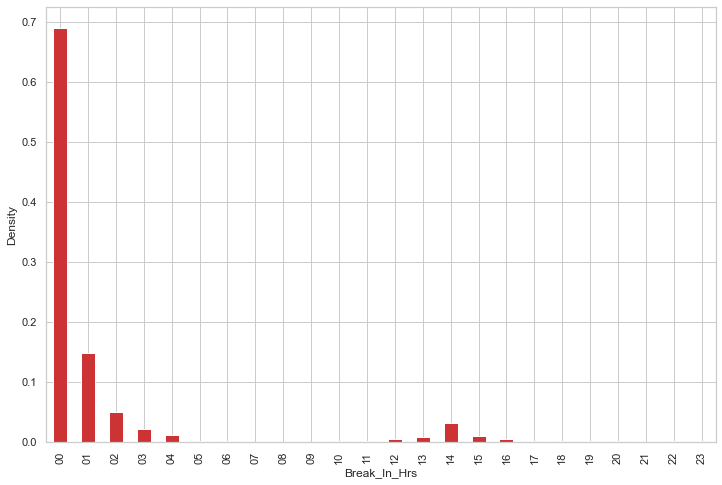

In [733]:
#plt.figure(12,8)
dft_sv.Time_Dif_Hr.value_counts(ascending=False,normalize=True).sort_index().plot(kind="bar",figsize=(12,8))
plt.xlabel("Break_In_Hrs")
plt.ylabel("Density")
plt.show()

***Due to high percentage of less than 1 hr breaks (0 hr) we will only include readings that have less than 1 hr in difference***

In [734]:
dft_sv=dft_sv[dft_sv.Time_Dif_Hr=="00"]
dft_sv.reset_index(drop=True,inplace=True)
dft_sv

ReadedAt                               User_Id Time_Dif  \
0      2018-05-14 15:55:57  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:00:00   
1      2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:11   
2      2018-05-15 11:05:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:02   
3      2018-05-15 14:35:25  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:36   
4      2018-05-16 09:51:53  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:07   
...                    ...                                   ...      ...   
191754 2020-06-04 15:23:41  f8463a83-c38a-4494-a841-d0e033291ddf 00:37:49   
191755 2020-06-04 15:26:18  f8463a83-c38a-4494-a841-d0e033291ddf 00:02:37   
191756 2020-06-04 15:27:27  f8463a83-c38a-4494-a841-d0e033291ddf 00:01:09   
191757 2020-06-04 19:44:36  f8463a83-c38a-4494-a841-d0e033291ddf 00:03:17   
191758 2020-06-04 19:48:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:10   

       Time_Dif_Hr  
0               00  
1               00  
2               00  
3               00  
4               00  
...            ...  
191754          00  
191755          00  
191756          00  
191757          00  
191758          00  

[191759 rows x 4 columns]

In [735]:
dft_sv=dft_sv[(dft_sv["Time_Dif"]>="00:02:00")&(dft_sv["Time_Dif"]<="00:15:00")]
dft_sv

#breaks should be somewhere btw 2 to 15 mins. Assumption

ReadedAt                               User_Id Time_Dif  \
1      2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:11   
2      2018-05-15 11:05:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:02   
3      2018-05-15 14:35:25  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:36   
4      2018-05-16 09:51:53  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:07   
5      2018-05-16 12:56:34  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:05:32   
...                    ...                                   ...      ...   
191749 2020-03-23 18:31:06  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:40   
191750 2020-04-06 15:20:30  f8463a83-c38a-4494-a841-d0e033291ddf 00:10:17   
191755 2020-06-04 15:26:18  f8463a83-c38a-4494-a841-d0e033291ddf 00:02:37   
191757 2020-06-04 19:44:36  f8463a83-c38a-4494-a841-d0e033291ddf 00:03:17   
191758 2020-06-04 19:48:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:10   

       Time_Dif_Hr  
1               00  
2               00  
3               00  
4               00  
5               00  
...            ...  
191749          00  
191750          00  
191755          00  
191757          00  
191758          00  

[93123 rows x 4 columns]

In [736]:
dft_tr1=dft_sv.copy()#.reset_index(drop=True)
dft_tr1

ReadedAt                               User_Id Time_Dif  \
1      2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:11   
2      2018-05-15 11:05:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:02   
3      2018-05-15 14:35:25  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:36   
4      2018-05-16 09:51:53  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:07   
5      2018-05-16 12:56:34  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:05:32   
...                    ...                                   ...      ...   
191749 2020-03-23 18:31:06  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:40   
191750 2020-04-06 15:20:30  f8463a83-c38a-4494-a841-d0e033291ddf 00:10:17   
191755 2020-06-04 15:26:18  f8463a83-c38a-4494-a841-d0e033291ddf 00:02:37   
191757 2020-06-04 19:44:36  f8463a83-c38a-4494-a841-d0e033291ddf 00:03:17   
191758 2020-06-04 19:48:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:10   

       Time_Dif_Hr  
1               00  
2               00  
3               00  
4               00  
5               00  
...            ...  
191749          00  
191750          00  
191755          00  
191757          00  
191758          00  

[93123 rows x 4 columns]

In [737]:
dft_tr2=dft_tr1["Time_Dif"].astype(str).str[-15:-10]
dft_tr2

1         08:11
2         06:02
3         03:36
4         06:07
5         05:32
          ...  
191749    04:40
191750    10:17
191755    02:37
191757    03:17
191758    04:10
Name: Time_Dif, Length: 93123, dtype: object

In [738]:
dft_tr3=dft_tr2.map(lambda x: float(x[0:2])+float(x[3:5])/60)
dft_tr3

1          8.183333
2          6.033333
3          3.600000
4          6.116667
5          5.533333
            ...    
191749     4.666667
191750    10.283333
191755     2.616667
191757     3.283333
191758     4.166667
Name: Time_Dif, Length: 93123, dtype: float64

In [739]:
dft_sv["Time_Dif_Float"]=dft_tr3
dft_sv.head()

C:\Users\berka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


ReadedAt                               User_Id Time_Dif  \
1 2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:11   
2 2018-05-15 11:05:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:02   
3 2018-05-15 14:35:25  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:36   
4 2018-05-16 09:51:53  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:07   
5 2018-05-16 12:56:34  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:05:32   

  Time_Dif_Hr  Time_Dif_Float  
1          00        8.183333  
2          00        6.033333  
3          00        3.600000  
4          00        6.116667  
5          00        5.533333

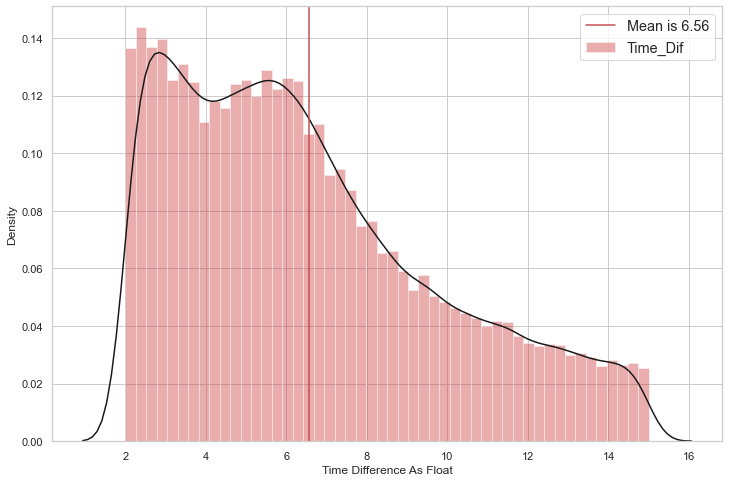

In [741]:
#sns.palplot(sns.color_palette("Paired"))
sns.set(style="whitegrid")
sns.set_palette("Set1", 8, .75)
plt.figure(figsize=(12,8))
sns.distplot(dft_sv[["Time_Dif_Float"]].values.flatten(),label="Time_Dif",
            kde_kws={"color":"k"})
plt.axvline(dft_sv["Time_Dif_Float"].mean(),label=f"Mean is {np.round(dft_sv['Time_Dif_Float'].mean(),2)}",c="r")
plt.ylabel("Density")
plt.xlabel("Time Difference As Float")
plt.legend(fontsize="large")

#when we were working with timedelta there was a format issue. our xticks have visualization problem so rather than using 
#them, i changed any timedelta to a float and then plot the values.

***we want to understand dist of our previous distplot (above) thus creating ecdf is a good way to understand what is yr dist looks like***

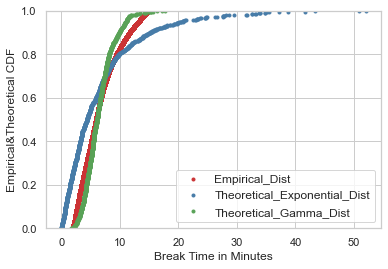

In [743]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

#gives u empirical cumulative dist.
%matplotlib inline
#plt.figure(figsize=(12,8))
# Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(dft_tr3.values)
x_theor, y_theor = ecdf(np.random.exponential(dft_tr3.values.mean(), size=1000))
x_theor2, y_theor2=ecdf(np.random.gamma(dft_tr3.values.mean(), size=1000))
# Generate plot
plt.plot(x_vers,y_vers,marker=".",linestyle="none",label="Empirical_Dist")
plt.plot(x_theor,y_theor,marker=".",linestyle="none",label="Theoretical_Exponential_Dist")
plt.plot(x_theor2,y_theor2,marker=".",linestyle="none",label="Theoretical_Gamma_Dist")        
# Label the axes
plt.xlabel("Break Time in Minutes")
plt.ylabel("Empirical&Theoretical CDF")
plt.ylim([0,1])

#legend up
plt.legend(fontsize="large",loc=4)
# Display the plot
plt.show()

#our ecdf looks quite like gamma dist. now we can check outlier detection techniques /formulas for gamma dist.

***Better Approach :*** Our Data looks very identical to Gamma Dist so here's what can we do, dont add upper boundary as 15 mins. plot whole hour from 2 min to 60 min and apply "gamma dist outlier removal" procedures from the web and then calculate mean and median.

***2nd Approach :*** Apply Log transformation to dataset and then make it look like a gaussian dist rather then this skewed format after that you can apply median+-1.5iqr as outlier and check mean/median

***Thats being said, my outlier removal approach is just an logical assumption, it doesnt have any math background and i found that its ~6:40 mins on avg***

### Q5: Users That Make Most Break (Cumulative Sum)

In [49]:
#pd.set_option("display.float_format","{:.2f}".format)

In [742]:
dft=df.copy()
dft.reset_index(drop=True,inplace=True)

dft_sv=dft.sort_values(by=["User_Id","ReadedAt"])

dft_sv["Time_Dif"]=dft_sv.set_index("User_Id").diff()["ReadedAt"].values
dft_sv["Time_Dif"]=dft_sv["Time_Dif"]-pd.to_timedelta(dft_sv["Time_Dif"].dt.days,unit="d")
dft_sv.fillna(pd.Timedelta(0),inplace=True)
dft_sv.reset_index(drop=True,inplace=True)

dft_sv["Time_Dif_Hr"]=dft_sv["Time_Dif"].astype(dtype=str).str[-18:-16]
dft_sv

#dft_sv[(dft_sv["Time_Dif"]>="00:02:00")&(dft_sv["Time_Dif"]<="00:15:00")]
#dft_tr1["Time_Dif"].astype(str).str[-15:-10]
#dft_tr2.map(lambda x: float(x[0:2])+float(x[3:5])/60)

ReadedAt                               User_Id Time_Dif  \
0      2018-05-14 15:55:57  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:00:00   
1      2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:11   
2      2018-05-14 17:23:54  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 01:19:46   
3      2018-05-15 07:49:42  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 14:25:48   
4      2018-05-15 10:59:15  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 03:09:33   
...                    ...                                   ...      ...   
277952 2020-06-04 15:27:27  f8463a83-c38a-4494-a841-d0e033291ddf 00:01:09   
277953 2020-06-04 17:28:41  f8463a83-c38a-4494-a841-d0e033291ddf 02:01:14   
277954 2020-06-04 19:41:19  f8463a83-c38a-4494-a841-d0e033291ddf 02:12:38   
277955 2020-06-04 19:44:36  f8463a83-c38a-4494-a841-d0e033291ddf 00:03:17   
277956 2020-06-04 19:48:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:10   

       Time_Dif_Hr  
0               00  
1               00  
2               01  
3               14  
4               03  
...            ...  
277952          00  
277953          02  
277954          02  
277955          00  
277956          00  

[277957 rows x 4 columns]

In [744]:
dft_sv_csum1=dft_sv[(dft_sv["Time_Dif"]>="00:02:00")&(dft_sv["Time_Dif"]<"02:00:00")]
dft_sv_csum1

ReadedAt                               User_Id Time_Dif  \
1      2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:11   
2      2018-05-14 17:23:54  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 01:19:46   
5      2018-05-15 11:05:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:02   
6      2018-05-15 13:00:40  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 01:55:23   
7      2018-05-15 14:31:49  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 01:31:09   
...                    ...                                   ...      ...   
277948 2020-05-04 17:25:53  f8463a83-c38a-4494-a841-d0e033291ddf 00:17:55   
277950 2020-06-04 15:23:41  f8463a83-c38a-4494-a841-d0e033291ddf 00:37:49   
277951 2020-06-04 15:26:18  f8463a83-c38a-4494-a841-d0e033291ddf 00:02:37   
277955 2020-06-04 19:44:36  f8463a83-c38a-4494-a841-d0e033291ddf 00:03:17   
277956 2020-06-04 19:48:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:10   

       Time_Dif_Hr  
1               00  
2               01  
5               00  
6               01  
7               01  
...            ...  
277948          00  
277950          00  
277951          00  
277955          00  
277956          00  

[205200 rows x 4 columns]

In [745]:
dft_sv_csum1["Time_Dif_Float"]=dft_sv_csum1["Time_Dif"].astype(str).str[-18:-10].\
                                map(lambda x : float(x[0:2])*60+float(x[3:5])+float(x[6:8])/60)
    
dft_sv_csum1["Year"]=dft_sv_csum1["ReadedAt"].dt.year
dft_sv_csum1

C:\Users\berka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\berka\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


ReadedAt                               User_Id Time_Dif  \
1      2018-05-14 16:04:08  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:11   
2      2018-05-14 17:23:54  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 01:19:46   
5      2018-05-15 11:05:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:06:02   
6      2018-05-15 13:00:40  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 01:55:23   
7      2018-05-15 14:31:49  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 01:31:09   
...                    ...                                   ...      ...   
277948 2020-05-04 17:25:53  f8463a83-c38a-4494-a841-d0e033291ddf 00:17:55   
277950 2020-06-04 15:23:41  f8463a83-c38a-4494-a841-d0e033291ddf 00:37:49   
277951 2020-06-04 15:26:18  f8463a83-c38a-4494-a841-d0e033291ddf 00:02:37   
277955 2020-06-04 19:44:36  f8463a83-c38a-4494-a841-d0e033291ddf 00:03:17   
277956 2020-06-04 19:48:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:10   

       Time_Dif_Hr  Time_Dif_Float  Year  
1               00        8.183333  2018  
2               01       79.766667  2018  
5               00        6.033333  2018  
6               01      115.383333  2018  
7               01       91.150000  2018  
...            ...             ...   ...  
277948          00       17.916667  2020  
277950          00       37.816667  2020  
277951          00        2.616667  2020  
277955          00        3.283333  2020  
277956          00        4.166667  2020  

[205200 rows x 6 columns]

In [746]:
dft_sv_csum1_2019=dft_sv_csum1[dft_sv_csum1["ReadedAt"].dt.year==2019]

#for 0 to 2 hr time and year=2019

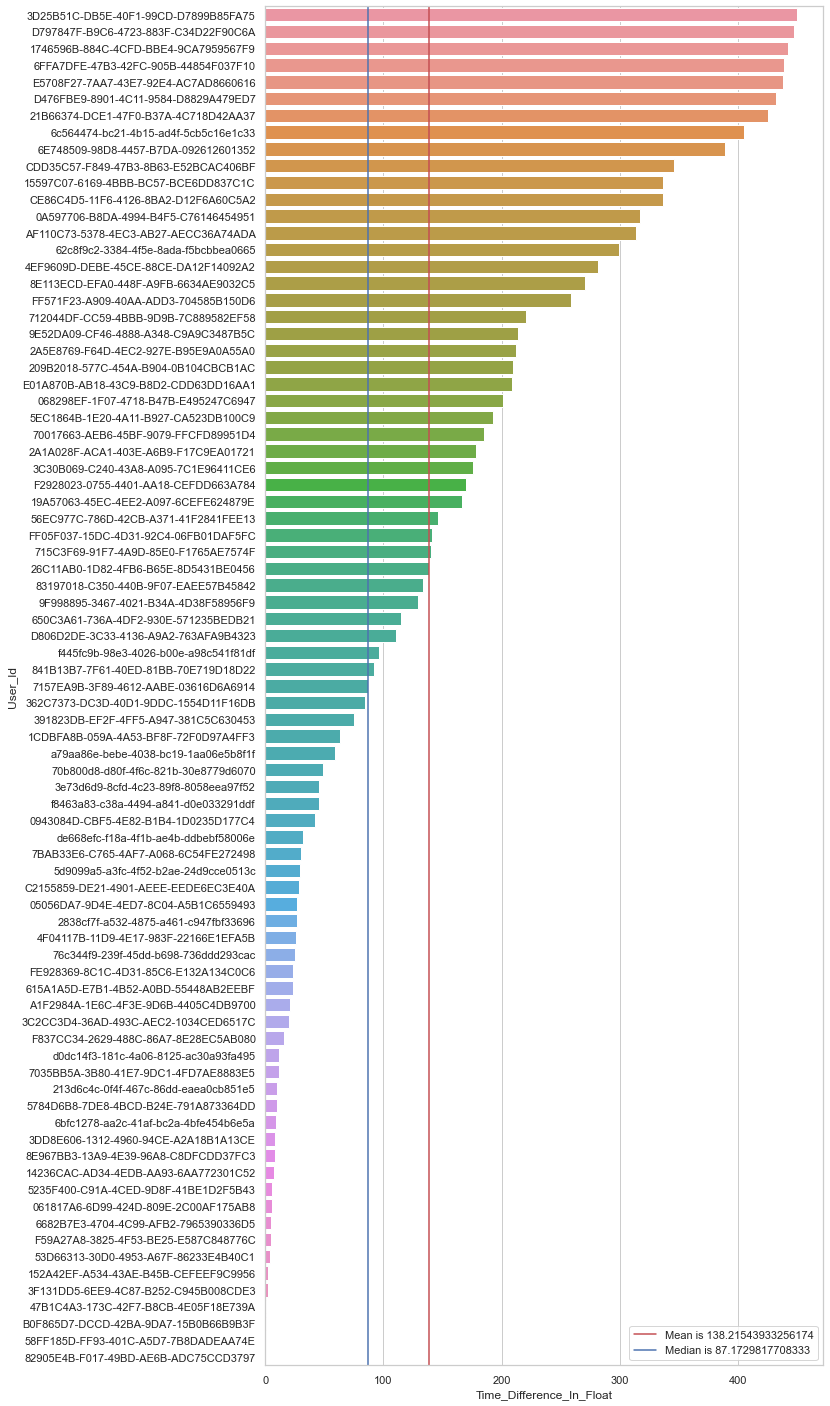

In [747]:
#dft_sv_csum1_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False).plot(kind="bar",figsize=(25,10))
plt.figure(figsize=(10,25))
sns.barplot(x=dft_sv_csum1_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False).values/256,
           y=dft_sv_csum1_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False).index)

plt.axvline((dft_sv_csum1_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False).values/256).mean(),
            c="r",
            label=f"Mean is {(dft_sv_csum1_2019.groupby('User_Id')['Time_Dif_Float'].sum().sort_values(ascending=False).values/256).mean()}")
        
                              
plt.axvline(np.median(dft_sv_csum1_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False).values/256),
            c="b",
            label=f"Median is {np.median(dft_sv_csum1_2019.groupby('User_Id')['Time_Dif_Float'].sum().sort_values(ascending=False).values/256)}")

plt.legend()
plt.xlabel("Time_Difference_In_Float")
plt.show()


***There are around 256 business days in TR for 2019 (assuming 5 working days in a week, no extra work hours) and
most of this values are not meaningful. 400mins for 1 individual in a business day cant be correct. This output
is problematic however if we check the Question1, Question2 we can see that this top 8-10 values are similar. There is sth not normal for that top 10 people. We will also check 0-1 hr.***

In [748]:
dft_sv_csum0_2019=dft_sv_csum1[(dft_sv_csum1["Time_Dif_Hr"]=="00")&(dft_sv_csum1["Year"]==2019)]

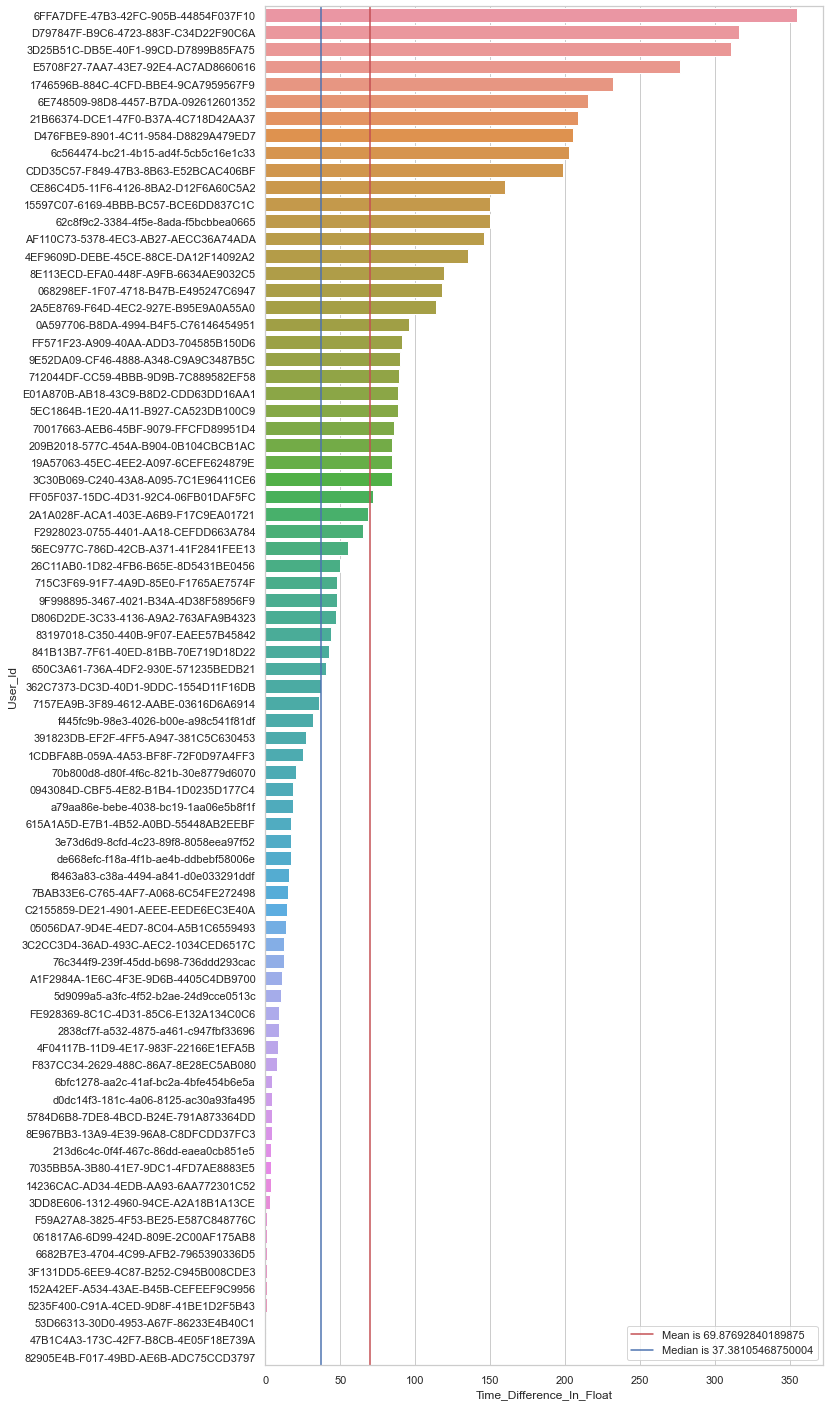

In [749]:
plt.figure(figsize=(10,25))
sns.barplot(x=dft_sv_csum0_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False).values/256,
           y=dft_sv_csum0_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False).index)

plt.axvline((dft_sv_csum0_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False).values/256).mean(),
            c="r",
            label=f"Mean is {(dft_sv_csum0_2019.groupby('User_Id')['Time_Dif_Float'].sum().sort_values(ascending=False).values/256).mean()}")
        
                              
plt.axvline(np.median(dft_sv_csum0_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False).values/256),
            c="b",
            label=f"Median is {np.median(dft_sv_csum0_2019.groupby('User_Id')['Time_Dif_Float'].sum().sort_values(ascending=False).values/256)}")

plt.legend()
plt.xlabel("Time_Difference_In_Float")
plt.show()

#now this data is much more meaningful. Because data is extremely skewed, its good idea to check median rather than mean
#and around 35-40 min break everyday is ok.

***We will do some filtering and get rid of some portion of the data, because they are either taking nearly no breaks or opposite***

In [750]:
dft_sv_csum0_2019_no=dft_sv_csum0_2019.groupby("User_Id")["Time_Dif_Float"].sum().sort_values(ascending=False)[10:-19]

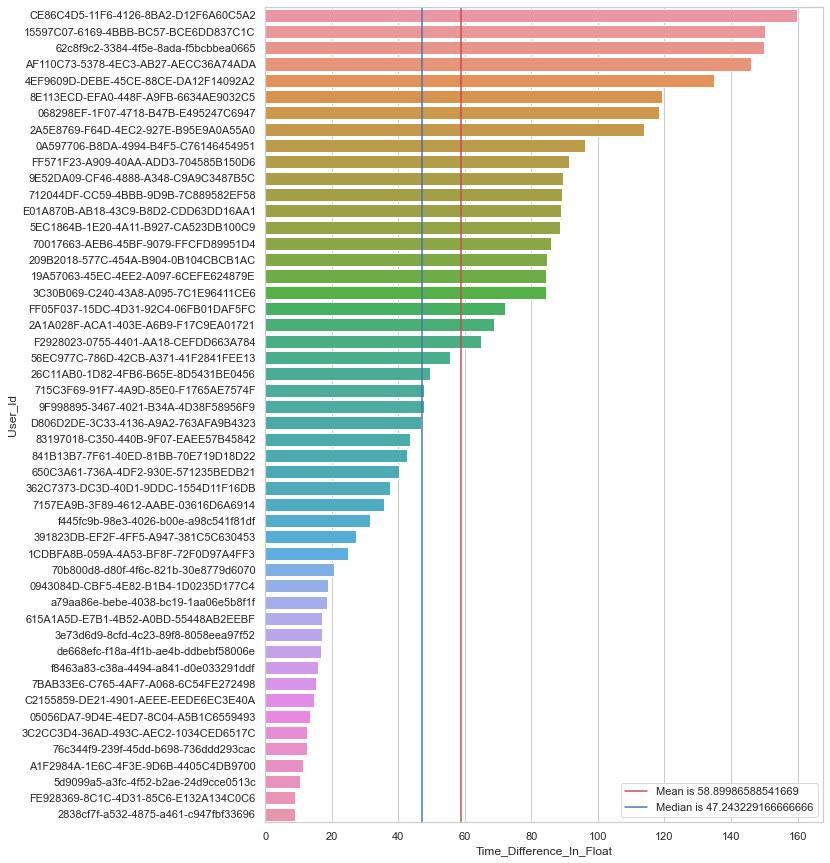

In [751]:
#There is a very high chance that if we remove top 10 and bottom 20 our mean/median values will be more meaningful.Lets see
plt.figure(figsize=(10,15))
sns.barplot(x=dft_sv_csum0_2019_no.values/256,
           y=dft_sv_csum0_2019_no.index)

plt.axvline((dft_sv_csum0_2019_no.values/256).mean(),
            c="r",
            label=f"Mean is {(dft_sv_csum0_2019_no.values/256).mean()}")
        
                              
plt.axvline(np.median(dft_sv_csum0_2019_no.values/256),
            c="b",
            label=f"Median is {np.median(dft_sv_csum0_2019_no.values/256)}")

plt.legend()
plt.xlabel("Time_Difference_In_Float")
plt.show()

#this data looks more balanced.

***Average Break Time for 1 Individual is around 50-60min, This is for any movement outside of the premise/building/office though. It could include lunchbreak also if individuals dont return after lunch break in 1hr.***

### Q6: Friends Clustering

***We will only be looking for breaks that are less than 1 hour. Then try to lower it to 30min 15min and 10min.***


***Here are our criteria:***
- ***we wont count any break (In-Out) that is less than 2mins as breaks***
- ***we wont count any break that is more than 1hr (we will be lowering this value down to 10 mins gradually)***

***It could be good idea to create couple features manually, in classification, anything that have some correlation w target variable
could explain some portion of variability of target however too many features will cause overfitting and bad test score. we
have around 72k sample for the first clustering phase and 5-6 features which means we are not prone to overfitting (i hope).
This logic works for clustering as well. We will add couple more features as well. Rolling windows (mean,max,min) could be
good***

***Individuals that have same amount of time outside could be friends.***

In [752]:
dft_sv_csum0_2019_fc=dft_sv_csum0_2019.copy()
dft_sv_csum0_2019_fc

ReadedAt                               User_Id Time_Dif  \
1203   2019-01-03 12:49:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:33:39   
1206   2019-01-04 08:36:06  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:10:27   
1207   2019-01-04 08:44:32  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:26   
1208   2019-01-04 09:00:35  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:16:03   
1209   2019-01-04 09:03:44  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:09   
...                    ...                                   ...      ...   
277172 2019-12-31 15:11:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:14   
277173 2019-12-31 16:10:38  f8463a83-c38a-4494-a841-d0e033291ddf 00:58:52   
277174 2019-12-31 16:14:52  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:14   
277176 2019-12-31 18:27:19  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:30   
277177 2019-12-31 19:25:59  f8463a83-c38a-4494-a841-d0e033291ddf 00:58:40   

       Time_Dif_Hr  Time_Dif_Float  Year  
1203            00       33.650000  2019  
1206            00       10.450000  2019  
1207            00        8.433333  2019  
1208            00       16.050000  2019  
1209            00        3.150000  2019  
...            ...             ...   ...  
277172          00        4.233333  2019  
277173          00       58.866667  2019  
277174          00        4.233333  2019  
277176          00        4.500000  2019  
277177          00       58.666667  2019  

[71880 rows x 6 columns]

In [753]:
dft_sv_csum0_2019_fc["Time"]=dft_sv_csum0_2019_fc["ReadedAt"].dt.time
dft_sv_csum0_2019_fc["Date"]=dft_sv_csum0_2019_fc["ReadedAt"].dt.date
dft_sv_csum0_2019_fc["Month"]=dft_sv_csum0_2019_fc["ReadedAt"].dt.month
dft_sv_csum0_2019_fc["Day"]=dft_sv_csum0_2019_fc["ReadedAt"].dt.day
dft_sv_csum0_2019_fc
#dft_sv_csum0_2019["ReadedAt"].dt.date[1203]

ReadedAt                               User_Id Time_Dif  \
1203   2019-01-03 12:49:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:33:39   
1206   2019-01-04 08:36:06  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:10:27   
1207   2019-01-04 08:44:32  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:26   
1208   2019-01-04 09:00:35  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:16:03   
1209   2019-01-04 09:03:44  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:09   
...                    ...                                   ...      ...   
277172 2019-12-31 15:11:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:14   
277173 2019-12-31 16:10:38  f8463a83-c38a-4494-a841-d0e033291ddf 00:58:52   
277174 2019-12-31 16:14:52  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:14   
277176 2019-12-31 18:27:19  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:30   
277177 2019-12-31 19:25:59  f8463a83-c38a-4494-a841-d0e033291ddf 00:58:40   

       Time_Dif_Hr  Time_Dif_Float  Year      Time        Date  Month  Day  
1203            00       33.650000  2019  12:49:17  2019-01-03      1    3  
1206            00       10.450000  2019  08:36:06  2019-01-04      1    4  
1207            00        8.433333  2019  08:44:32  2019-01-04      1    4  
1208            00       16.050000  2019  09:00:35  2019-01-04      1    4  
1209            00        3.150000  2019  09:03:44  2019-01-04      1    4  
...            ...             ...   ...       ...         ...    ...  ...  
277172          00        4.233333  2019  15:11:46  2019-12-31     12   31  
277173          00       58.866667  2019  16:10:38  2019-12-31     12   31  
277174          00        4.233333  2019  16:14:52  2019-12-31     12   31  
277176          00        4.500000  2019  18:27:19  2019-12-31     12   31  
277177          00       58.666667  2019  19:25:59  2019-12-31     12   31  

[71880 rows x 10 columns]

In [754]:
dft_sv_csum0_2019_fc=dft_sv_csum0_2019_fc.merge(dft_sv_csum0_2019_fc.groupby("User_Id")["Time_Dif_Float"].sum(),
                        left_on=dft_sv_csum0_2019_fc["User_Id"],
                        right_on=dft_sv_csum0_2019_fc.groupby("User_Id")["Time_Dif_Float"].sum().index,
                        how="left")

In [755]:
dft_sv_csum0_2019_fc.drop(labels=["key_0"],axis=1,inplace=True)

In [756]:
dft_sv_csum0_2019_fc.rename(columns={"Time_Dif_Float_x":"Time_Dif_Float","Time_Dif_Float_y":"Time_Dif_Cs"},inplace=True)

In [757]:
dft_sv_csum0_2019_fc.rename(columns={"Time_Dif_Cs":"Time_Dif_Sum"},inplace=True)

In [758]:
dft_sv_csum0_2019_fc.head()
#this will be good starting dset.

ReadedAt                               User_Id Time_Dif  \
0 2019-01-03 12:49:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:33:39   
1 2019-01-04 08:36:06  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:10:27   
2 2019-01-04 08:44:32  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:26   
3 2019-01-04 09:00:35  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:16:03   
4 2019-01-04 09:03:44  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:09   

  Time_Dif_Hr  Time_Dif_Float  Year      Time        Date  Month  Day  \
0          00       33.650000  2019  12:49:17  2019-01-03      1    3   
1          00       10.450000  2019  08:36:06  2019-01-04      1    4   
2          00        8.433333  2019  08:44:32  2019-01-04      1    4   
3          00       16.050000  2019  09:00:35  2019-01-04      1    4   
4          00        3.150000  2019  09:03:44  2019-01-04      1    4   

   Time_Dif_Sum  
0   3465.066667  
1   3465.066667  
2   3465.066667  
3   3465.066667  
4   3465.066667

In [759]:
dft_sv_csum0_2019_fc["User_Id"].nunique()

79

- ***It could be good idea to add User_Id as Categorical feature to our model***


- ***we have ~80 dif users. it wont be smart if we use onehotencoding (dummyencoding) to make user_id categorical. 90-100 features could be problematic. LabelEncoding isnt very logical either bcs its ordinal not nominal and it auto sets the ranking. However CountEncoding could be viable here. Individuals who have higher User_Id count may have a break together, bcs they have same amount of record.***


- ***Adding rolling window(mean,min,max,std) and weekend or weekday(binary) and expanding window (cumsum). More features we get more insights we get from our data and thus better clustering.*** 

In [760]:
dft_sv_csum0_2019_fc.groupby("User_Id")["Time_Dif_Float"].rolling(2,min_periods=1).agg(["mean","std","median","min","max"])
#we will also add cumulative sum and maybe quantiles.

mean        std     median  \
User_Id                                                                       
05056DA7-9D4E-4ED7-8C04-A5B1C6559493 0      33.650000        NaN  33.650000   
                                     1      22.050000  16.404877  22.050000   
                                     2       9.441667   1.425999   9.441667   
                                     3      12.241667   5.385797  12.241667   
                                     4       9.600000   9.121677   9.600000   
...                                               ...        ...        ...   
f8463a83-c38a-4494-a841-d0e033291ddf 71875  23.883333  27.789297  23.883333   
                                     71876  31.550000  38.631600  31.550000   
                                     71877  31.550000  38.631600  31.550000   
                                     71878   4.366667   0.188562   4.366667   
                                     71879  31.583333  38.301617  31.583333   

                                                  min        max  
User_Id                                                           
05056DA7-9D4E-4ED7-8C04-A5B1C6559493 0      33.650000  33.650000  
                                     1      10.450000  33.650000  
                                     2       8.433333  10.450000  
                                     3       8.433333  16.050000  
                                     4       3.150000  16.050000  
...                                               ...        ...  
f8463a83-c38a-4494-a841-d0e033291ddf 71875   4.233333  43.533333  
                                     71876   4.233333  58.866667  
                                     71877   4.233333  58.866667  
                                     71878   4.233333   4.500000  
                                     71879   4.500000  58.666667  

[71880 rows x 5 columns]

In [761]:
_=dft_sv_csum0_2019_fc.groupby("User_Id")["Time_Dif_Float"].rolling(3,min_periods=1).\
agg(["mean","std","median","min","max"]).reset_index()
_=_.drop(labels=["User_Id","level_1"],axis=1).rename(columns={"mean":"Time_Dif_Mean",
                                                                         "std":"Time_Dif_Std","median":"Time_Dif_Median",
                                                                         "min":"Time_Dif_Min","max":"Time_Dif_Max"})

dft_sv_csum0_2019_fc[['Time_Dif_Mean','Time_Dif_Std','Time_Dif_Median','Time_Dif_Min','Time_Dif_Max']]=_

In [762]:
dft_sv_csum0_2019_fc.isnull().sum()
#std for 1 value cant be calculated, we ll assign them as 0

ReadedAt            0
User_Id             0
Time_Dif            0
Time_Dif_Hr         0
Time_Dif_Float      0
Year                0
Time                0
Date                0
Month               0
Day                 0
Time_Dif_Sum        0
Time_Dif_Mean       0
Time_Dif_Std       79
Time_Dif_Median     0
Time_Dif_Min        0
Time_Dif_Max        0
dtype: int64

In [763]:
dft_sv_csum0_2019_fc.fillna(0.0,inplace=True)
dft_sv_csum0_2019_fc


ReadedAt                               User_Id Time_Dif  \
0     2019-01-03 12:49:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:33:39   
1     2019-01-04 08:36:06  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:10:27   
2     2019-01-04 08:44:32  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:26   
3     2019-01-04 09:00:35  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:16:03   
4     2019-01-04 09:03:44  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:09   
...                   ...                                   ...      ...   
71875 2019-12-31 15:11:46  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:14   
71876 2019-12-31 16:10:38  f8463a83-c38a-4494-a841-d0e033291ddf 00:58:52   
71877 2019-12-31 16:14:52  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:14   
71878 2019-12-31 18:27:19  f8463a83-c38a-4494-a841-d0e033291ddf 00:04:30   
71879 2019-12-31 19:25:59  f8463a83-c38a-4494-a841-d0e033291ddf 00:58:40   

      Time_Dif_Hr  Time_Dif_Float  Year      Time        Date  Month  Day  \
0              00       33.650000  2019  12:49:17  2019-01-03      1    3   
1              00       10.450000  2019  08:36:06  2019-01-04      1    4   
2              00        8.433333  2019  08:44:32  2019-01-04      1    4   
3              00       16.050000  2019  09:00:35  2019-01-04      1    4   
4              00        3.150000  2019  09:03:44  2019-01-04      1    4   
...           ...             ...   ...       ...         ...    ...  ...   
71875          00        4.233333  2019  15:11:46  2019-12-31     12   31   
71876          00       58.866667  2019  16:10:38  2019-12-31     12   31   
71877          00        4.233333  2019  16:14:52  2019-12-31     12   31   
71878          00        4.500000  2019  18:27:19  2019-12-31     12   31   
71879          00       58.666667  2019  19:25:59  2019-12-31     12   31   

       Time_Dif_Sum  Time_Dif_Mean  Time_Dif_Std  Time_Dif_Median  \
0       3465.066667      33.650000      0.000000        33.650000   
1       3465.066667      22.050000     16.404877        22.050000   
2       3465.066667      17.511111     14.013013        10.450000   
3       3465.066667      11.644444      3.946318        10.450000   
4       3465.066667       9.211111      6.485075         8.433333   
...             ...            ...           ...              ...   
71875   4053.483333      17.944444     22.179579         6.066667   
71876   4053.483333      35.544444     28.179195        43.533333   
71877   4053.483333      22.444444     31.542570         4.233333   
71878   4053.483333      22.533333     31.465872         4.500000   
71879   4053.483333      22.466667     31.350403         4.500000   

       Time_Dif_Min  Time_Dif_Max  
0         33.650000     33.650000  
1         10.450000     33.650000  
2          8.433333     33.650000  
3          8.433333     16.050000  
4          3.150000     16.050000  
...             ...           ...  
71875      4.233333     43.533333  
71876      4.233333     58.866667  
71877      4.233333     58.866667  
71878      4.233333     58.866667  
71879      4.233333     58.666667  

[71880 rows x 16 columns]

In [764]:
dft_sv_csum0_2019_fc.isnull().sum()

ReadedAt           0
User_Id            0
Time_Dif           0
Time_Dif_Hr        0
Time_Dif_Float     0
Year               0
Time               0
Date               0
Month              0
Day                0
Time_Dif_Sum       0
Time_Dif_Mean      0
Time_Dif_Std       0
Time_Dif_Median    0
Time_Dif_Min       0
Time_Dif_Max       0
dtype: int64

In [765]:
#dft_sv_csum0_2019_fc.groupby("User_Id")["Time_Dif_Float"].cumsum() #*.expanding().sum()

In [766]:
_=dft_sv_csum0_2019_fc.groupby("User_Id")["Time_Dif_Float"].cumsum()
dft_sv_csum0_2019_fc["Time_Dif_CSum"]=_

In [767]:
dft_sv_csum0_2019_fc.head()

ReadedAt                               User_Id Time_Dif  \
0 2019-01-03 12:49:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:33:39   
1 2019-01-04 08:36:06  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:10:27   
2 2019-01-04 08:44:32  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:26   
3 2019-01-04 09:00:35  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:16:03   
4 2019-01-04 09:03:44  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:09   

  Time_Dif_Hr  Time_Dif_Float  Year      Time        Date  Month  Day  \
0          00       33.650000  2019  12:49:17  2019-01-03      1    3   
1          00       10.450000  2019  08:36:06  2019-01-04      1    4   
2          00        8.433333  2019  08:44:32  2019-01-04      1    4   
3          00       16.050000  2019  09:00:35  2019-01-04      1    4   
4          00        3.150000  2019  09:03:44  2019-01-04      1    4   

   Time_Dif_Sum  Time_Dif_Mean  Time_Dif_Std  Time_Dif_Median  Time_Dif_Min  \
0   3465.066667      33.650000      0.000000        33.650000     33.650000   
1   3465.066667      22.050000     16.404877        22.050000     10.450000   
2   3465.066667      17.511111     14.013013        10.450000      8.433333   
3   3465.066667      11.644444      3.946318        10.450000      8.433333   
4   3465.066667       9.211111      6.485075         8.433333      3.150000   

   Time_Dif_Max  Time_Dif_CSum  
0         33.65      33.650000  
1         33.65      44.100000  
2         33.65      52.533333  
3         16.05      68.583333  
4         16.05      71.733333

In [768]:
_=dft_sv_csum0_2019_fc.groupby("User_Id")[["Time_Dif_Float"]].describe(percentiles = [ 0.05,0.20,0.80,0.95 ])["Time_Dif_Float"]\
[["5%","20%","80%","95%"]]
_
#dft_sv_csum0_2019_fc[["Time_Dif_Q5","Time_Dif_Q20","Time_Dif_Q80","Time_Dif_Q95"]]=_[["5%","20%","80%","95%"]]
#dft_sv_csum0_2019_fc

5%       20%        80%        95%
User_Id                                                                       
05056DA7-9D4E-4ED7-8C04-A5B1C6559493  2.150000  3.173333  39.993333  54.484167
061817A6-6D99-424D-809E-2C00AF175AB8  2.516667  3.766667  11.366667  51.716667
068298EF-1F07-4718-B47B-E495247C6947  4.250000  6.400000  42.860000  55.485000
0943084D-CBF5-4E82-B1B4-1D0235D177C4  2.952500  3.656667  37.286667  54.600000
0A597706-B8DA-4994-B4F5-C76146454951  3.066667  4.566667  26.926667  51.806667
14236CAC-AD34-4EDB-AA93-6AA772301C52  2.415000  5.273333  30.166667  49.832500
152A42EF-A534-43AE-B45B-CEFEEF9C9956  2.431667  2.646667  28.580000  50.186667
15597C07-6169-4BBB-BC57-BCE6DD837C1C  2.255833  2.800000  29.566667  51.477500
1746596B-884C-4CFD-BBE4-9CA7959567F9  3.099167  4.966667  40.986667  55.683333
19A57063-45EC-4EE2-A097-6CEFE624879E  3.916667  7.500000  45.000000  56.316667
1CDBFA8B-059A-4A53-BF8F-72F0D97A4FF3  3.350000  5.100000  32.033333  51.287500
209B2018-577C-454A-B904-0B104CBCB1AC  2.166667  3.450000  38.410000  54.793333
213d6c4c-0f4f-467c-86dd-eaea0cb851e5  2.651667  3.880000  40.943333  55.865833
21B66374-DCE1-47F0-B37A-4C718D42AA37  2.783333  4.050000  35.766667  54.283333
26C11AB0-1D82-4FB6-B65E-8D5431BE0456  2.634167  3.633333  25.326667  48.138333
2838cf7f-a532-4875-a461-c947fbf33696  2.506667  3.626667  33.983333  55.371667
2A1A028F-ACA1-403E-A6B9-F17C9EA01721  2.660000  5.233333  36.936667  53.596667
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0  3.282500  7.046667  37.500000  53.650000
362C7373-DC3D-40D1-9DDC-1554D11F16DB  2.915000  6.496667  37.866667  53.492500
391823DB-EF2F-4FF5-A947-381C5C630453  3.303333  4.463333  34.043333  53.336667
3C2CC3D4-36AD-493C-AEC2-1034CED6517C  3.475000  7.450000  39.786667  55.515000
3C30B069-C240-43A8-A095-7C1E96411CE6  3.354167  6.300000  42.116667  56.537500
3D25B51C-DB5E-40F1-99CD-D7899B85FA75  2.833333  3.950000  40.033333  54.133333
3DD8E606-1312-4960-94CE-A2A18B1A13CE  2.350000  4.150000  44.616667  55.850000
3F131DD5-6EE9-4C87-B252-C945B008CDE3  2.240000  4.900000  41.713333  54.320000
3e73d6d9-8cfd-4c23-89f8-8058eea97f52  3.071667  4.840000  37.593333  55.617500
47B1C4A3-173C-42F7-B8CB-4E05F18E739A  5.199167  5.296667  25.136667  44.996667
4EF9609D-DEBE-45CE-88CE-DA12F14092A2  2.166667  3.686667  46.796667  56.411667
4F04117B-11D9-4E17-983F-22166E1EFA5B  2.179167  3.083333  44.200000  52.479167
5235F400-C91A-4CED-9D8F-41BE1D2F5B43  2.436667  2.906667  11.466667  32.033333
53D66313-30D0-4953-A67F-86233E4B40C1  2.547500  2.986667   7.026667  29.665000
56EC977C-786D-42CB-A371-41F2841FEE13  3.466667  4.816667  32.986667  52.755000
5784D6B8-7DE8-4BCD-B24E-791A873364DD  3.358333  7.956667  38.026667  54.915833
5EC1864B-1E20-4A11-B927-CA523DB100C9  2.516667  3.000000  38.360000  52.813333
5d9099a5-a3fc-4f52-b2ae-24d9cce0513c  3.066667  5.383333  34.700000  54.116667
615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF  2.395833  3.806667  46.830000  55.385000
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665  2.378333  5.546667  40.036667  55.455000
650C3A61-736A-4DF2-930E-571235BEDB21  2.266667  2.713333  31.096667  52.718333
6682B7E3-4704-4C99-AFB2-7965390336D5  2.465833  3.156667  17.730000  53.744167
6E748509-98D8-4457-B7DA-092612601352  4.133333  5.850000  39.816667  54.616667
6FFA7DFE-47B3-42FC-905B-44854F037F10  4.650000  6.566667  36.610000  51.711667
6bfc1278-aa2c-41af-bc2a-4bfe454b6e5a  3.716667  8.623333  38.430000  52.226667
6c564474-bc21-4b15-ad4f-5cb5c16e1c33  3.942500  5.716667  38.720000  54.985833
70017663-AEB6-45BF-9079-FFCFD89951D4  2.409167  3.856667  39.076667  55.635000
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5  3.416667  9.546667  36.783333  55.470000
70b800d8-d80f-4f6c-821b-30e8779d6070  2.571667  5.720000  35.136667  51.818333
712044DF-CC59-4BBB-9D9B-7C889582EF58  2.376667  3.723333  36.506667  54.416667
7157EA9B-3F89-4612-AABE-03616D6A6914  2.640000  3.880000  46.913333  56.413333
715C3F69-91F7-4A9D-85E0-F1765AE7574F  3.728333  5.923333  36.930000  54.546667
76c344f9-239f-4

In [769]:
dft_sv_csum0_2019_fc=dft_sv_csum0_2019_fc.merge(_,how="left",left_on=dft_sv_csum0_2019_fc["User_Id"],right_on=_.index)
dft_sv_csum0_2019_fc.drop(labels=["key_0"],inplace=True,axis=1)

In [770]:
dft_sv_csum0_2019_fc.rename(columns={"5%":"Time_Dif_Q5","20%":"Time_Dif_Q20","80%":"Time_Dif_Q80","95%":"Time_Dif_Q95"},inplace=True)

In [771]:
dft_sv_csum0_2019_fc["ReadedAt"].dt.weekday.value_counts(normalize=True)

#from this value, only %0.6 of the people recorded (ofc this is filtered data) that goes to work on weekend,
#other %99.4 of them dont. I dont want to deal with imbalanced categorical feature, it could cause problems on feature
#elimination steps (PCA wont work well w imbalanced features, more uniform data, better results) so i wont use this. However
#i ll add counts

2    0.210476
3    0.207679
1    0.196216
0    0.190915
4    0.187938
6    0.003659
5    0.003116
Name: ReadedAt, dtype: float64

In [772]:
_=dft_sv_csum0_2019_fc["User_Id"].value_counts()

dft_sv_csum0_2019_fc=dft_sv_csum0_2019_fc.merge(_,how="left",left_on=dft_sv_csum0_2019_fc["User_Id"],right_on=_.index)
dft_sv_csum0_2019_fc.drop(labels=["key_0"],inplace=True,axis=1)

In [773]:
dft_sv_csum0_2019_fc.rename(columns={"User_Id_x":"User_Id","User_Id_y":"Uid_Count"},inplace=True)

In [774]:
dft_sv_csum0_2019_fc.head()

#i think this dset is enough for now. This is for 0-1 hour

ReadedAt                               User_Id Time_Dif  \
0 2019-01-03 12:49:17  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:33:39   
1 2019-01-04 08:36:06  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:10:27   
2 2019-01-04 08:44:32  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:08:26   
3 2019-01-04 09:00:35  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:16:03   
4 2019-01-04 09:03:44  05056DA7-9D4E-4ED7-8C04-A5B1C6559493 00:03:09   

  Time_Dif_Hr  Time_Dif_Float  Year      Time        Date  Month  Day  ...  \
0          00       33.650000  2019  12:49:17  2019-01-03      1    3  ...   
1          00       10.450000  2019  08:36:06  2019-01-04      1    4  ...   
2          00        8.433333  2019  08:44:32  2019-01-04      1    4  ...   
3          00       16.050000  2019  09:00:35  2019-01-04      1    4  ...   
4          00        3.150000  2019  09:03:44  2019-01-04      1    4  ...   

   Time_Dif_Std  Time_Dif_Median  Time_Dif_Min  Time_Dif_Max  Time_Dif_CSum  \
0      0.000000        33.650000     33.650000         33.65      33.650000   
1     16.404877        22.050000     10.450000         33.65      44.100000   
2     14.013013        10.450000      8.433333         33.65      52.533333   
3      3.946318        10.450000      8.433333         16.05      68.583333   
4      6.485075         8.433333      3.150000         16.05      71.733333   

   Time_Dif_Q5  Time_Dif_Q20  Time_Dif_Q80  Time_Dif_Q95  Uid_Count  
0         2.15      3.173333     39.993333     54.484167        172  
1         2.15      3.173333     39.993333     54.484167        172  
2         2.15      3.173333     39.993333     54.484167        172  
3         2.15      3.173333     39.993333     54.484167        172  
4         2.15      3.173333     39.993333     54.484167        172  

[5 rows x 22 columns]

In [775]:
dft_sv_csum0_2019_fc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71880 entries, 0 to 71879
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   ReadedAt         71880 non-null  datetime64[ns] 
 1   User_Id          71880 non-null  object         
 2   Time_Dif         71880 non-null  timedelta64[ns]
 3   Time_Dif_Hr      71880 non-null  object         
 4   Time_Dif_Float   71880 non-null  float64        
 5   Year             71880 non-null  int64          
 6   Time             71880 non-null  object         
 7   Date             71880 non-null  object         
 8   Month            71880 non-null  int64          
 9   Day              71880 non-null  int64          
 10  Time_Dif_Sum     71880 non-null  float64        
 11  Time_Dif_Mean    71880 non-null  float64        
 12  Time_Dif_Std     71880 non-null  float64        
 13  Time_Dif_Median  71880 non-null  float64        
 14  Time_Dif_Min     71880

In [776]:
dft_sv_csum0_2019_fc_num=dft_sv_csum0_2019_fc.select_dtypes(include=["int64","float64"]).copy()
dft_sv_csum0_2019_fc_num.head()


Time_Dif_Float  Year  Month  Day  Time_Dif_Sum  Time_Dif_Mean  \
0       33.650000  2019      1    3   3465.066667      33.650000   
1       10.450000  2019      1    4   3465.066667      22.050000   
2        8.433333  2019      1    4   3465.066667      17.511111   
3       16.050000  2019      1    4   3465.066667      11.644444   
4        3.150000  2019      1    4   3465.066667       9.211111   

   Time_Dif_Std  Time_Dif_Median  Time_Dif_Min  Time_Dif_Max  Time_Dif_CSum  \
0      0.000000        33.650000     33.650000         33.65      33.650000   
1     16.404877        22.050000     10.450000         33.65      44.100000   
2     14.013013        10.450000      8.433333         33.65      52.533333   
3      3.946318        10.450000      8.433333         16.05      68.583333   
4      6.485075         8.433333      3.150000         16.05      71.733333   

   Time_Dif_Q5  Time_Dif_Q20  Time_Dif_Q80  Time_Dif_Q95  Uid_Count  
0         2.15      3.173333     39.993333     54.484167        172  
1         2.15      3.173333     39.993333     54.484167        172  
2         2.15      3.173333     39.993333     54.484167        172  
3         2.15      3.173333     39.993333     54.484167        172  
4         2.15      3.173333     39.993333     54.484167        172

In [777]:
dft_sv_csum0_2019_fc_num.drop(['Year', 'Month',"Day"], axis=1,inplace=True)

#i'll delete year,month,day. and also uid count. It changes from 0-4k with average=900 and std=1060

In [778]:
dft_sv_csum0_2019_fc_num.head()

Time_Dif_Float  Time_Dif_Sum  Time_Dif_Mean  Time_Dif_Std  Time_Dif_Median  \
0       33.650000   3465.066667      33.650000      0.000000        33.650000   
1       10.450000   3465.066667      22.050000     16.404877        22.050000   
2        8.433333   3465.066667      17.511111     14.013013        10.450000   
3       16.050000   3465.066667      11.644444      3.946318        10.450000   
4        3.150000   3465.066667       9.211111      6.485075         8.433333   

   Time_Dif_Min  Time_Dif_Max  Time_Dif_CSum  Time_Dif_Q5  Time_Dif_Q20  \
0     33.650000         33.65      33.650000         2.15      3.173333   
1     10.450000         33.65      44.100000         2.15      3.173333   
2      8.433333         33.65      52.533333         2.15      3.173333   
3      8.433333         16.05      68.583333         2.15      3.173333   
4      3.150000         16.05      71.733333         2.15      3.173333   

   Time_Dif_Q80  Time_Dif_Q95  Uid_Count  
0     39.993333     54.484167        172  
1     39.993333     54.484167        172  
2     39.993333     54.484167        172  
3     39.993333     54.484167        172  
4     39.993333     54.484167        172

In [779]:
#i will check all cols' correlation values and their histogram. if there are cols that are highly correlated w each other,
#it could be good idea to remove them to deal with problem of colinearity

In [780]:
corr_matrix=dft_sv_csum0_2019_fc_num.corr()
corr_matrix

Time_Dif_Float  Time_Dif_Sum  Time_Dif_Mean  Time_Dif_Std  \
Time_Dif_Float         1.000000      0.039953       0.573406      0.349769   
Time_Dif_Sum           0.039953      1.000000       0.077557      0.060660   
Time_Dif_Mean          0.573406      0.077557       1.000000      0.672493   
Time_Dif_Std           0.349769      0.060660       0.672493      1.000000   
Time_Dif_Median        0.532236      0.055562       0.838724      0.292819   
Time_Dif_Min           0.291223      0.041643       0.539547     -0.095432   
Time_Dif_Max           0.454512      0.074087       0.855203      0.940278   
Time_Dif_CSum          0.024651      0.668465       0.047763      0.013254   
Time_Dif_Q5            0.053298      0.487735       0.103240     -0.005570   
Time_Dif_Q20           0.079106      0.242754       0.153609     -0.006262   
Time_Dif_Q80           0.112438      0.239135       0.218778      0.152998   
Time_Dif_Q95           0.086930      0.047511       0.169331      0.139528   
Uid_Count              0.023480      0.988111       0.045555      0.051932   

                 Time_Dif_Median  Time_Dif_Min  Time_Dif_Max  Time_Dif_CSum  \
Time_Dif_Float          0.532236      0.291223      0.454512       0.024651   
Time_Dif_Sum            0.055562      0.041643      0.074087       0.668465   
Time_Dif_Mean           0.838724      0.539547      0.855203       0.047763   
Time_Dif_Std            0.292819     -0.095432      0.940278       0.013254   
Time_Dif_Median         1.000000      0.457168      0.475266       0.045203   
Time_Dif_Min            0.457168      1.000000      0.233118       0.042809   
Time_Dif_Max            0.475266      0.233118      1.000000       0.031278   
Time_Dif_CSum           0.045203      0.042809      0.031278       1.000000   
Time_Dif_Q5             0.080676      0.178294      0.054257       0.330423   
Time_Dif_Q20            0.127828      0.247721      0.079971       0.163245   
Time_Dif_Q80            0.169517      0.125286      0.196142       0.163238   
Time_Dif_Q95            0.117984      0.083695      0.166739       0.030551   
Uid_Count               0.027478      0.007520      0.053065       0.659350   

                 Time_Dif_Q5  Time_Dif_Q20  Time_Dif_Q80  Time_Dif_Q95  \
Time_Dif_Float      0.053298      0.079106      0.112438      0.086930   
Time_Dif_Sum        0.487735      0.242754      0.239135      0.047511   
Time_Dif_Mean       0.103240      0.153609      0.218778      0.169331   
Time_Dif_Std       -0.005570     -0.006262      0.152998      0.139528   
Time_Dif_Median     0.080676      0.127828      0.169517      0.117984   
Time_Dif_Min        0.178294      0.247721      0.125286      0.083695   
Time_Dif_Max        0.054257      0.079971      0.196142      0.166739   
Time_Dif_CSum       0.330423      0.163245      0.163238      0.030551   
Time_Dif_Q5         1.000000      0.782609      0.110768     -0.012599   
Time_Dif_Q20        0.782609      1.000000      0.260603      0.215153   
Time_Dif_Q80        0.110768      0.260603      1.000000      0.815064   
Time_Dif_Q95       -0.012599      0.215153      0.815064      1.000000   
Uid_Count           0.417305      0.144912      0.144059     -0.016752   

                 Uid_Count  
Time_Dif_Float    0.023480  
Time_Dif_Sum      0.988111  
Time_Dif_Mean     0.045555  
Time_Dif_Std      0.051932  
Time_Dif_Median   0.027478  
Time_Dif_Min      0.007520  
Time_Dif_Max      0.053065  
Time_Dif_CSum     0.659350  
Time_Dif_Q5       0.417305  
Time_Dif_Q20      0.144912  
Time_Dif_Q80      0.144059  
Time_Dif_Q95     -0.016752  
Uid_Count         1.000000

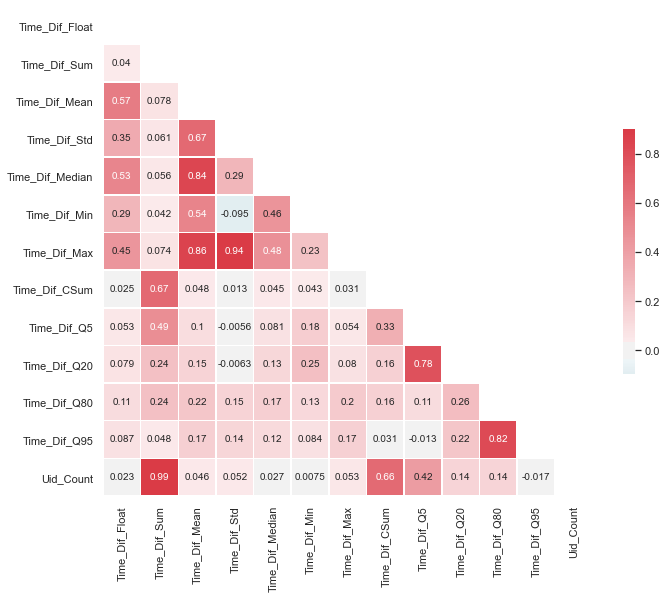

In [781]:
#sns.heatmap(corr_matrix,annot=True)
upper_triangle_mask=np.triu(np.ones_like(corr_matrix, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=upper_triangle_mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

#time_dif_sum is sigma(time_dif_float.uid_count) thus theyre totally correlated, so we could remove "uid_count"
#I ll keep time_dif_max and time_dif_std though, because we have few columns for this many of sample.

In [782]:
dft_sv_csum0_2019_fc_num.drop(labels=["Uid_Count"],axis=1,inplace=True)

***K-means performs best when clusters are:***

   - ***“round” or spherical***
   - ***equally sized***
   - ***equally dense***
   - ***most dense in the center of the sphere***
   - ***not contaminated by noise/outliers***
   
***K-means has a hard time when The data set has:***

   - ***Clusters with arbitrary shapes***
   - ***Clusters of different sizes***
   - ***Clusters with different densities***
   - ***Some noise and maybe some outliers***
   
   
**https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e**

***We try to make our data central, less noise/outliers overall normally distributed for better kmeans results.
Here is what we ll do; apply log and sqrt transformation and then standard scaler. I ll check kurtosis/skewness values and choose sth that is the closest to normal dist overall. kurtosis =~3 and skewness = 0.***

In [783]:
log_e=dft_sv_csum0_2019_fc_num.transform(lambda x: np.log(x+1))
log_10=dft_sv_csum0_2019_fc_num.transform(lambda x: np.log10(x+1))
sqrt_2=dft_sv_csum0_2019_fc_num.transform(lambda x: np.sqrt(x))

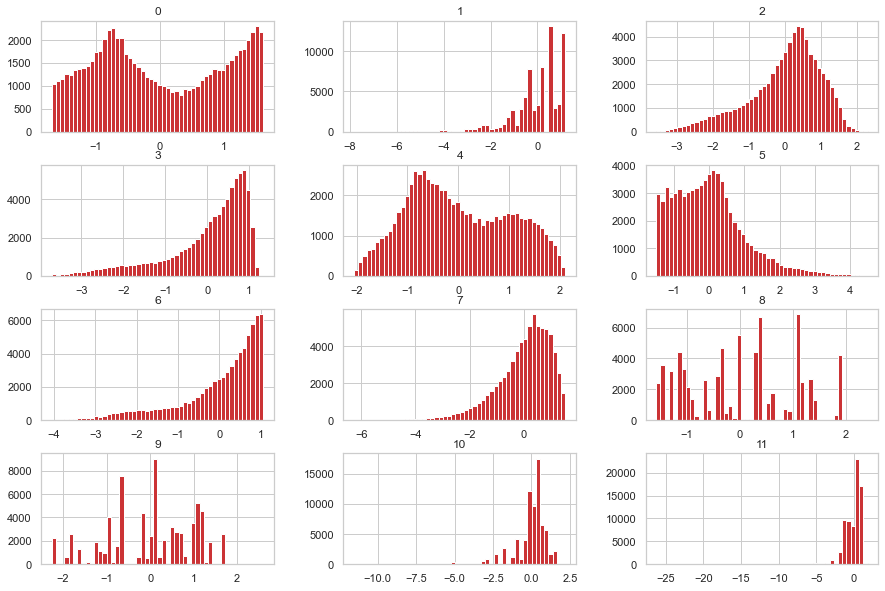

In [784]:
stdscaler=StandardScaler()
X_train=stdscaler.fit_transform(log_e)
_=pd.DataFrame(X_train)
_.hist(figsize=(15,10),bins=50)
plt.show()

#for loge and stdscaler

In [785]:
pd.DataFrame(pd.DataFrame.kurtosis(_)).T
#kurtosis =~3 and skewness = 0 for normal dist

0         1         2       3         4        5         6  \
0 -1.348199  3.281695  0.332809  1.2322 -0.986302  1.05236  1.176439   

          7         8         9         10         11  
0  2.231116 -1.069277 -0.624517  10.145547  53.401831

In [786]:
pd.DataFrame(pd.DataFrame.skew(_)).T
#kurtosis =~3 and skewness = 0. for normal dist

0        1         2         3         4         5         6  \
0  0.105748 -1.44907 -0.800842 -1.341483  0.199922  0.922713 -1.332842   

        7         8         9        10        11  
0 -1.2242  0.162342 -0.379184 -2.168147 -3.680024

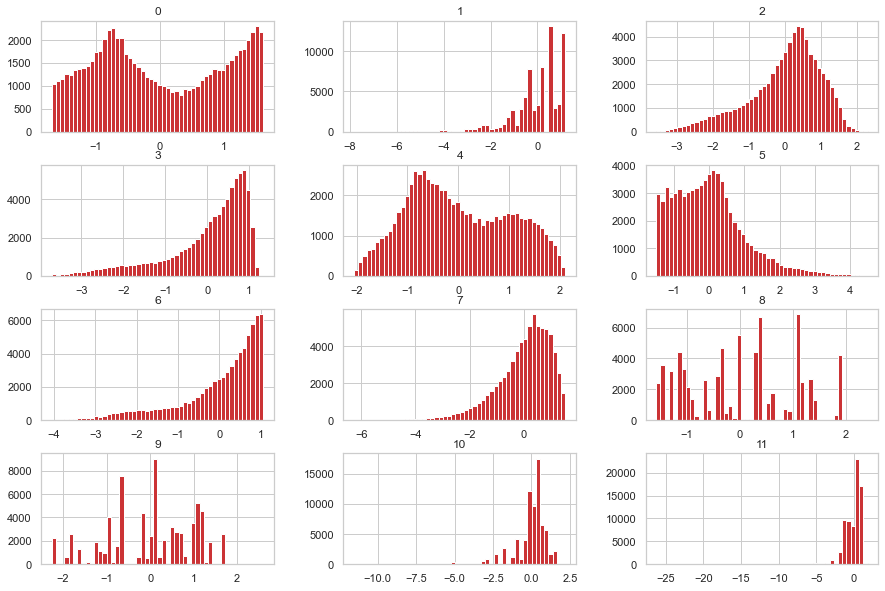

In [787]:
stdscaler=StandardScaler()
X_train=stdscaler.fit_transform(log_10)
_=pd.DataFrame(X_train)
_.hist(figsize=(15,10),bins=50)
plt.show()

#for log10 and stdscaler

In [788]:
pd.DataFrame(pd.DataFrame.kurtosis(_)).T
#kurtosis =~3 and skewness = 0. for normal dist


0         1         2       3         4        5         6  \
0 -1.348199  3.281695  0.332809  1.2322 -0.986302  1.05236  1.176439   

          7         8         9         10         11  
0  2.231116 -1.069277 -0.624517  10.145547  53.401831

In [789]:
pd.DataFrame(pd.DataFrame.skew(_)).T
#kurtosis =~3 and skewness = 0. for normal dist

0        1         2         3         4         5         6  \
0  0.105748 -1.44907 -0.800842 -1.341483  0.199922  0.922713 -1.332842   

        7         8         9        10        11  
0 -1.2242  0.162342 -0.379184 -2.168147 -3.680024

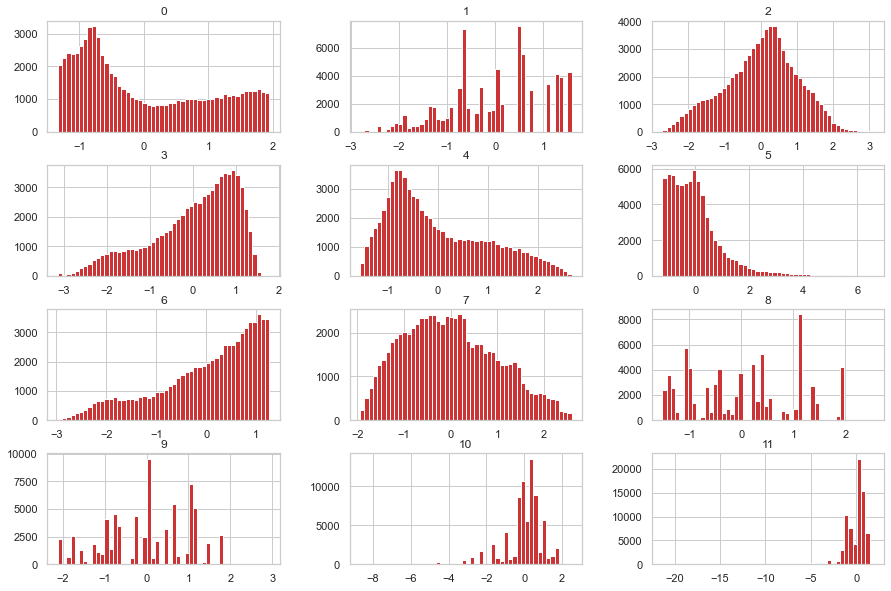

In [790]:
stdscaler=StandardScaler()
X_train=stdscaler.fit_transform(sqrt_2)
_=pd.DataFrame(X_train)
_.hist(figsize=(15,10),bins=50)
plt.show()

#for sqrt and stdscaler

In [791]:
pd.DataFrame(pd.DataFrame.kurtosis(_)).T
#kurtosis =~3 and skewness = 0. for normal dist

0         1         2         3        4         5         6  \
0 -1.182913 -0.751442 -0.350744 -0.220888 -0.59104  4.779748 -0.254428   

          7         8         9       10         11  
0 -0.644597 -1.010403 -0.736406  5.00071  28.853489

In [792]:
pd.DataFrame(pd.DataFrame.skew(_)).T
#kurtosis =~3 and skewness = 0. for normal dist

0        1         2         3         4         5         6  \
0  0.480351 -0.23965 -0.233779 -0.781156  0.667482  1.784673 -0.822593   

          7         8        9        10        11  
0  0.322422  0.243565 -0.21627 -1.587847 -2.747935

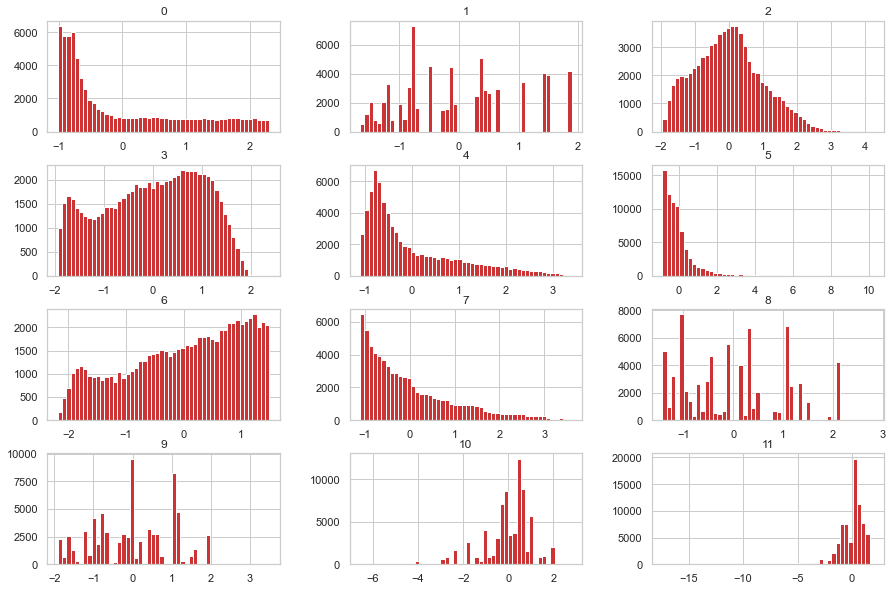

In [793]:
stdscaler=StandardScaler()
X_train=stdscaler.fit_transform(dft_sv_csum0_2019_fc_num)
_=pd.DataFrame(X_train)
_.hist(figsize=(15,10),bins=50)
plt.show()

#just stdscaler, no other transformation

In [794]:
pd.DataFrame(pd.DataFrame.kurtosis(_)).T
#kurtosis =~3 and skewness = 0. for normal dist

0         1         2         3         4          5         6  \
0 -0.674027 -0.994212 -0.184906 -1.032481  0.482692  16.223896 -0.967118   

        7         8         9        10         11  
0  0.8228 -0.861529 -0.784453  2.638498  16.502974

In [795]:
pd.DataFrame(pd.DataFrame.skew(_)).T
#kurtosis =~3 and skewness = 0. for normal dist

0         1         2         3         4         5         6  \
0  0.852623  0.336179  0.365796 -0.201429  1.177182  3.356839 -0.396697   

          7         8         9        10        11  
0  1.181084  0.403512  0.034048 -1.163724 -2.142693

***loge and log10 have same kurtosis/skewness values. btw loge,sqrt and just scaler models. I choose sqrt and scaler option
lets check our model...***

In [797]:
sqrt_2

Time_Dif_Float  Time_Dif_Sum  Time_Dif_Mean  Time_Dif_Std  \
0            5.800862     58.864817       5.800862      0.000000   
1            3.232646     58.864817       4.695743      4.050293   
2            2.904020     58.864817       4.184628      3.743396   
3            4.006245     58.864817       3.412396      1.986534   
4            1.774824     58.864817       3.034981      2.546581   
...               ...           ...            ...           ...   
71875        2.057507     63.666972       4.236088      4.709520   
71876        7.672462     63.666972       5.961916      5.308408   
71877        2.057507     63.666972       4.737557      5.616277   
71878        2.121320     63.666972       4.746929      5.609445   
71879        7.659417     63.666972       4.739902      5.599143   

       Time_Dif_Median  Time_Dif_Min  Time_Dif_Max  Time_Dif_CSum  \
0             5.800862      5.800862      5.800862       5.800862   
1             4.695743      3.232646      5.800862       6.640783   
2             3.232646      2.904020      5.800862       7.247988   
3             3.232646      2.904020      4.006245       8.281505   
4             2.904020      1.774824      4.006245       8.469553   
...                ...           ...           ...            ...   
71875         2.463060      2.057507      6.597979      62.667509   
71876         6.597979      2.057507      7.672462      63.135436   
71877         2.057507      2.057507      7.672462      63.168953   
71878         2.121320      2.057507      7.672462      63.204562   
71879         2.121320      2.057507      7.659417      63.666972   

       Time_Dif_Q5  Time_Dif_Q20  Time_Dif_Q80  Time_Dif_Q95  
0         1.466288      1.781385      6.324028      7.381339  
1         1.466288      1.781385      6.324028      7.381339  
2         1.466288      1.781385      6.324028      7.381339  
3         1.466288      1.781385      6.324028      7.381339  
4         1.466288      1.781385      6.324028      7.381339  
...            ...           ...           ...           ...  
71875     1.622498      2.258318      5.995276      7.472561  
71876     1.622498      2.258318      5.995276      7.472561  
71877     1.622498      2.258318      5.995276      7.472561  
71878     1.622498      2.258318      5.995276      7.472561  
71879     1.622498      2.258318      5.995276      7.472561  

[71880 rows x 12 columns]

### Model Investigation - 1

In [ ]:
# pipeline_clf = Pipeline([('sc', StandardScaler()),
#                    ('nrm', Normalizer()),
#                    ('pc', PCA()),
#                    ('clust',   KMeans())])
# parameters = {'nrm__norm': ("l2", "l1"),
#               'pc__n_components': (4,5),
#              "clust__n_clusters":(3,4,5)}
# gs_clf = GridSearchCV(pipeline_clf, parameters, n_jobs=-1, scoring=make_scorer(homogeneity_score),verbose=2)
# gs_clf.fit(X=dft_sv_csum0_2019_fc_num,y=None).best_estimator_

# our gridsearchcv has problems working with unsupervised learning, so we'll do it manually

In [798]:
test_list=[]
for df in (sqrt_2, dft_sv_csum0_2019_fc_num):
    scaler = StandardScaler() 
    scaled_df = scaler.fit_transform(df)
    for norm in ("l1","l2"):
        normalized_df = normalize(scaled_df,norm)
        normalized_df = pd.DataFrame(normalized_df)
        for nc in (3,4,5):
            pca = PCA(n_components = nc)
            X_principal = pca.fit_transform(normalized_df)
            X_principal = pd.DataFrame(X_principal)
            for ncl in (4,5):
                kmeans = KMeans(n_clusters=ncl,random_state=0)
                labels = kmeans.fit_predict(X_principal)
                df_ct = pd.DataFrame({'cluster_labels': labels, 'User_Id': dft_sv_csum0_2019_fc["User_Id"]})
                ct = pd.crosstab(df_ct["cluster_labels"],df_ct["User_Id"])
                _=pd.DataFrame(data={"most_density":(ct/ct.sum()).idxmax(),"cl_percentage":(ct/ct.sum()).max(axis=0)})
                test_list.append(_)
                


In [799]:
all_tests=pd.concat(test_list,axis=1)
all_tests.columns=["t0431","t0431p","t0531","t0531p","t0441","t0441p","t0541","t0541p","t0451","t0451p","t0551","t0551p",
                  "t0432","t0432p","t0532","t0532p","t0442","t0442p","t0542","t0542p","t0452","t0452p","t0552","t0552p",
                  "t1431","t1431p","t1531","t1531p","t1441","t1441p","t1541","t1541p","t1451","t1451p","t1551","t1551p",
                  "t1432","t1432p","t1532","t1532p","t1442","t1442p","t1542","t1542p","t1452","t1452p","t1552","t1552p"]
all_tests


t0431    t0431p  t0531    t0531p  t0441  \
User_Id                                                                         
05056DA7-9D4E-4ED7-8C04-A5B1C6559493      3  0.750000      3  0.726744      1   
061817A6-6D99-424D-809E-2C00AF175AB8      2  0.761905      2  0.761905      1   
068298EF-1F07-4718-B47B-E495247C6947      0  0.701436      1  0.681028      0   
0943084D-CBF5-4E82-B1B4-1D0235D177C4      3  0.566116      3  0.574380      1   
0A597706-B8DA-4994-B4F5-C76146454951      2  0.624924      2  0.640048      1   
14236CAC-AD34-4EDB-AA93-6AA772301C52      2  0.666667      2  0.616667      1   
152A42EF-A534-43AE-B45B-CEFEEF9C9956      2  0.533333      3  0.533333      1   
15597C07-6169-4BBB-BC57-BCE6DD837C1C      3  0.514798      2  0.569704      1   
1746596B-884C-4CFD-BBE4-9CA7959567F9      1  0.472973      0  0.434122      3   
19A57063-45EC-4EE2-A097-6CEFE624879E      0  0.755459      1  0.734716      0   
1CDBFA8B-059A-4A53-BF8F-72F0D97A4FF3      2  0.601036      2  0.585492      1   
209B2018-577C-454A-B904-0B104CBCB1AC      3  0.666368      3  0.640359      1   
213d6c4c-0f4f-467c-86dd-eaea0cb851e5      3  0.666667      3  0.687500      1   
21B66374-DCE1-47F0-B37A-4C718D42AA37      3  0.361160      0  0.340203      2   
26C11AB0-1D82-4FB6-B65E-8D5431BE0456      2  0.629712      2  0.652993      1   
2838cf7f-a532-4875-a461-c947fbf33696      3  0.607407      3  0.555556      1   
2A1A028F-ACA1-403E-A6B9-F17C9EA01721      2  0.440884      3  0.478453      2   
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0      0  0.618382      1  0.583824      0   
362C7373-DC3D-40D1-9DDC-1554D11F16DB      2  0.430612      3  0.442857      0   
391823DB-EF2F-4FF5-A947-381C5C630453      2  0.501266      2  0.496203      1   
3C2CC3D4-36AD-493C-AEC2-1034CED6517C      0  0.643357      1  0.615385      0   
3C30B069-C240-43A8-A095-7C1E96411CE6      0  0.593750      1  0.566288      0   
3D25B51C-DB5E-40F1-99CD-D7899B85FA75      1  0.549437      0  0.691140      3   
3DD8E606-1312-4960-94CE-A2A18B1A13CE      3  0.585366      3  0.682927      0   
3F131DD5-6EE9-4C87-B252-C945B008CDE3      3  0.857143      3  0.857143      1   
3e73d6d9-8cfd-4c23-89f8-8058eea97f52      3  0.482759      3  0.534483      2   
47B1C4A3-173C-42F7-B8CB-4E05F18E739A      2  0.750000      2  0.750000      2   
4EF9609D-DEBE-45CE-88CE-DA12F14092A2      3  0.671438      3  0.412406      0   
4F04117B-11D9-4E17-983F-22166E1EFA5B      3  0.745283      3  0.716981      1   
5235F400-C91A-4CED-9D8F-41BE1D2F5B43      2  0.840000      2  0.840000      1   
53D66313-30D0-4953-A67F-86233E4B40C1      2  0.750000      2  0.833333      1   
56EC977C-786D-42CB-A371-41F2841FEE13      2  0.541565      2  0.535452      2   
5784D6B8-7DE8-4BCD-B24E-791A873364DD      0  0.596154      1  0.442308      0   
5EC1864B-1E20-4A11-B927-CA523DB100C9      3  0.689223      3  0.626566      1   
5d9099a5-a3fc-4f52-b2ae-24d9cce0513c      2  0.436508      3  0.619048      0   
615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF      3  0.574468      3  0.585106      0   
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665      0  0.328760      1  0.274406      0   
650C3A61-736A-4DF2-930E-571235BEDB21      3  0.596875      3  0.517188      1   
6682B7E3-4704-4C99-AFB2-7965390336D5      2  0.500000      2  0.500000      1   
6E748509-98D8-4457-B7DA-092612601352      1  0.486276      1  0.479599      3   
6FFA7DFE-47B3-42FC-905B-44854F037F10      1  0.557606      4  0.519281      3   
6bfc1278-aa2c-41af-bc2a-4bfe454b6e5a      0  0.716981      1  0.698113      0   
6c564474-bc21-4b15-ad4f-5cb5c16e1c33      0  0.496815      1  0.482484      3   
70017663-AEB6-45BF-9079-FFCFD89951D4      3  0.636285      3  0.622396      1   
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5      0  0.644444      1  0.644444      0   
70b800d8-d80f-4f6c-821b-30e8779d6070      3  0.580524      3  0.602996      1   
712044DF-CC59-4BBB-9D9B-7C889582EF58      3  0.605656      3  0.573449      1   
7157EA9B-3F89-4612-AABE-03616D6A6914      3  0.698765      3  0.75061

***Here is the order and how to read it:
there are 24 models in total each have 2 cols, first ist the cluster_label they have most data in and 2nd is its percentage***

***Starting from t0431 (test0_4_3_l1) :***
- <font color=red> Which stands for dset=sqrt_2/log_e, ncluster=4, pca n_components=3, & normalization=l1 (lasso)</font>

***Or t1532 :***
- <font color=red> Which stands for dset= dft_sv_csum0_2019_fc_num, ncluster=5, pca n_components=3 and normalization=l2 (ridge)</font>

***Here is our metric for model evaluation; some users have 1200 entries, some have 10. So if we cluster the one with 1200 entries better (%95 of its data in same cluster for ex) that could be considered as better result. This will be weighted sum. However we will check both weighted sum and sum between cols. Let's see we can see sth significant***

In [800]:
all_weights=dft_sv_csum0_2019_fc["User_Id"].value_counts(normalize=True)
all_weights
#This will be our weights. User with most recorded data has higher rank.

6FFA7DFE-47B3-42FC-905B-44854F037F10    0.058806
3D25B51C-DB5E-40F1-99CD-D7899B85FA75    0.056845
D797847F-B9C6-4723-883F-C34D22F90C6A    0.054549
E5708F27-7AA7-43E7-92E4-AC7AD8660616    0.047635
1746596B-884C-4CFD-BBE4-9CA7959567F9    0.041180
21B66374-DCE1-47F0-B37A-4C718D42AA37    0.039830
6E748509-98D8-4457-B7DA-092612601352    0.037507
D476FBE9-8901-4C11-9584-D8829A479ED7    0.035796
15597C07-6169-4BBB-BC57-BCE6DD837C1C    0.035726
6c564474-bc21-4b15-ad4f-5cb5c16e1c33    0.034947
CDD35C57-F849-47B3-8B63-E52BCAC406BF    0.034238
CE86C4D5-11F6-4126-8BA2-D12F6A60C5A2    0.026976
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665    0.026363
8E113ECD-EFA0-448F-A9FB-6634AE9032C5    0.026127
0A597706-B8DA-4994-B4F5-C76146454951    0.022997
AF110C73-5378-4EC3-AB27-AECC36A74ADA    0.021619
4EF9609D-DEBE-45CE-88CE-DA12F14092A2    0.020409
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0    0.018920
068298EF-1F07-4718-B47B-E495247C6947    0.018406
E01A870B-AB18-43C9-B8D2-CDD63DD16AA1    0.017835
FF571F23-A909-40AA-A

In [801]:
_=all_tests.merge(all_weights,left_on=all_tests.index,right_on=all_weights.index,copy=False)
all_tests=_.rename(columns={"key_0":"User_Id","User_Id":"uid_weight"})
all_tests.set_index("User_Id",inplace=True)

In [802]:
meval_df=pd.DataFrame(
    data={"weighted_sum_model":all_tests.iloc[:,np.arange(1,48,2)].multiply(all_tests.iloc[:,-1],axis=0).sum(),
   "sum_model":all_tests.iloc[:,np.arange(1,48,2)].sum()})
meval_df

weighted_sum_model  sum_model
t0431p            0.545506  46.900065
t0531p            0.528575  46.439896
t0441p            0.586728  48.735258
t0541p            0.591055  49.054323
t0451p            0.573303  49.232060
t0551p            0.583820  48.823400
t0432p            0.543823  46.685479
t0532p            0.523553  46.167176
t0442p            0.545200  47.029544
t0542p            0.565595  50.387708
t0452p            0.566722  48.718303
t0552p            0.578561  48.590736
t1431p            0.557165  47.865116
t1531p            0.542487  46.354829
t1441p            0.624137  52.572310
t1541p            0.582248  50.117543
t1451p            0.618670  51.788392
t1551p            0.530120  44.894060
t1432p            0.555913  48.200306
t1532p            0.530356  46.078221
t1442p            0.627323  52.390636
t1542p            0.552922  47.173065
t1452p            0.621021  51.961123
t1552p            0.534182  44.980992

In [803]:
meval_df.sort_values(by=["weighted_sum_model","sum_model"],ascending=False)
#From our evaluation, winner model is t1441p. t1442p and t1441p has nearly same weighted_sum_model, just the sum_model part
#is slight different.

weighted_sum_model  sum_model
t1442p            0.627323  52.390636
t1441p            0.624137  52.572310
t1452p            0.621021  51.961123
t1451p            0.618670  51.788392
t0541p            0.591055  49.054323
t0441p            0.586728  48.735258
t0551p            0.583820  48.823400
t1541p            0.582248  50.117543
t0552p            0.578561  48.590736
t0451p            0.573303  49.232060
t0452p            0.566722  48.718303
t0542p            0.565595  50.387708
t1431p            0.557165  47.865116
t1432p            0.555913  48.200306
t1542p            0.552922  47.173065
t0431p            0.545506  46.900065
t0442p            0.545200  47.029544
t0432p            0.543823  46.685479
t1531p            0.542487  46.354829
t1552p            0.534182  44.980992
t1532p            0.530356  46.078221
t1551p            0.530120  44.894060
t0531p            0.528575  46.439896
t0532p            0.523553  46.167176

***Here is the model t1441 (dft_sv_csum0_2019_fc_num, 4 cluster, pca n_components=4 and l1 regularization(lasso))***

In [804]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(dft_sv_csum0_2019_fc_num) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df,norm="l1") 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 4) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2',"P3","P4"]

X_principal.head()

P1        P2        P3        P4
0  0.038526 -0.127486  0.157401 -0.040635
1 -0.085121 -0.262036  0.015271 -0.128164
2 -0.175162 -0.227907 -0.021128 -0.144139
3 -0.236953 -0.117686  0.035578 -0.113172
4 -0.255510 -0.100734 -0.017350 -0.111447

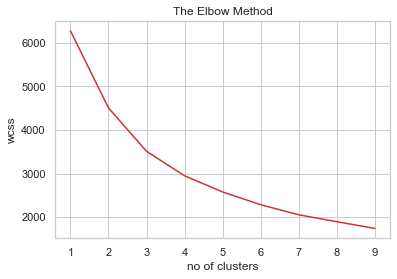

In [805]:
wcss=[]

for i in range(1,10):
    kmeans = KMeans(n_clusters= i, random_state=0)
    kmeans.fit(X_principal)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

#Not very necessary but just to see a glimpse about of cluster choice. basically when there is a step slope change
#(derivative) it could be good choice for n_clusters. we chose it as 4.

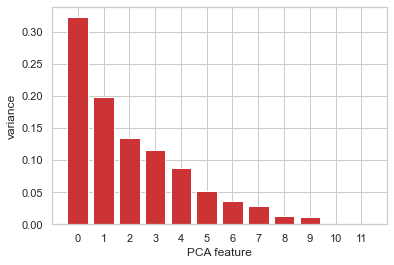

In [806]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(dft_sv_csum0_2019_fc_num)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

#Again 4 looks ok. around ~%80 of variance can explained with 4 components.

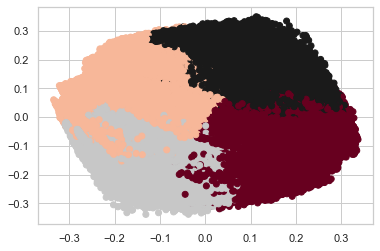

In [807]:
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = KMeans(n_clusters = 4).fit_predict(X_principal), cmap ="RdGy") 
plt.show()

In [808]:
# Create a KMeans model with 4 clusters: model
kmeans = KMeans(n_clusters=4,random_state=0)

# Use fit_predict to fit model and obtain cluster labels: labels
labels = kmeans.fit_predict(X_principal)

In [809]:
# Create a DataFrame with labels and uid as columns: df
df_ct = pd.DataFrame({'cluster_labels': labels, 'User_Id': dft_sv_csum0_2019_fc["User_Id"]})

# Create crosstab: ct
ct = pd.crosstab(df_ct["cluster_labels"],df_ct["User_Id"])

# Display ct
ct/ct.sum()

User_Id         05056DA7-9D4E-4ED7-8C04-A5B1C6559493  \
cluster_labels                                         
0                                           0.098837   
1                                           0.511628   
2                                           0.000000   
3                                           0.389535   

User_Id         061817A6-6D99-424D-809E-2C00AF175AB8  \
cluster_labels                                         
0                                                0.0   
1                                                1.0   
2                                                0.0   
3                                                0.0   

User_Id         068298EF-1F07-4718-B47B-E495247C6947  \
cluster_labels                                         
0                                           0.337868   
1                                           0.000000   
2                                           0.026455   
3                                           0.635676   

User_Id         0943084D-CBF5-4E82-B1B4-1D0235D177C4  \
cluster_labels                                         
0                                           0.194215   
1                                           0.392562   
2                                           0.000000   
3                                           0.413223   

User_Id         0A597706-B8DA-4994-B4F5-C76146454951  \
cluster_labels                                         
0                                           0.000000   
1                                           0.948578   
2                                           0.000000   
3                                           0.051422   

User_Id         14236CAC-AD34-4EDB-AA93-6AA772301C52  \
cluster_labels                                         
0                                           0.000000   
1                                           0.966667   
2                                           0.000000   
3                                           0.033333   

User_Id         152A42EF-A534-43AE-B45B-CEFEEF9C9956  \
cluster_labels                                         
0                                                0.0   
1                                                1.0   
2                                                0.0   
3                                                0.0   

User_Id         15597C07-6169-4BBB-BC57-BCE6DD837C1C  \
cluster_labels                                         
0                                           0.000000   
1                                           0.969237   
2                                           0.000000   
3                                           0.030763   

User_Id         1746596B-884C-4CFD-BBE4-9CA7959567F9  \
cluster_labels                                         
0                                           0.339189   
1                                           0.000000   
2                                           0.256419   
3                                           0.404392   

User_Id         19A57063-45EC-4EE2-A097-6CEFE624879E  ...  \
cluster_labels                                        ...   
0                                           0.304585  ...   
1                                           0.000000  ...   
2                                           0.000000  ...   
3                                           0.695415  ...   

User_Id         F59A27A8-3825-4F53-BE25-E587C848776C  \
cluster_labels                                         
0                                           0.000000   
1                                           0.916667   
2                                           0.000000   
3                                           0.083333   

User_Id         F837CC34-2629-488C-86A7-8E28EC5AB080  \
cluster_labels                                         
0                                           0.000000   
1                                           0.913462   
2                                      

***Here is the result for 0-1 hr year=2019 with model t1441.***

In [810]:
res_060_t1441=all_tests[["t1441","t1441p"]].sort_values("t1441")
res_060_t1441

#Here is the result for 0-1 hr year=2019 with model t1441. Let's do same steps for 30min and 15min and 10 min

t1441    t1441p
User_Id                                              
f8463a83-c38a-4494-a841-d0e033291ddf      0  0.440909
5235F400-C91A-4CED-9D8F-41BE1D2F5B43      1  1.000000
53D66313-30D0-4953-A67F-86233E4B40C1      1  1.000000
56EC977C-786D-42CB-A371-41F2841FEE13      1  0.517115
5EC1864B-1E20-4A11-B927-CA523DB100C9      1  0.653300
650C3A61-736A-4DF2-930E-571235BEDB21      1  0.950000
6682B7E3-4704-4C99-AFB2-7965390336D5      1  1.000000
f445fc9b-98e3-4026-b00e-a98c541f81df      1  0.984293
70b800d8-d80f-4f6c-821b-30e8779d6070      1  0.617978
712044DF-CC59-4BBB-9D9B-7C889582EF58      1  0.532600
76c344f9-239f-45dd-b698-736ddd293cac      1  0.962963
4F04117B-11D9-4E17-983F-22166E1EFA5B      1  0.415094
7BAB33E6-C765-4AF7-A068-6C54FE272498      1  0.595745
83197018-C350-440B-9F07-EAEE57B45842      1  0.543511
8E113ECD-EFA0-448F-A9FB-6634AE9032C5      1  0.944622
E01A870B-AB18-43C9-B8D2-CDD63DD16AA1      1  0.403276
F2928023-0755-4401-AA18-CEFDD663A784      1  0.896197
F59A27A8-3825-4F53-BE25-E587C848776C      1  0.916667
F837CC34-2629-488C-86A7-8E28EC5AB080      1  0.913462
FE928369-8C1C-4D31-85C6-E132A134C0C6      1  0.480620
FF571F23-A909-40AA-ADD3-704585B150D6      1  0.854118
a79aa86e-bebe-4038-bc19-1aa06e5b8f1f      1  0.996960
d0dc14f3-181c-4a06-8125-ac30a93fa495      1  0.630769
82905E4B-F017-49BD-AE6B-ADC75CCD3797      1  1.000000
47B1C4A3-173C-42F7-B8CB-4E05F18E739A      1  1.000000
05056DA7-9D4E-4ED7-8C04-A5B1C6559493      1  0.511628
1CDBFA8B-059A-4A53-BF8F-72F0D97A4FF3      1  0.748705
061817A6-6D99-424D-809E-2C00AF175AB8      1  1.000000
0A597706-B8DA-4994-B4F5-C76146454951      1  0.948578
14236CAC-AD34-4EDB-AA93-6AA772301C52      1  0.966667
152A42EF-A534-43AE-B45B-CEFEEF9C9956      1  1.000000
15597C07-6169-4BBB-BC57-BCE6DD837C1C      1  0.969237
391823DB-EF2F-4FF5-A947-381C5C630453      1  0.481013
209B2018-577C-454A-B904-0B104CBCB1AC      1  0.422422
26C11AB0-1D82-4FB6-B65E-8D5431BE0456      1  0.997783
2838cf7f-a532-4875-a461-c947fbf33696      1  0.622222
E5708F27-7AA7-43E7-92E4-AC7AD8660616      2  0.697722
D797847F-B9C6-4723-883F-C34D22F90C6A      2  0.694466
CDD35C57-F849-47B3-8B63-E52BCAC406BF      2  0.368143
6c564474-bc21-4b15-ad4f-5cb5c16e1c33      2  0.347532
6E748509-98D8-4457-B7DA-092612601352      2  0.461795
6FFA7DFE-47B3-42FC-905B-44854F037F10      2  0.957417
3D25B51C-DB5E-40F1-99CD-D7899B85FA75      2  0.579050
615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF      3  0.622340
CE86C4D5-11F6-4126-8BA2-D12F6A60C5A2      3  0.592573
D476FBE9-8901-4C11-9584-D8829A479ED7      3  0.460552
5d9099a5-a3fc-4f52-b2ae-24d9cce0513c      3  0.452381
D806D2DE-3C33-4136-A9A2-763AFA9B4323      3  0.547826
1746596B-884C-4CFD-BBE4-9CA7959567F9      3  0.404392
5784D6B8-7DE8-4BCD-B24E-791A873364DD      3  0.596154
6bfc1278-aa2c-41af-bc2a-4bfe454b6e5a      3  0.641509
3C30B069-C240-43A8-A095-7C1E96411CE6      3  0.577652
3DD8E606-1312-4960-94CE-A2A18B1A13CE      3  0.634146
FF05F037-15DC-4D31-92C4-06FB01DAF5FC      3  0.465909
0943084D-CBF5-4E82-B1B4-1D0235D177C4      3  0.413223
068298EF-1F07-4718-B47B-E495247C6947      3  0.635676
4EF9609D-DEBE-45CE-88CE-DA12F14092A2      3  0.717791
de668efc-f18a-4f1b-ae4b-ddbebf58006e      3  0.647059
C2155859-DE21-4901-AEEE-EEDE6EC3E40A      3  0.674699
3C2CC3D4-36AD-493C-AEC2-1034CED6517C      3  0.601399
AF110C73-5378-4EC3-AB27-AECC36A74ADA      3  0.680180
9F998895-3467-4021-B34A-4D38F58956F9      3  0.665441
2A1A028F-ACA1-403E-A6B9-F17C9EA01721      3  0.408840
70017663-AEB6-45BF-9079-FFCFD89951D4      3  0.491319
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5      3  0.600000
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0      3  0.544118
362C7373-DC3D-40D1-9DDC-1554D11F16DB      3  0.534694
7157EA9B-3F89-4612-AABE-03616D6A6914      3  0.691358
715C3F69-91F7-4A9D-85E0-F1765AE7574F      3  0.513138
21B66374-DCE1-47F0-B37A-4C718D42AA37      3  0.327279
213d6c4c-0f4f-467c-86dd-eaea0cb851e5      3  0.583333
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665      3  0.570449
3e73d6d9-8cfd-4c23-89f8-8058eea97f52      

### Model Investigation - 2

In [811]:
_=dft_sv_csum0_2019_fc_num.columns
dft_sv_csum0_2019_fc_num30=dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:30:00"].loc[:,_]

In [812]:
sqrt_2=dft_sv_csum0_2019_fc_num30.transform(lambda x: np.sqrt(x))
#log_e=dft_sv_csum0_2019_fc_num30.transform(lambda x: np.log(x+1))  ## i check this one also, it doesnt change best model

In [813]:
test_list=[]
for df in (sqrt_2, dft_sv_csum0_2019_fc_num30):  ##
    scaler = StandardScaler() 
    scaled_df = scaler.fit_transform(df)
    for norm in ("l1","l2"):
        normalized_df = normalize(scaled_df,norm)
        normalized_df = pd.DataFrame(normalized_df)
        for nc in (3,4,5):
            pca = PCA(n_components = nc)
            X_principal = pca.fit_transform(normalized_df)
            X_principal = pd.DataFrame(X_principal)
            for ncl in (4,5):
                kmeans = KMeans(n_clusters=ncl,random_state=0)
                labels = kmeans.fit_predict(X_principal)
                df_ct = pd.DataFrame({'cluster_labels': labels, 'User_Id': dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:30:00"]["User_Id"]})
                ct = pd.crosstab(df_ct["cluster_labels"],df_ct["User_Id"])
                _=pd.DataFrame(data={"most_density":(ct/ct.sum()).idxmax(),"cl_percentage":(ct/ct.sum()).max(axis=0)})
                test_list.append(_)

In [814]:
all_tests=pd.concat(test_list,axis=1)
all_tests.columns=["t0431","t0431p","t0531","t0531p","t0441","t0441p","t0541","t0541p","t0451","t0451p","t0551","t0551p",
                  "t0432","t0432p","t0532","t0532p","t0442","t0442p","t0542","t0542p","t0452","t0452p","t0552","t0552p",
                  "t1431","t1431p","t1531","t1531p","t1441","t1441p","t1541","t1541p","t1451","t1451p","t1551","t1551p",
                  "t1432","t1432p","t1532","t1532p","t1442","t1442p","t1542","t1542p","t1452","t1452p","t1552","t1552p"]
all_tests

t0431    t0431p  t0531    t0531p  t0441  \
User_Id                                                                         
05056DA7-9D4E-4ED7-8C04-A5B1C6559493      1  0.830645      4  0.677419      0   
061817A6-6D99-424D-809E-2C00AF175AB8      2  0.764706      1  0.764706      0   
068298EF-1F07-4718-B47B-E495247C6947      3  0.707657      2  0.602088      2   
0943084D-CBF5-4E82-B1B4-1D0235D177C4      1  0.719101      4  0.511236      0   
0A597706-B8DA-4994-B4F5-C76146454951      2  0.576159      1  0.654893      0   
14236CAC-AD34-4EDB-AA93-6AA772301C52      1  0.625000      1  0.500000      0   
152A42EF-A534-43AE-B45B-CEFEEF9C9956      1  0.750000      1  0.583333      0   
15597C07-6169-4BBB-BC57-BCE6DD837C1C      1  0.555717      1  0.554748      0   
1746596B-884C-4CFD-BBE4-9CA7959567F9      0  0.545717      0  0.481713      3   
19A57063-45EC-4EE2-A097-6CEFE624879E      3  0.786284      2  0.677831      2   
1CDBFA8B-059A-4A53-BF8F-72F0D97A4FF3      1  0.485149      1  0.584158      0   
209B2018-577C-454A-B904-0B104CBCB1AC      1  0.655473      4  0.558458      0   
213d6c4c-0f4f-467c-86dd-eaea0cb851e5      1  0.823529      4  0.705882      0   
21B66374-DCE1-47F0-B37A-4C718D42AA37      2  0.387158      1  0.309254      1   
26C11AB0-1D82-4FB6-B65E-8D5431BE0456      2  0.509284      1  0.656499      0   
2838cf7f-a532-4875-a461-c947fbf33696      1  0.718447      4  0.582524      0   
2A1A028F-ACA1-403E-A6B9-F17C9EA01721      2  0.411765      1  0.455882      1   
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0      3  0.639713      2  0.577277      2   
362C7373-DC3D-40D1-9DDC-1554D11F16DB      1  0.369748      2  0.394958      2   
391823DB-EF2F-4FF5-A947-381C5C630453      1  0.501661      1  0.501661      1   
3C2CC3D4-36AD-493C-AEC2-1034CED6517C      3  0.666667      2  0.696970      2   
3C30B069-C240-43A8-A095-7C1E96411CE6      3  0.505945      2  0.475561      2   
3D25B51C-DB5E-40F1-99CD-D7899B85FA75      0  0.664200      0  0.605708      3   
3DD8E606-1312-4960-94CE-A2A18B1A13CE      1  0.629630      1  0.481481      1   
3F131DD5-6EE9-4C87-B252-C945B008CDE3      1  0.777778      4  0.777778      0   
3e73d6d9-8cfd-4c23-89f8-8058eea97f52      1  0.548023      1  0.485876      1   
47B1C4A3-173C-42F7-B8CB-4E05F18E739A      2  1.000000      1  1.000000      1   
4EF9609D-DEBE-45CE-88CE-DA12F14092A2      1  0.469841      4  0.394709      2   
4F04117B-11D9-4E17-983F-22166E1EFA5B      1  0.710145      4  0.652174      0   
5235F400-C91A-4CED-9D8F-41BE1D2F5B43      2  0.565217      1  0.913043      0   
53D66313-30D0-4953-A67F-86233E4B40C1      2  0.818182      1  0.818182      0   
56EC977C-786D-42CB-A371-41F2841FEE13      2  0.473101      1  0.544304      1   
5784D6B8-7DE8-4BCD-B24E-791A873364DD      3  0.605263      2  0.631579      2   
5EC1864B-1E20-4A11-B927-CA523DB100C9      1  0.713443      4  0.588443      0   
5d9099a5-a3fc-4f52-b2ae-24d9cce0513c      1  0.471264      2  0.390805      2   
615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF      1  0.610169      4  0.525424      1   
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665      2  0.342067      2  0.293304      2   
650C3A61-736A-4DF2-930E-571235BEDB21      1  0.724206      4  0.535714      0   
6682B7E3-4704-4C99-AFB2-7965390336D5      2  0.562500      1  0.625000      0   
6E748509-98D8-4457-B7DA-092612601352      3  0.418191      3  0.399373      3   
6FFA7DFE-47B3-42FC-905B-44854F037F10      3  0.575144      3  0.447146      3   
6bfc1278-aa2c-41af-bc2a-4bfe454b6e5a      3  0.794872      2  0.794872      2   
6c564474-bc21-4b15-ad4f-5cb5c16e1c33      3  0.444694      3  0.377878      3   
70017663-AEB6-45BF-9079-FFCFD89951D4      1  0.584431      4  0.513772      0   
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5      3  0.735294      2  0.735294      2   
70b800d8-d80f-4f6c-821b-30e8779d6070      1  0.655000      4  0.445000      0   
712044DF-CC59-4BBB-9D9B-7C889582EF58      1  0.631966      4  0.541535      0   
7157EA9B-3F89-4612-AABE-03616D6A6914      1  0.617647      4  0.55147

In [815]:
all_weights=dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:30:00"]["User_Id"].value_counts(normalize=True)
all_weights

6FFA7DFE-47B3-42FC-905B-44854F037F10    0.057045
3D25B51C-DB5E-40F1-99CD-D7899B85FA75    0.054676
D797847F-B9C6-4723-883F-C34D22F90C6A    0.052345
E5708F27-7AA7-43E7-92E4-AC7AD8660616    0.047316
21B66374-DCE1-47F0-B37A-4C718D42AA37    0.040805
1746596B-884C-4CFD-BBE4-9CA7959567F9    0.040034
15597C07-6169-4BBB-BC57-BCE6DD837C1C    0.039764
6E748509-98D8-4457-B7DA-092612601352    0.036855
6c564474-bc21-4b15-ad4f-5cb5c16e1c33    0.034312
D476FBE9-8901-4C11-9584-D8829A479ED7    0.034177
CDD35C57-F849-47B3-8B63-E52BCAC406BF    0.033676
8E113ECD-EFA0-448F-A9FB-6634AE9032C5    0.028070
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665    0.026471
0A597706-B8DA-4994-B4F5-C76146454951    0.026182
CE86C4D5-11F6-4126-8BA2-D12F6A60C5A2    0.026124
AF110C73-5378-4EC3-AB27-AECC36A74ADA    0.019728
E01A870B-AB18-43C9-B8D2-CDD63DD16AA1    0.019111
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0    0.018822
712044DF-CC59-4BBB-9D9B-7C889582EF58    0.018322
4EF9609D-DEBE-45CE-88CE-DA12F14092A2    0.018206
FF571F23-A909-40AA-A

In [816]:
_=all_tests.merge(all_weights,left_on=all_tests.index,right_on=all_weights.index,copy=False)
all_tests=_.rename(columns={"key_0":"User_Id","User_Id":"uid_weight"})
all_tests.set_index("User_Id",inplace=True)

In [817]:
meval_df=pd.DataFrame(
    data={"weighted_sum_model":all_tests.iloc[:,np.arange(1,48,2)].multiply(all_tests.iloc[:,-1],axis=0).sum(),
   "sum_model":all_tests.iloc[:,np.arange(1,48,2)].sum()})
meval_df

weighted_sum_model  sum_model
t0431p            0.549262  47.340227
t0531p            0.493199  43.772151
t0441p            0.584326  48.351236
t0541p            0.589970  50.366507
t0451p            0.556930  46.665998
t0551p            0.568797  48.319147
t0432p            0.543637  46.652283
t0532p            0.488614  43.533320
t0442p            0.569472  46.504991
t0542p            0.566331  48.261714
t0452p            0.555523  46.528849
t0552p            0.490887  43.761912
t1431p            0.550630  47.897889
t1531p            0.509286  44.594900
t1441p            0.631719  51.797978
t1541p            0.558702  47.234859
t1451p            0.629291  51.746691
t1551p            0.540169  45.516074
t1432p            0.541883  47.477036
t1532p            0.499942  44.237882
t1442p            0.579162  49.725057
t1542p            0.556737  46.868155
t1452p            0.544003  47.372208
t1552p            0.539398  45.359963

In [818]:
meval_df.sort_values(by=["weighted_sum_model","sum_model"],ascending=False)

#From our evaluation, winner model is t1441p again. t1441p and t1451p has nearly same weighted_sum_model, just the sum_model
#part is slightly different.

weighted_sum_model  sum_model
t1441p            0.631719  51.797978
t1451p            0.629291  51.746691
t0541p            0.589970  50.366507
t0441p            0.584326  48.351236
t1442p            0.579162  49.725057
t0442p            0.569472  46.504991
t0551p            0.568797  48.319147
t0542p            0.566331  48.261714
t1541p            0.558702  47.234859
t0451p            0.556930  46.665998
t1542p            0.556737  46.868155
t0452p            0.555523  46.528849
t1431p            0.550630  47.897889
t0431p            0.549262  47.340227
t1452p            0.544003  47.372208
t0432p            0.543637  46.652283
t1432p            0.541883  47.477036
t1551p            0.540169  45.516074
t1552p            0.539398  45.359963
t1531p            0.509286  44.594900
t1532p            0.499942  44.237882
t0531p            0.493199  43.772151
t0552p            0.490887  43.761912
t0532p            0.488614  43.533320

***Here is the model t1441 (dft_sv_csum0_2019_fc_num, 4 cluster, pca n_components=4 and l1 regularization(lasso))***

In [819]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(dft_sv_csum0_2019_fc_num30)   ##
  
# Normalizing the Data 
normalized_df = normalize(scaled_df,norm="l1") 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 4) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2',"P3","P4"]

X_principal.head()

P1        P2        P3        P4
0 -0.028824 -0.236069  0.131606 -0.120919
1 -0.143726 -0.249277  0.056677 -0.167140
2 -0.204544 -0.067832  0.124912 -0.130692
3 -0.251654 -0.085004 -0.027071 -0.131442
4 -0.253402 -0.073653 -0.048752 -0.124233

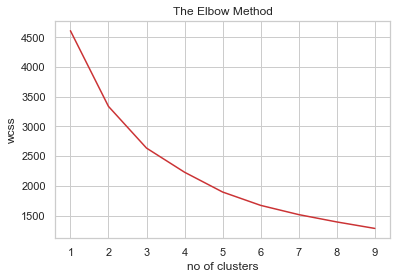

In [820]:
wcss=[]

for i in range(1,10):
    kmeans = KMeans(n_clusters= i, random_state=0)
    kmeans.fit(X_principal)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

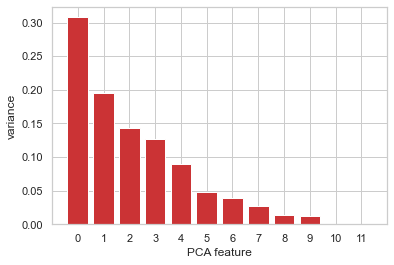

In [821]:
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(dft_sv_csum0_2019_fc_num30)  ##

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

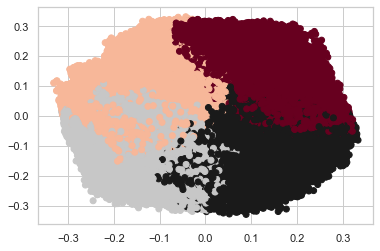

In [822]:
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = KMeans(n_clusters = 4).fit_predict(X_principal), cmap ="RdGy") 
plt.show()

In [823]:
# Create a DataFrame with labels and varieties as columns: df
df_ct = pd.DataFrame({'cluster_labels': labels, 
                      'User_Id': dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:30:00"]["User_Id"]}) ##

# Create crosstab: ct
ct = pd.crosstab(df_ct["cluster_labels"],df_ct["User_Id"])

# Display ct
ct/ct.sum()

User_Id         05056DA7-9D4E-4ED7-8C04-A5B1C6559493  \
cluster_labels                                         
0                                           0.419355   
1                                           0.411290   
2                                           0.000000   
3                                           0.169355   
4                                           0.000000   

User_Id         061817A6-6D99-424D-809E-2C00AF175AB8  \
cluster_labels                                         
0                                                0.0   
1                                                1.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

User_Id         068298EF-1F07-4718-B47B-E495247C6947  \
cluster_labels                                         
0                                           0.093968   
1                                           0.000000   
2                                           0.127610   
3                                           0.476798   
4                                           0.301624   

User_Id         0943084D-CBF5-4E82-B1B4-1D0235D177C4  \
cluster_labels                                         
0                                           0.269663   
1                                           0.488764   
2                                           0.000000   
3                                           0.241573   
4                                           0.000000   

User_Id         0A597706-B8DA-4994-B4F5-C76146454951  \
cluster_labels                                         
0                                           0.175865   
1                                           0.775570   
2                                           0.000000   
3                                           0.048565   
4                                           0.000000   

User_Id         14236CAC-AD34-4EDB-AA93-6AA772301C52  \
cluster_labels                                         
0                                           0.145833   
1                                           0.770833   
2                                           0.000000   
3                                           0.083333   
4                                           0.000000   

User_Id         152A42EF-A534-43AE-B45B-CEFEEF9C9956  \
cluster_labels                                         
0                                           0.166667   
1                                           0.750000   
2                                           0.000000   
3                                           0.083333   
4                                           0.000000   

User_Id         15597C07-6169-4BBB-BC57-BCE6DD837C1C  \
cluster_labels                                         
0                                           0.210756   
1                                           0.763566   
2                                           0.000000   
3                                           0.025678   
4                                           0.000000   

User_Id         1746596B-884C-4CFD-BBE4-9CA7959567F9  \
cluster_labels                                         
0                                           0.212705   
1                                           0.000000   
2                                           0.194899   
3                                           0.183349   
4                                           0.409047   

User_Id         19A57063-45EC-4EE2-A097-6CEFE624879E  ...  \
cluster_labels                                        ...   
0                                           0.062201  ...   
1                                           0.000000  ...   
2                                           0.006380  ...   
3                                           0.625199  ...   
4                                           0.306220  ...   

User_Id         F59A27A8-3825-4F53-

In [824]:
res_030_t1441=all_tests[["t1441","t1441p"]].sort_values("t1441")
res_030_t1441

t1441    t1441p
User_Id                                              
05056DA7-9D4E-4ED7-8C04-A5B1C6559493      0  0.467742
3C2CC3D4-36AD-493C-AEC2-1034CED6517C      0  0.626263
3C30B069-C240-43A8-A095-7C1E96411CE6      0  0.520476
8E967BB3-13A9-4E39-96A8-C8DFCDD37FC3      0  0.566667
3DD8E606-1312-4960-94CE-A2A18B1A13CE      0  0.518519
3F131DD5-6EE9-4C87-B252-C945B008CDE3      0  0.777778
841B13B7-7F61-40ED-81BB-70E719D18D22      0  0.622419
9E52DA09-CF46-4888-A348-C9A9C3487B5C      0  0.491463
715C3F69-91F7-4A9D-85E0-F1765AE7574F      0  0.533613
4F04117B-11D9-4E17-983F-22166E1EFA5B      0  0.405797
7157EA9B-3F89-4612-AABE-03616D6A6914      0  0.650735
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5      0  0.617647
70017663-AEB6-45BF-9079-FFCFD89951D4      0  0.487425
5784D6B8-7DE8-4BCD-B24E-791A873364DD      0  0.605263
6bfc1278-aa2c-41af-bc2a-4bfe454b6e5a      0  0.692308
4EF9609D-DEBE-45CE-88CE-DA12F14092A2      0  0.649735
362C7373-DC3D-40D1-9DDC-1554D11F16DB      0  0.571429
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0      0  0.520983
2A1A028F-ACA1-403E-A6B9-F17C9EA01721      0  0.407353
de668efc-f18a-4f1b-ae4b-ddbebf58006e      0  0.683453
068298EF-1F07-4718-B47B-E495247C6947      0  0.566125
0943084D-CBF5-4E82-B1B4-1D0235D177C4      0  0.415730
FF05F037-15DC-4D31-92C4-06FB01DAF5FC      0  0.512116
D806D2DE-3C33-4136-A9A2-763AFA9B4323      0  0.562347
D476FBE9-8901-4C11-9584-D8829A479ED7      0  0.453213
CE86C4D5-11F6-4126-8BA2-D12F6A60C5A2      0  0.533186
C2155859-DE21-4901-AEEE-EEDE6EC3E40A      0  0.559633
19A57063-45EC-4EE2-A097-6CEFE624879E      0  0.645933
AF110C73-5378-4EC3-AB27-AECC36A74ADA      0  0.635742
209B2018-577C-454A-B904-0B104CBCB1AC      0  0.416667
213d6c4c-0f4f-467c-86dd-eaea0cb851e5      0  0.529412
21B66374-DCE1-47F0-B37A-4C718D42AA37      0  0.389991
A1F2984A-1E6C-4F3E-9D6B-4405C4DB9700      0  0.548077
9F998895-3467-4021-B34A-4D38F58956F9      0  0.634349
5d9099a5-a3fc-4f52-b2ae-24d9cce0513c      0  0.528736
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665      0  0.526201
f8463a83-c38a-4494-a841-d0e033291ddf      1  0.515152
615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF      1  0.516949
3e73d6d9-8cfd-4c23-89f8-8058eea97f52      1  0.553672
1746596B-884C-4CFD-BBE4-9CA7959567F9      1  0.390279
1CDBFA8B-059A-4A53-BF8F-72F0D97A4FF3      2  0.841584
15597C07-6169-4BBB-BC57-BCE6DD837C1C      2  0.972868
152A42EF-A534-43AE-B45B-CEFEEF9C9956      2  1.000000
14236CAC-AD34-4EDB-AA93-6AA772301C52      2  0.958333
E01A870B-AB18-43C9-B8D2-CDD63DD16AA1      2  0.378024
26C11AB0-1D82-4FB6-B65E-8D5431BE0456      2  0.994695
650C3A61-736A-4DF2-930E-571235BEDB21      2  0.934524
F837CC34-2629-488C-86A7-8E28EC5AB080      2  0.872093
FE928369-8C1C-4D31-85C6-E132A134C0C6      2  0.455446
0A597706-B8DA-4994-B4F5-C76146454951      2  0.949963
FF571F23-A909-40AA-ADD3-704585B150D6      2  0.835320
a79aa86e-bebe-4038-bc19-1aa06e5b8f1f      2  0.996575
d0dc14f3-181c-4a06-8125-ac30a93fa495      2  0.595745
061817A6-6D99-424D-809E-2C00AF175AB8      2  1.000000
F59A27A8-3825-4F53-BE25-E587C848776C      2  0.800000
F2928023-0755-4401-AA18-CEFDD663A784      2  0.892807
2838cf7f-a532-4875-a461-c947fbf33696      2  0.495146
47B1C4A3-173C-42F7-B8CB-4E05F18E739A      2  1.000000
56EC977C-786D-42CB-A371-41F2841FEE13      2  0.523734
53D66313-30D0-4953-A67F-86233E4B40C1      2  1.000000
70b800d8-d80f-4f6c-821b-30e8779d6070      2  0.615000
712044DF-CC59-4BBB-9D9B-7C889582EF58      2  0.411146
391823DB-EF2F-4FF5-A947-381C5C630453      2  0.485050
5235F400-C91A-4CED-9D8F-41BE1D2F5B43      2  1.000000
5EC1864B-1E20-4A11-B927-CA523DB100C9      2  0.582547
76c344f9-239f-45dd-b698-736ddd293cac      2  0.952381
7BAB33E6-C765-4AF7-A068-6C54FE272498      2  0.550725
6682B7E3-4704-4C99-AFB2-7965390336D5      2  1.000000
82905E4B-F017-49BD-AE6B-ADC75CCD3797      2  1.000000
83197018-C350-440B-9F07-EAEE57B45842      2  0.427126
8E113ECD-EFA0-448F-A9FB-6634AE9032C5      2  0.932052
f445fc9b-98e3-4026-b00e-a98c541f81df      2  0.995902
6FFA7DFE-47B3-42FC-905B-44854F037F10      

### Model Investigation - 3

In [825]:
_=dft_sv_csum0_2019_fc_num.columns
dft_sv_csum0_2019_fc_num15=dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:15:00"].loc[:,_]

In [826]:
sqrt_2=dft_sv_csum0_2019_fc_num15.transform(lambda x: np.sqrt(x))
#log_e=dft_sv_csum0_2019_fc_num15.transform(lambda x: np.log(x+1))  ## i check this one also, it doesnt change best model

In [827]:
test_list=[]
for df in (sqrt_2, dft_sv_csum0_2019_fc_num15):  ##
    scaler = StandardScaler() 
    scaled_df = scaler.fit_transform(df)
    for norm in ("l1","l2"):
        normalized_df = normalize(scaled_df,norm)
        normalized_df = pd.DataFrame(normalized_df)
        for nc in (3,4,5):
            pca = PCA(n_components = nc)
            X_principal = pca.fit_transform(normalized_df)
            X_principal = pd.DataFrame(X_principal)
            for ncl in (4,5):
                kmeans = KMeans(n_clusters=ncl,random_state=0)
                labels = kmeans.fit_predict(X_principal)
                df_ct = pd.DataFrame({'cluster_labels': labels, 'User_Id': dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:15:00"]["User_Id"]})
                ct = pd.crosstab(df_ct["cluster_labels"],df_ct["User_Id"])
                _=pd.DataFrame(data={"most_density":(ct/ct.sum()).idxmax(),"cl_percentage":(ct/ct.sum()).max(axis=0)})
                test_list.append(_)

In [828]:
all_tests=pd.concat(test_list,axis=1)
all_tests.columns=["t0431","t0431p","t0531","t0531p","t0441","t0441p","t0541","t0541p","t0451","t0451p","t0551","t0551p",
                  "t0432","t0432p","t0532","t0532p","t0442","t0442p","t0542","t0542p","t0452","t0452p","t0552","t0552p",
                  "t1431","t1431p","t1531","t1531p","t1441","t1441p","t1541","t1541p","t1451","t1451p","t1551","t1551p",
                  "t1432","t1432p","t1532","t1532p","t1442","t1442p","t1542","t1542p","t1452","t1452p","t1552","t1552p"]
all_tests

t0431    t0431p  t0531    t0531p  t0441  \
User_Id                                                                         
05056DA7-9D4E-4ED7-8C04-A5B1C6559493      1  0.817204      1  0.688172      3   
061817A6-6D99-424D-809E-2C00AF175AB8      3  0.764706      2  0.764706      2   
068298EF-1F07-4718-B47B-E495247C6947      0  0.828402      4  0.707101      1   
0943084D-CBF5-4E82-B1B4-1D0235D177C4      1  0.653543      1  0.519685      3   
0A597706-B8DA-4994-B4F5-C76146454951      3  0.577759      2  0.642140      2   
14236CAC-AD34-4EDB-AA93-6AA772301C52      1  0.615385      1  0.512821      3   
152A42EF-A534-43AE-B45B-CEFEEF9C9956      1  0.800000      1  0.500000      3   
15597C07-6169-4BBB-BC57-BCE6DD837C1C      1  0.568925      2  0.511098      3   
1746596B-884C-4CFD-BBE4-9CA7959567F9      2  0.503166      3  0.465170      0   
19A57063-45EC-4EE2-A097-6CEFE624879E      0  0.812352      4  0.679335      1   
1CDBFA8B-059A-4A53-BF8F-72F0D97A4FF3      3  0.484375      2  0.550781      2   
209B2018-577C-454A-B904-0B104CBCB1AC      1  0.625402      1  0.562701      3   
213d6c4c-0f4f-467c-86dd-eaea0cb851e5      1  0.916667      1  0.750000      3   
21B66374-DCE1-47F0-B37A-4C718D42AA37      3  0.366061      3  0.283030      2   
26C11AB0-1D82-4FB6-B65E-8D5431BE0456      3  0.530612      2  0.637363      3   
2838cf7f-a532-4875-a461-c947fbf33696      1  0.712644      1  0.632184      3   
2A1A028F-ACA1-403E-A6B9-F17C9EA01721      3  0.436647      2  0.483431      2   
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0      0  0.620370      4  0.547840      1   
362C7373-DC3D-40D1-9DDC-1554D11F16DB      0  0.431507      4  0.500000      1   
391823DB-EF2F-4FF5-A947-381C5C630453      1  0.502092      2  0.489540      2   
3C2CC3D4-36AD-493C-AEC2-1034CED6517C      0  0.594203      4  0.594203      1   
3C30B069-C240-43A8-A095-7C1E96411CE6      0  0.586583      4  0.561622      1   
3D25B51C-DB5E-40F1-99CD-D7899B85FA75      2  0.726145      3  0.691485      0   
3DD8E606-1312-4960-94CE-A2A18B1A13CE      1  0.545455      2  0.454545      2   
3F131DD5-6EE9-4C87-B252-C945B008CDE3      1  0.777778      1  0.777778      3   
3e73d6d9-8cfd-4c23-89f8-8058eea97f52      1  0.542254      2  0.450704      2   
47B1C4A3-173C-42F7-B8CB-4E05F18E739A      3  1.000000      2  1.000000      2   
4EF9609D-DEBE-45CE-88CE-DA12F14092A2      1  0.326687      1  0.348160      3   
4F04117B-11D9-4E17-983F-22166E1EFA5B      1  0.688525      1  0.573770      3   
5235F400-C91A-4CED-9D8F-41BE1D2F5B43      3  0.600000      2  0.850000      3   
53D66313-30D0-4953-A67F-86233E4B40C1      3  0.818182      2  0.818182      3   
56EC977C-786D-42CB-A371-41F2841FEE13      3  0.472169      2  0.531670      2   
5784D6B8-7DE8-4BCD-B24E-791A873364DD      0  0.551724      4  0.620690      1   
5EC1864B-1E20-4A11-B927-CA523DB100C9      1  0.713663      1  0.651163      3   
5d9099a5-a3fc-4f52-b2ae-24d9cce0513c      1  0.419355      4  0.370968      1   
615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF      1  0.537634      1  0.505376      2   
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665      0  0.339336      4  0.328910      1   
650C3A61-736A-4DF2-930E-571235BEDB21      1  0.693046      1  0.597122      3   
6682B7E3-4704-4C99-AFB2-7965390336D5      3  0.562500      2  0.625000      2   
6E748509-98D8-4457-B7DA-092612601352      0  0.605381      4  0.446509      0   
6FFA7DFE-47B3-42FC-905B-44854F037F10      0  0.734037      0  0.449975      0   
6bfc1278-aa2c-41af-bc2a-4bfe454b6e5a      0  0.666667      4  0.666667      1   
6c564474-bc21-4b15-ad4f-5cb5c16e1c33      0  0.561391      4  0.428994      0   
70017663-AEB6-45BF-9079-FFCFD89951D4      1  0.553161      1  0.515805      3   
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5      0  0.619048      4  0.714286      1   
70b800d8-d80f-4f6c-821b-30e8779d6070      1  0.609929      2  0.404255      3   
712044DF-CC59-4BBB-9D9B-7C889582EF58      1  0.646684      1  0.581633      3   
7157EA9B-3F89-4612-AABE-03616D6A6914      1  0.579208      1  0.52970

In [829]:
all_weights=dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:15:00"]["User_Id"].value_counts(normalize=True)
all_weights

3D25B51C-DB5E-40F1-99CD-D7899B85FA75    0.057434
D797847F-B9C6-4723-883F-C34D22F90C6A    0.052667
6FFA7DFE-47B3-42FC-905B-44854F037F10    0.048882
E5708F27-7AA7-43E7-92E4-AC7AD8660616    0.044089
1746596B-884C-4CFD-BBE4-9CA7959567F9    0.042689
15597C07-6169-4BBB-BC57-BCE6DD837C1C    0.042074
21B66374-DCE1-47F0-B37A-4C718D42AA37    0.040551
6E748509-98D8-4457-B7DA-092612601352    0.038363
D476FBE9-8901-4C11-9584-D8829A479ED7    0.036618
CDD35C57-F849-47B3-8B63-E52BCAC406BF    0.033743
6c564474-bc21-4b15-ad4f-5cb5c16e1c33    0.033227
8E113ECD-EFA0-448F-A9FB-6634AE9032C5    0.029762
0A597706-B8DA-4994-B4F5-C76146454951    0.029393
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665    0.025928
CE86C4D5-11F6-4126-8BA2-D12F6A60C5A2    0.025141
E01A870B-AB18-43C9-B8D2-CDD63DD16AA1    0.020374
712044DF-CC59-4BBB-9D9B-7C889582EF58    0.019268
FF571F23-A909-40AA-ADD3-704585B150D6    0.017326
70017663-AEB6-45BF-9079-FFCFD89951D4    0.017105
5EC1864B-1E20-4A11-B927-CA523DB100C9    0.016908
068298EF-1F07-4718-B

In [830]:
_=all_tests.merge(all_weights,left_on=all_tests.index,right_on=all_weights.index,copy=False)
all_tests=_.rename(columns={"key_0":"User_Id","User_Id":"uid_weight"})
all_tests.set_index("User_Id",inplace=True)

In [831]:
meval_df=pd.DataFrame(
    data={"weighted_sum_model":all_tests.iloc[:,np.arange(1,48,2)].multiply(all_tests.iloc[:,-1],axis=0).sum(),
   "sum_model":all_tests.iloc[:,np.arange(1,48,2)].sum()})
meval_df

weighted_sum_model  sum_model
t0431p            0.578570  47.388917
t0531p            0.514156  44.478720
t0441p            0.569378  46.142482
t0541p            0.551954  47.392553
t0451p            0.563701  45.671961
t0551p            0.547137  46.429326
t0432p            0.578471  47.118463
t0532p            0.510519  44.292180
t0442p            0.572843  46.137526
t0542p            0.544728  46.638842
t0452p            0.564389  45.527711
t0552p            0.540231  45.701043
t1431p            0.552494  47.513412
t1531p            0.522782  45.027695
t1441p            0.626321  51.073754
t1541p            0.555100  47.404569
t1451p            0.625240  51.054543
t1551p            0.544655  46.533801
t1432p            0.542713  47.161051
t1532p            0.514524  44.374424
t1442p            0.572917  48.839106
t1542p            0.544679  46.633486
t1452p            0.563578  48.327304
t1552p            0.534972  45.707800

In [832]:
meval_df.sort_values(by=["weighted_sum_model","sum_model"],ascending=False)

#From our evaluation winner model is t1441p. t1441p and t1451p has nearly same weighted_sum_model, just the sum_model part is
#slightly different.

weighted_sum_model  sum_model
t1441p            0.626321  51.073754
t1451p            0.625240  51.054543
t0431p            0.578570  47.388917
t0432p            0.578471  47.118463
t1442p            0.572917  48.839106
t0442p            0.572843  46.137526
t0441p            0.569378  46.142482
t0452p            0.564389  45.527711
t0451p            0.563701  45.671961
t1452p            0.563578  48.327304
t1541p            0.555100  47.404569
t1431p            0.552494  47.513412
t0541p            0.551954  47.392553
t0551p            0.547137  46.429326
t0542p            0.544728  46.638842
t1542p            0.544679  46.633486
t1551p            0.544655  46.533801
t1432p            0.542713  47.161051
t0552p            0.540231  45.701043
t1552p            0.534972  45.707800
t1531p            0.522782  45.027695
t1532p            0.514524  44.374424
t0531p            0.514156  44.478720
t0532p            0.510519  44.292180

***Here is the model t1441 (dft_sv_csum0_2019_fc_num, 4 cluster, pca n_components=4 and l1 regularization(lasso))***

In [833]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(dft_sv_csum0_2019_fc_num15)   ##
  
# Normalizing the Data 
normalized_df = normalize(scaled_df,norm="l1") 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 4) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2',"P3","P4"]

X_principal.head()

P1        P2        P3        P4
0  0.010475 -0.141311  0.202670 -0.105667
1 -0.090377 -0.169332  0.165281 -0.158289
2 -0.255233 -0.076696 -0.020869 -0.141960
3 -0.254324 -0.065234 -0.037406 -0.132064
4  0.091236 -0.218446  0.136170 -0.068514

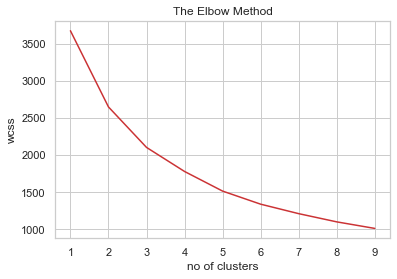

In [834]:
wcss=[]

for i in range(1,10):
    kmeans = KMeans(n_clusters= i, random_state=0)
    kmeans.fit(X_principal)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

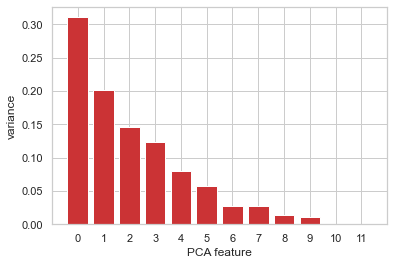

In [835]:
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(dft_sv_csum0_2019_fc_num15)  ##

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

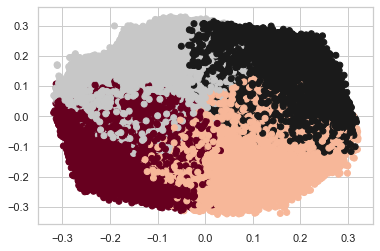

In [836]:
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = KMeans(n_clusters = 4).fit_predict(X_principal), cmap ="RdGy") 
plt.show()

In [837]:
# Create a DataFrame with labels and varieties as columns: df
df_ct = pd.DataFrame({'cluster_labels': labels, 
                      'User_Id': dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:15:00"]["User_Id"]}) ##

# Create crosstab: ct
ct = pd.crosstab(df_ct["cluster_labels"],df_ct["User_Id"])

# Display ct
ct/ct.sum()

User_Id         05056DA7-9D4E-4ED7-8C04-A5B1C6559493  \
cluster_labels                                         
0                                           0.397849   
1                                           0.483871   
2                                           0.118280   
3                                           0.000000   
4                                           0.000000   

User_Id         061817A6-6D99-424D-809E-2C00AF175AB8  \
cluster_labels                                         
0                                           0.941176   
1                                           0.058824   
2                                           0.000000   
3                                           0.000000   
4                                           0.000000   

User_Id         068298EF-1F07-4718-B47B-E495247C6947  \
cluster_labels                                         
0                                           0.000000   
1                                           0.001479   
2                                           0.668639   
3                                           0.276627   
4                                           0.053254   

User_Id         0943084D-CBF5-4E82-B1B4-1D0235D177C4  \
cluster_labels                                         
0                                           0.527559   
1                                           0.377953   
2                                           0.094488   
3                                           0.000000   
4                                           0.000000   

User_Id         0A597706-B8DA-4994-B4F5-C76146454951  \
cluster_labels                                         
0                                           0.729933   
1                                           0.238294   
2                                           0.031773   
3                                           0.000000   
4                                           0.000000   

User_Id         14236CAC-AD34-4EDB-AA93-6AA772301C52  \
cluster_labels                                         
0                                           0.743590   
1                                           0.230769   
2                                           0.025641   
3                                           0.000000   
4                                           0.000000   

User_Id         152A42EF-A534-43AE-B45B-CEFEEF9C9956  \
cluster_labels                                         
0                                                0.6   
1                                                0.4   
2                                                0.0   
3                                                0.0   
4                                                0.0   

User_Id         15597C07-6169-4BBB-BC57-BCE6DD837C1C  \
cluster_labels                                         
0                                           0.674650   
1                                           0.316589   
2                                           0.008762   
3                                           0.000000   
4                                           0.000000   

User_Id         1746596B-884C-4CFD-BBE4-9CA7959567F9  \
cluster_labels                                         
0                                           0.000000   
1                                           0.051813   
2                                           0.199770   
3                                           0.397812   
4                                           0.350604   

User_Id         19A57063-45EC-4EE2-A097-6CEFE624879E  ...  \
cluster_labels                                        ...   
0                                            0.00000  ...   
1                                            0.00000  ...   
2                                            0.68171  ...   
3                                            0.31829  ...   
4                                            0.00000  ...   

User_Id         F59A27A8-3825-4F53-

In [838]:
res_015_t1441=all_tests[["t1441","t1441p"]].sort_values("t1441")
res_015_t1441

t1441    t1441p
User_Id                                              
82905E4B-F017-49BD-AE6B-ADC75CCD3797      0  1.000000
53D66313-30D0-4953-A67F-86233E4B40C1      0  1.000000
5235F400-C91A-4CED-9D8F-41BE1D2F5B43      0  1.000000
650C3A61-736A-4DF2-930E-571235BEDB21      0  0.940048
6682B7E3-4704-4C99-AFB2-7965390336D5      0  1.000000
47B1C4A3-173C-42F7-B8CB-4E05F18E739A      0  1.000000
76c344f9-239f-45dd-b698-736ddd293cac      0  0.973451
f445fc9b-98e3-4026-b00e-a98c541f81df      0  0.982843
8E113ECD-EFA0-448F-A9FB-6634AE9032C5      0  0.919075
70b800d8-d80f-4f6c-821b-30e8779d6070      0  0.496454
391823DB-EF2F-4FF5-A947-381C5C630453      0  0.384937
F2928023-0755-4401-AA18-CEFDD663A784      0  0.901024
F59A27A8-3825-4F53-BE25-E587C848776C      0  0.823529
56EC977C-786D-42CB-A371-41F2841FEE13      0  0.418426
2838cf7f-a532-4875-a461-c947fbf33696      0  0.471264
F837CC34-2629-488C-86A7-8E28EC5AB080      0  0.758621
FE928369-8C1C-4D31-85C6-E132A134C0C6      0  0.354430
061817A6-6D99-424D-809E-2C00AF175AB8      0  1.000000
83197018-C350-440B-9F07-EAEE57B45842      0  0.398568
0943084D-CBF5-4E82-B1B4-1D0235D177C4      0  0.362205
0A597706-B8DA-4994-B4F5-C76146454951      0  0.935619
14236CAC-AD34-4EDB-AA93-6AA772301C52      0  0.974359
152A42EF-A534-43AE-B45B-CEFEEF9C9956      0  1.000000
26C11AB0-1D82-4FB6-B65E-8D5431BE0456      0  0.992151
15597C07-6169-4BBB-BC57-BCE6DD837C1C      0  0.974299
d0dc14f3-181c-4a06-8125-ac30a93fa495      0  0.648649
a79aa86e-bebe-4038-bc19-1aa06e5b8f1f      0  0.987288
1CDBFA8B-059A-4A53-BF8F-72F0D97A4FF3      0  0.781250
FF571F23-A909-40AA-ADD3-704585B150D6      0  0.876596
712044DF-CC59-4BBB-9D9B-7C889582EF58      0  0.373724
5EC1864B-1E20-4A11-B927-CA523DB100C9      0  0.597384
6c564474-bc21-4b15-ad4f-5cb5c16e1c33      1  0.419379
6FFA7DFE-47B3-42FC-905B-44854F037F10      1  0.981900
6E748509-98D8-4457-B7DA-092612601352      1  0.534273
3D25B51C-DB5E-40F1-99CD-D7899B85FA75      1  0.572529
CDD35C57-F849-47B3-8B63-E52BCAC406BF      1  0.478514
D797847F-B9C6-4723-883F-C34D22F90C6A      1  0.743350
E5708F27-7AA7-43E7-92E4-AC7AD8660616      1  0.757525
de668efc-f18a-4f1b-ae4b-ddbebf58006e      2  0.695652
841B13B7-7F61-40ED-81BB-70E719D18D22      2  0.647727
FF05F037-15DC-4D31-92C4-06FB01DAF5FC      2  0.509847
E01A870B-AB18-43C9-B8D2-CDD63DD16AA1      2  0.428227
8E967BB3-13A9-4E39-96A8-C8DFCDD37FC3      2  0.590909
AF110C73-5378-4EC3-AB27-AECC36A74ADA      2  0.610698
9E52DA09-CF46-4888-A348-C9A9C3487B5C      2  0.501650
D806D2DE-3C33-4136-A9A2-763AFA9B4323      2  0.593168
CE86C4D5-11F6-4126-8BA2-D12F6A60C5A2      2  0.551320
9F998895-3467-4021-B34A-4D38F58956F9      2  0.646853
A1F2984A-1E6C-4F3E-9D6B-4405C4DB9700      2  0.600000
C2155859-DE21-4901-AEEE-EEDE6EC3E40A      2  0.547619
D476FBE9-8901-4C11-9584-D8829A479ED7      2  0.416779
05056DA7-9D4E-4ED7-8C04-A5B1C6559493      2  0.473118
715C3F69-91F7-4A9D-85E0-F1765AE7574F      2  0.580882
068298EF-1F07-4718-B47B-E495247C6947      2  0.613905
19A57063-45EC-4EE2-A097-6CEFE624879E      2  0.622328
209B2018-577C-454A-B904-0B104CBCB1AC      2  0.393891
213d6c4c-0f4f-467c-86dd-eaea0cb851e5      2  0.625000
21B66374-DCE1-47F0-B37A-4C718D42AA37      2  0.375758
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0      2  0.503086
362C7373-DC3D-40D1-9DDC-1554D11F16DB      2  0.609589
3C2CC3D4-36AD-493C-AEC2-1034CED6517C      2  0.579710
3C30B069-C240-43A8-A095-7C1E96411CE6      2  0.542902
7BAB33E6-C765-4AF7-A068-6C54FE272498      2  0.488889
3F131DD5-6EE9-4C87-B252-C945B008CDE3      2  0.777778
3DD8E606-1312-4960-94CE-A2A18B1A13CE      2  0.500000
4EF9609D-DEBE-45CE-88CE-DA12F14092A2      2  0.625767
4F04117B-11D9-4E17-983F-22166E1EFA5B      2  0.409836
5784D6B8-7DE8-4BCD-B24E-791A873364DD      2  0.620690
5d9099a5-a3fc-4f52-b2ae-24d9cce0513c      2  0.467742
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665      2  0.541232
6bfc1278-aa2c-41af-bc2a-4bfe454b6e5a      2  0.523810
70017663-AEB6-45BF-9079-FFCFD89951D4      2  0.488506
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5      

### Model Investigation - 4

In [839]:
_=dft_sv_csum0_2019_fc_num.columns
dft_sv_csum0_2019_fc_num10=dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:10:00"].loc[:,_]

In [840]:
#sqrt_2=dft_sv_csum0_2019_fc_num10.transform(lambda x: np.sqrt(x))
log_e=dft_sv_csum0_2019_fc_num10.transform(lambda x: np.log(x+1)) 

***For this time range log_e transformation change the result, its better than sqrt transformation.***

In [841]:
test_list=[]
for df in (log_e, dft_sv_csum0_2019_fc_num10):  ##
    scaler = StandardScaler() 
    scaled_df = scaler.fit_transform(df)
    for norm in ("l1","l2"):
        normalized_df = normalize(scaled_df,norm)
        normalized_df = pd.DataFrame(normalized_df)
        for nc in (3,4,5):
            pca = PCA(n_components = nc)
            X_principal = pca.fit_transform(normalized_df)
            X_principal = pd.DataFrame(X_principal)
            for ncl in (4,5):
                kmeans = KMeans(n_clusters=ncl,random_state=0)
                labels = kmeans.fit_predict(X_principal)
                df_ct = pd.DataFrame({'cluster_labels': labels, 'User_Id': dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:10:00"]["User_Id"]})
                ct = pd.crosstab(df_ct["cluster_labels"],df_ct["User_Id"])
                _=pd.DataFrame(data={"most_density":(ct/ct.sum()).idxmax(),"cl_percentage":(ct/ct.sum()).max(axis=0)})
                test_list.append(_)

In [842]:
all_tests=pd.concat(test_list,axis=1)
all_tests.columns=["t0431","t0431p","t0531","t0531p","t0441","t0441p","t0541","t0541p","t0451","t0451p","t0551","t0551p",
                  "t0432","t0432p","t0532","t0532p","t0442","t0442p","t0542","t0542p","t0452","t0452p","t0552","t0552p",
                  "t1431","t1431p","t1531","t1531p","t1441","t1441p","t1541","t1541p","t1451","t1451p","t1551","t1551p",
                  "t1432","t1432p","t1532","t1532p","t1442","t1442p","t1542","t1542p","t1452","t1452p","t1552","t1552p"]
all_tests

t0431    t0431p  t0531    t0531p  t0441  \
User_Id                                                                         
05056DA7-9D4E-4ED7-8C04-A5B1C6559493      3  0.513158      4  0.605263      2   
061817A6-6D99-424D-809E-2C00AF175AB8      3  0.937500      1  0.937500      2   
068298EF-1F07-4718-B47B-E495247C6947      1  0.870637      2  0.823409      1   
0943084D-CBF5-4E82-B1B4-1D0235D177C4      3  0.639640      1  0.387387      2   
0A597706-B8DA-4994-B4F5-C76146454951      0  0.483083      3  0.478383      0   
14236CAC-AD34-4EDB-AA93-6AA772301C52      3  0.848485      1  0.727273      2   
152A42EF-A534-43AE-B45B-CEFEEF9C9956      3  0.875000      1  0.750000      2   
15597C07-6169-4BBB-BC57-BCE6DD837C1C      2  0.498718      4  0.622436      2   
1746596B-884C-4CFD-BBE4-9CA7959567F9      1  0.576348      0  0.381417      1   
19A57063-45EC-4EE2-A097-6CEFE624879E      1  0.822835      2  0.732283      1   
1CDBFA8B-059A-4A53-BF8F-72F0D97A4FF3      3  0.681223      1  0.655022      2   
209B2018-577C-454A-B904-0B104CBCB1AC      2  0.527103      4  0.581308      2   
213d6c4c-0f4f-467c-86dd-eaea0cb851e5      3  0.913043      1  0.521739      2   
21B66374-DCE1-47F0-B37A-4C718D42AA37      2  0.435808      0  0.339348      3   
26C11AB0-1D82-4FB6-B65E-8D5431BE0456      3  0.538732      3  0.477113      2   
2838cf7f-a532-4875-a461-c947fbf33696      3  0.710843      1  0.397590      2   
2A1A028F-ACA1-403E-A6B9-F17C9EA01721      3  0.469287      1  0.444717      0   
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0      1  0.621924      2  0.581655      1   
362C7373-DC3D-40D1-9DDC-1554D11F16DB      3  0.693966      1  0.668103      1   
391823DB-EF2F-4FF5-A947-381C5C630453      3  0.591743      1  0.536697      2   
3C2CC3D4-36AD-493C-AEC2-1034CED6517C      3  0.720930      1  0.720930      0   
3C30B069-C240-43A8-A095-7C1E96411CE6      1  0.620690      2  0.582375      1   
3D25B51C-DB5E-40F1-99CD-D7899B85FA75      2  0.566542      0  0.693065      3   
3DD8E606-1312-4960-94CE-A2A18B1A13CE      3  0.736842      1  0.473684      2   
3F131DD5-6EE9-4C87-B252-C945B008CDE3      3  0.888889      1  0.777778      2   
3e73d6d9-8cfd-4c23-89f8-8058eea97f52      3  0.693548      1  0.612903      2   
47B1C4A3-173C-42F7-B8CB-4E05F18E739A      3  1.000000      1  1.000000      0   
4EF9609D-DEBE-45CE-88CE-DA12F14092A2      2  0.737918      0  0.591078      3   
4F04117B-11D9-4E17-983F-22166E1EFA5B      3  0.540000      4  0.560000      2   
5235F400-C91A-4CED-9D8F-41BE1D2F5B43      3  1.000000      1  0.947368      2   
53D66313-30D0-4953-A67F-86233E4B40C1      3  1.000000      1  1.000000      2   
56EC977C-786D-42CB-A371-41F2841FEE13      3  0.595186      1  0.564551      0   
5784D6B8-7DE8-4BCD-B24E-791A873364DD      3  0.800000      1  0.733333      0   
5EC1864B-1E20-4A11-B927-CA523DB100C9      2  0.587662      4  0.631494      2   
5d9099a5-a3fc-4f52-b2ae-24d9cce0513c      3  0.818182      1  0.787879      2   
615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF      3  0.361111      4  0.472222      2   
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665      1  0.460920      2  0.374713      1   
650C3A61-736A-4DF2-930E-571235BEDB21      3  0.357702      4  0.558747      2   
6682B7E3-4704-4C99-AFB2-7965390336D5      3  0.800000      1  0.666667      2   
6E748509-98D8-4457-B7DA-092612601352      1  0.801925      2  0.751403      1   
6FFA7DFE-47B3-42FC-905B-44854F037F10      1  0.903984      2  0.875245      1   
6bfc1278-aa2c-41af-bc2a-4bfe454b6e5a      3  0.916667      1  0.833333      0   
6c564474-bc21-4b15-ad4f-5cb5c16e1c33      1  0.741644      2  0.671183      1   
70017663-AEB6-45BF-9079-FFCFD89951D4      2  0.438567      4  0.404437      0   
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5      3  0.900000      1  0.900000      0   
70b800d8-d80f-4f6c-821b-30e8779d6070      3  0.786408      1  0.650485      2   
712044DF-CC59-4BBB-9D9B-7C889582EF58      2  0.443073      4  0.508916      2   
7157EA9B-3F89-4612-AABE-03616D6A6914      2  0.479730      4  0.45270

In [843]:
all_weights=dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:10:00"]["User_Id"].value_counts(normalize=True)
all_weights

3D25B51C-DB5E-40F1-99CD-D7899B85FA75    0.062824
D797847F-B9C6-4723-883F-C34D22F90C6A    0.053256
15597C07-6169-4BBB-BC57-BCE6DD837C1C    0.045926
1746596B-884C-4CFD-BBE4-9CA7959567F9    0.045307
6FFA7DFE-47B3-42FC-905B-44854F037F10    0.045072
21B66374-DCE1-47F0-B37A-4C718D42AA37    0.042422
E5708F27-7AA7-43E7-92E4-AC7AD8660616    0.041392
D476FBE9-8901-4C11-9584-D8829A479ED7    0.037977
6E748509-98D8-4457-B7DA-092612601352    0.036711
CDD35C57-F849-47B3-8B63-E52BCAC406BF    0.033355
6c564474-bc21-4b15-ad4f-5cb5c16e1c33    0.032589
8E113ECD-EFA0-448F-A9FB-6634AE9032C5    0.032118
0A597706-B8DA-4994-B4F5-C76146454951    0.031324
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665    0.025612
CE86C4D5-11F6-4126-8BA2-D12F6A60C5A2    0.024405
712044DF-CC59-4BBB-9D9B-7C889582EF58    0.021461
E01A870B-AB18-43C9-B8D2-CDD63DD16AA1    0.019931
FF571F23-A909-40AA-ADD3-704585B150D6    0.018311
5EC1864B-1E20-4A11-B927-CA523DB100C9    0.018135
70017663-AEB6-45BF-9079-FFCFD89951D4    0.017252
26C11AB0-1D82-4FB6-B

In [844]:
_=all_tests.merge(all_weights,left_on=all_tests.index,right_on=all_weights.index,copy=False)
all_tests=_.rename(columns={"key_0":"User_Id","User_Id":"uid_weight"})
all_tests.set_index("User_Id",inplace=True)

In [845]:
meval_df=pd.DataFrame(
    data={"weighted_sum_model":all_tests.iloc[:,np.arange(1,48,2)].multiply(all_tests.iloc[:,-1],axis=0).sum(),
   "sum_model":all_tests.iloc[:,np.arange(1,48,2)].sum()})
meval_df

weighted_sum_model  sum_model
t0431p            0.600977  52.721901
t0531p            0.574129  49.077447
t0441p            0.598711  50.667686
t0541p            0.585257  49.320479
t0451p            0.594236  50.536537
t0551p            0.570772  46.767088
t0432p            0.599888  51.783762
t0532p            0.548281  47.275942
t0442p            0.594677  51.320219
t0542p            0.581871  49.990603
t0452p            0.591292  50.710279
t0552p            0.569919  46.267650
t1431p            0.547869  47.140735
t1531p            0.517222  44.334765
t1441p            0.565797  48.373503
t1541p            0.551755  46.827423
t1451p            0.565621  48.117780
t1551p            0.544130  45.826467
t1432p            0.543070  46.814746
t1532p            0.515220  43.991220
t1442p            0.564472  47.877699
t1542p            0.542746  45.738031
t1452p            0.562029  47.591940
t1552p            0.537064  45.057139

In [846]:
meval_df.sort_values(by=["weighted_sum_model","sum_model"],ascending=False)

#From our evaluation winner model is t0431p. t0431p and t0432p has nearly same weighted_sum_model, just the sum_model part is
#slightly different.

weighted_sum_model  sum_model
t0431p            0.600977  52.721901
t0432p            0.599888  51.783762
t0441p            0.598711  50.667686
t0442p            0.594677  51.320219
t0451p            0.594236  50.536537
t0452p            0.591292  50.710279
t0541p            0.585257  49.320479
t0542p            0.581871  49.990603
t0531p            0.574129  49.077447
t0551p            0.570772  46.767088
t0552p            0.569919  46.267650
t1441p            0.565797  48.373503
t1451p            0.565621  48.117780
t1442p            0.564472  47.877699
t1452p            0.562029  47.591940
t1541p            0.551755  46.827423
t0532p            0.548281  47.275942
t1431p            0.547869  47.140735
t1551p            0.544130  45.826467
t1432p            0.543070  46.814746
t1542p            0.542746  45.738031
t1552p            0.537064  45.057139
t1531p            0.517222  44.334765
t1532p            0.515220  43.991220

***Here is the model t0431 (log_e, n_clusters =4, pca n_components=3 and l1 regularization(lasso))***

In [847]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(log_e)   ##
  
# Normalizing the Data 
normalized_df = normalize(scaled_df,norm="l1") 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 3) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2',"P3"]

X_principal.head()

P1        P2        P3
0  0.065819 -0.096047  0.280640
1  0.254836 -0.090606  0.153496
2  0.263225 -0.071226  0.106870
3 -0.023077 -0.131176  0.243375
4  0.051711 -0.090283  0.268220

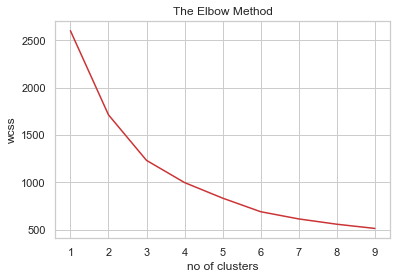

In [848]:
wcss=[]

for i in range(1,10):
    kmeans = KMeans(n_clusters= i, random_state=0)
    kmeans.fit(X_principal)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

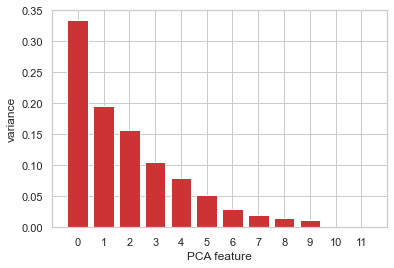

In [849]:
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(log_e)  ##

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

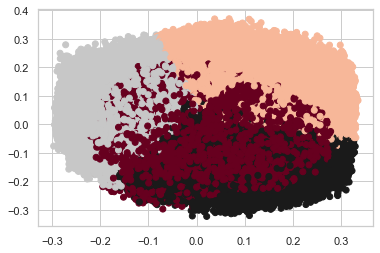

In [850]:
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = KMeans(n_clusters = 4).fit_predict(X_principal), cmap ="RdGy") 
plt.show()

#when we squish the timeframe, clusters become more hard to define. variance btw clusters begins to diminish.

In [851]:
# Create a DataFrame with labels and varieties as columns: df
df_ct = pd.DataFrame({'cluster_labels': labels, 
                      'User_Id': dft_sv_csum0_2019_fc[dft_sv_csum0_2019_fc.Time_Dif<="00:10:00"]["User_Id"]}) ##

# Create crosstab: ct
ct = pd.crosstab(df_ct["cluster_labels"],df_ct["User_Id"])

# Display ct
ct/ct.sum()

User_Id         05056DA7-9D4E-4ED7-8C04-A5B1C6559493  \
cluster_labels                                         
0                                           0.000000   
1                                           0.526316   
2                                           0.092105   
3                                           0.381579   
4                                           0.000000   

User_Id         061817A6-6D99-424D-809E-2C00AF175AB8  \
cluster_labels                                         
0                                             0.0000   
1                                             0.0625   
2                                             0.0000   
3                                             0.9375   
4                                             0.0000   

User_Id         068298EF-1F07-4718-B47B-E495247C6947  \
cluster_labels                                         
0                                           0.303901   
1                                           0.004107   
2                                           0.675565   
3                                           0.000000   
4                                           0.016427   

User_Id         0943084D-CBF5-4E82-B1B4-1D0235D177C4  \
cluster_labels                                         
0                                           0.009009   
1                                           0.396396   
2                                           0.072072   
3                                           0.522523   
4                                           0.000000   

User_Id         0A597706-B8DA-4994-B4F5-C76146454951  \
cluster_labels                                         
0                                           0.000000   
1                                           0.218045   
2                                           0.062030   
3                                           0.719925   
4                                           0.000000   

User_Id         14236CAC-AD34-4EDB-AA93-6AA772301C52  \
cluster_labels                                         
0                                           0.000000   
1                                           0.181818   
2                                           0.030303   
3                                           0.787879   
4                                           0.000000   

User_Id         152A42EF-A534-43AE-B45B-CEFEEF9C9956  \
cluster_labels                                         
0                                              0.000   
1                                              0.375   
2                                              0.000   
3                                              0.625   
4                                              0.000   

User_Id         15597C07-6169-4BBB-BC57-BCE6DD837C1C  \
cluster_labels                                         
0                                           0.000000   
1                                           0.313462   
2                                           0.008974   
3                                           0.677564   
4                                           0.000000   

User_Id         1746596B-884C-4CFD-BBE4-9CA7959567F9  \
cluster_labels                                         
0                                           0.357375   
1                                           0.036387   
2                                           0.292398   
3                                           0.000000   
4                                           0.313840   

User_Id         19A57063-45EC-4EE2-A097-6CEFE624879E  ...  \
cluster_labels                                        ...   
0                                           0.413386  ...   
1                                           0.000000  ...   
2                                           0.586614  ...   
3                                           0.000000  ...   
4                                           0.000000  ...   

User_Id         F59A27A8-3825-4F53-

In [852]:
res_010_t0431=all_tests[["t0431","t0431p"]].sort_values("t0431")
res_010_t0431

t0431    t0431p
User_Id                                              
0A597706-B8DA-4994-B4F5-C76146454951      0  0.483083
8E113ECD-EFA0-448F-A9FB-6634AE9032C5      0  0.382218
6E748509-98D8-4457-B7DA-092612601352      1  0.801925
715C3F69-91F7-4A9D-85E0-F1765AE7574F      1  0.375691
6c564474-bc21-4b15-ad4f-5cb5c16e1c33      1  0.741644
6FFA7DFE-47B3-42FC-905B-44854F037F10      1  0.903984
62c8f9c2-3384-4f5e-8ada-f5bcbbea0665      1  0.460920
9F998895-3467-4021-B34A-4D38F58956F9      1  0.369565
AF110C73-5378-4EC3-AB27-AECC36A74ADA      1  0.859091
CDD35C57-F849-47B3-8B63-E52BCAC406BF      1  0.789056
D476FBE9-8901-4C11-9584-D8829A479ED7      1  0.558140
3C30B069-C240-43A8-A095-7C1E96411CE6      1  0.620690
D806D2DE-3C33-4136-A9A2-763AFA9B4323      1  0.584821
E5708F27-7AA7-43E7-92E4-AC7AD8660616      1  0.784495
2A5E8769-F64D-4EC2-927E-B95E9A0A55A0      1  0.621924
D797847F-B9C6-4723-883F-C34D22F90C6A      1  0.703704
068298EF-1F07-4718-B47B-E495247C6947      1  0.870637
1746596B-884C-4CFD-BBE4-9CA7959567F9      1  0.576348
19A57063-45EC-4EE2-A097-6CEFE624879E      1  0.822835
F2928023-0755-4401-AA18-CEFDD663A784      2  0.564899
70017663-AEB6-45BF-9079-FFCFD89951D4      2  0.438567
FF571F23-A909-40AA-ADD3-704585B150D6      2  0.688103
5EC1864B-1E20-4A11-B927-CA523DB100C9      2  0.587662
4EF9609D-DEBE-45CE-88CE-DA12F14092A2      2  0.737918
CE86C4D5-11F6-4126-8BA2-D12F6A60C5A2      2  0.417370
15597C07-6169-4BBB-BC57-BCE6DD837C1C      2  0.498718
712044DF-CC59-4BBB-9D9B-7C889582EF58      2  0.443073
21B66374-DCE1-47F0-B37A-4C718D42AA37      2  0.435808
FF05F037-15DC-4D31-92C4-06FB01DAF5FC      2  0.455446
7157EA9B-3F89-4612-AABE-03616D6A6914      2  0.479730
3D25B51C-DB5E-40F1-99CD-D7899B85FA75      2  0.566542
209B2018-577C-454A-B904-0B104CBCB1AC      2  0.527103
A1F2984A-1E6C-4F3E-9D6B-4405C4DB9700      3  0.556962
de668efc-f18a-4f1b-ae4b-ddbebf58006e      3  0.709677
76c344f9-239f-45dd-b698-736ddd293cac      3  0.663158
F837CC34-2629-488C-86A7-8E28EC5AB080      3  0.891892
7BAB33E6-C765-4AF7-A068-6C54FE272498      3  0.909091
d0dc14f3-181c-4a06-8125-ac30a93fa495      3  0.702703
82905E4B-F017-49BD-AE6B-ADC75CCD3797      3  1.000000
83197018-C350-440B-9F07-EAEE57B45842      3  0.362720
C2155859-DE21-4901-AEEE-EEDE6EC3E40A      3  0.463768
E01A870B-AB18-43C9-B8D2-CDD63DD16AA1      3  0.462334
8E967BB3-13A9-4E39-96A8-C8DFCDD37FC3      3  0.937500
FE928369-8C1C-4D31-85C6-E132A134C0C6      3  0.757576
9E52DA09-CF46-4888-A348-C9A9C3487B5C      3  0.378151
F59A27A8-3825-4F53-BE25-E587C848776C      3  0.866667
841B13B7-7F61-40ED-81BB-70E719D18D22      3  0.344498
a79aa86e-bebe-4038-bc19-1aa06e5b8f1f      3  0.942308
05056DA7-9D4E-4ED7-8C04-A5B1C6559493      3  0.513158
7035BB5A-3B80-41E7-9DC1-4FD7AE8883E5      3  0.900000
061817A6-6D99-424D-809E-2C00AF175AB8      3  0.937500
0943084D-CBF5-4E82-B1B4-1D0235D177C4      3  0.639640
14236CAC-AD34-4EDB-AA93-6AA772301C52      3  0.848485
152A42EF-A534-43AE-B45B-CEFEEF9C9956      3  0.875000
1CDBFA8B-059A-4A53-BF8F-72F0D97A4FF3      3  0.681223
213d6c4c-0f4f-467c-86dd-eaea0cb851e5      3  0.913043
26C11AB0-1D82-4FB6-B65E-8D5431BE0456      3  0.538732
2838cf7f-a532-4875-a461-c947fbf33696      3  0.710843
2A1A028F-ACA1-403E-A6B9-F17C9EA01721      3  0.469287
362C7373-DC3D-40D1-9DDC-1554D11F16DB      3  0.693966
391823DB-EF2F-4FF5-A947-381C5C630453      3  0.591743
3C2CC3D4-36AD-493C-AEC2-1034CED6517C      3  0.720930
3DD8E606-1312-4960-94CE-A2A18B1A13CE      3  0.736842
3F131DD5-6EE9-4C87-B252-C945B008CDE3      3  0.888889
3e73d6d9-8cfd-4c23-89f8-8058eea97f52      3  0.693548
47B1C4A3-173C-42F7-B8CB-4E05F18E739A      3  1.000000
4F04117B-11D9-4E17-983F-22166E1EFA5B      3  0.540000
5235F400-C91A-4CED-9D8F-41BE1D2F5B43      3  1.000000
53D66313-30D0-4953-A67F-86233E4B40C1      3  1.000000
56EC977C-786D-42CB-A371-41F2841FEE13      3  0.595186
5784D6B8-7DE8-4BCD-B24E-791A873364DD      3  0.800000
5d9099a5-a3fc-4f52-b2ae-24d9cce0513c      3  0.818182
615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF      

### Plots And Results

- We check our data for year=2019 and 60,30,15,10min timeframes. We check 24 different models and we try to split our data as much possible so we choose highest cluster_label_sum and highest weighted cluster_label_sum. ***Almost always, if model has highest cluster_label_sum, it has also have highest weighted cluster_label_sum.***


- ***I tried to distinguish similarities btw individuals based on their break time.*** If their break time has related descriptive statistics then they might be going out together. Clustering problems have few ways to tell data scientist that their model is good, i dont have semi-labelled data to test my findings either, so this model is just a try


- Other than last model, our dset is always dft_sv_csum0_2019_fc_num. ***Now i add couple of bar plots to visualize clusters and add a hiearchical clustering if my pc could handle***


- ***I could choose one of these 4 barplots if i know who has which user_id, however it could be good idea to leave all 4 here. Different timeframes could be interpreted as different scenarios. 10-15 mins could be smoke break, 30-60 hour could be lunch break***

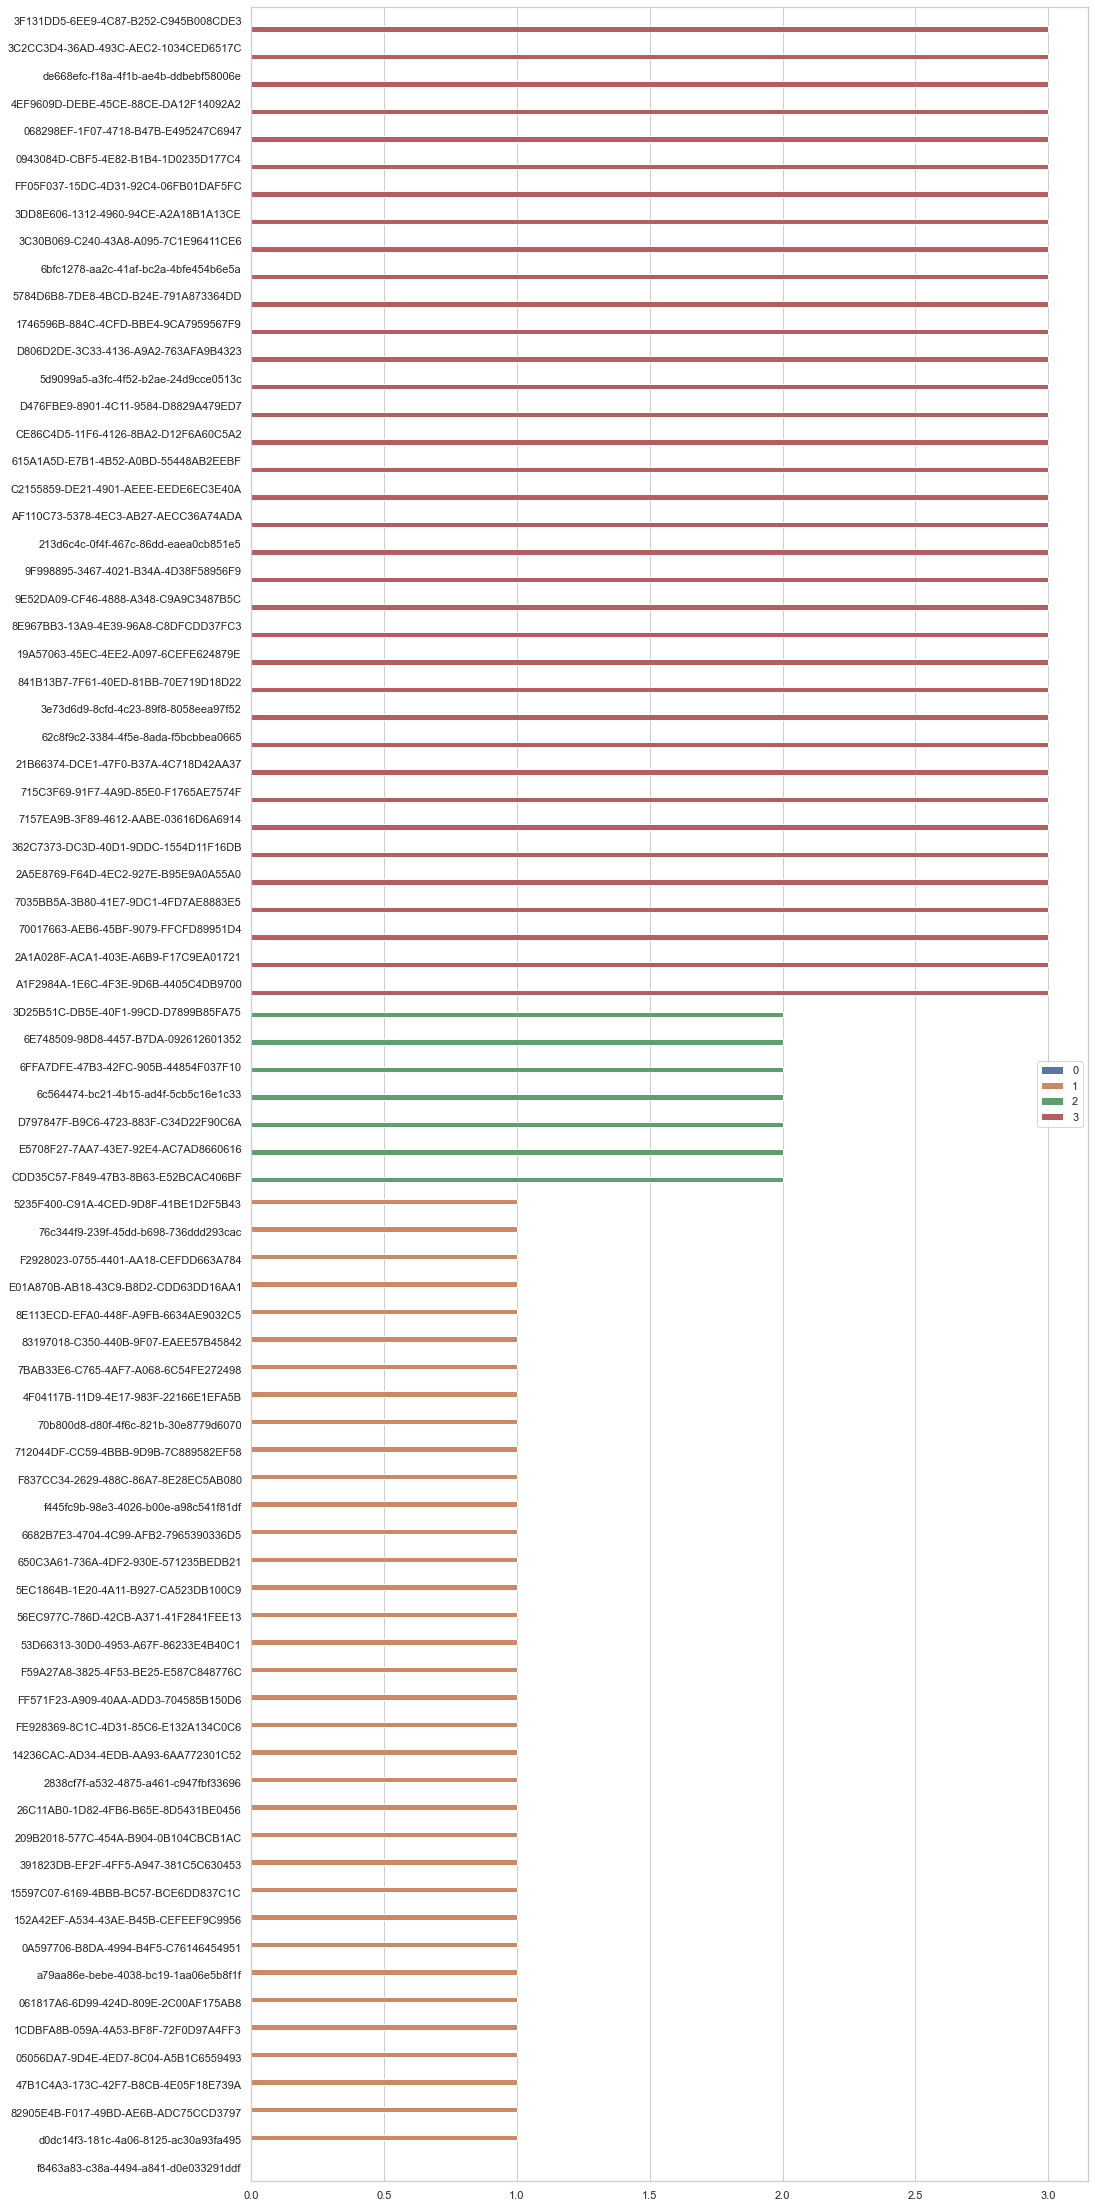

In [853]:
plt.figure(figsize=(15,40))
sns.barplot(y=res_060_t1441.sort_values("t1441",ascending=False).reset_index()["User_Id"].values
            ,x=res_060_t1441.sort_values("t1441",ascending=False).reset_index()["t1441"].values,
            hue=res_060_t1441.sort_values("t1441",ascending=False).reset_index()["t1441"].values,
            palette=sns.color_palette("deep", 25))

#2-60 min with model t1441 (log_e, n_clusters =4, pca n_components=3 and l1 regularization(lasso)

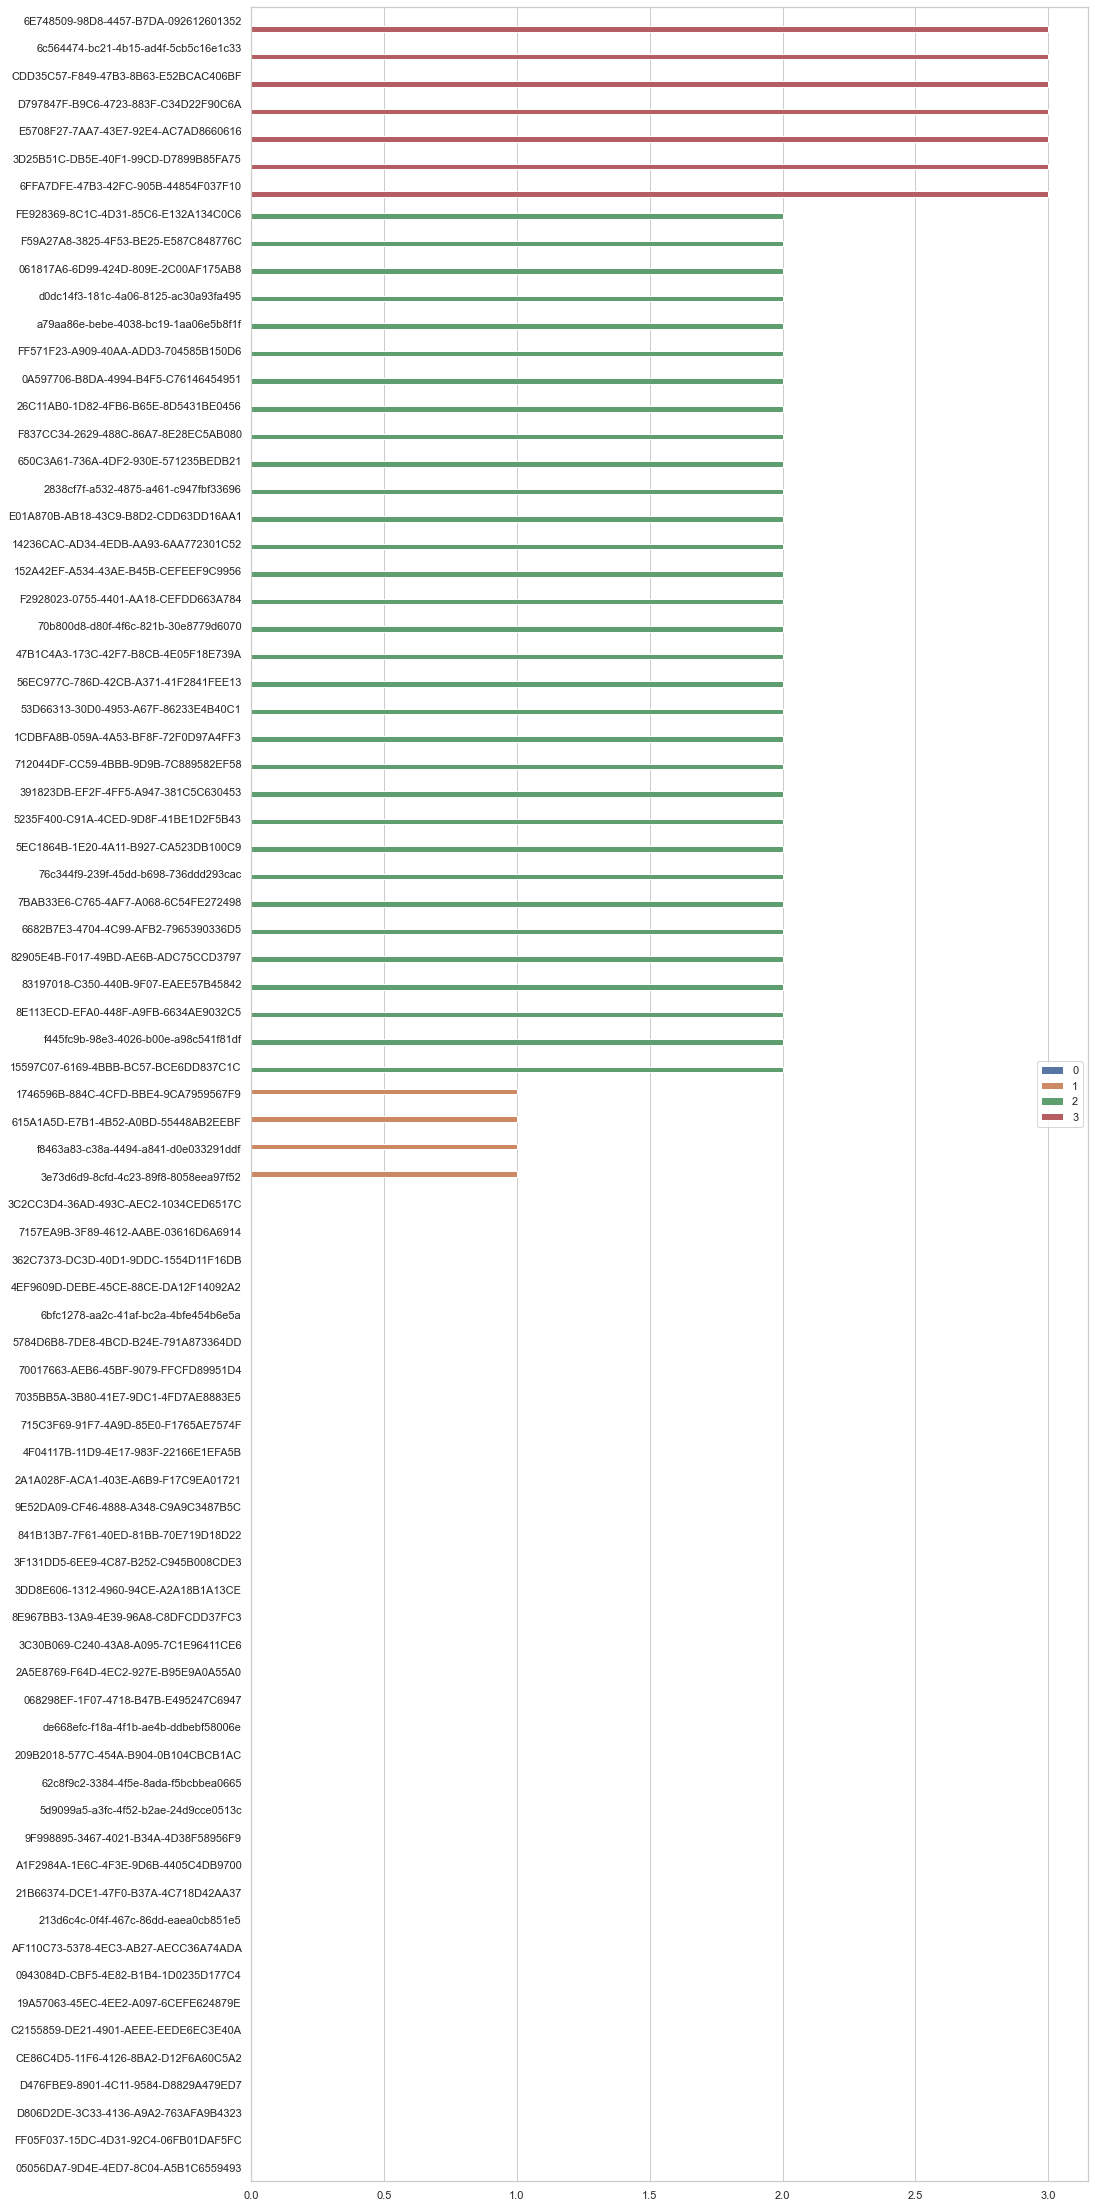

In [856]:
plt.figure(figsize=(15,40))
sns.barplot(y=res_030_t1441.sort_values("t1441",ascending=False).reset_index()["User_Id"].values
            ,x=res_030_t1441.sort_values("t1441",ascending=False).reset_index()["t1441"].values,
            hue=res_030_t1441.sort_values("t1441",ascending=False).reset_index()["t1441"].values,
            palette=sns.color_palette("deep", 25))

#2-30 min with model t1441 (log_e, n_clusters =4, pca n_components=3 and l1 regularization(lasso)

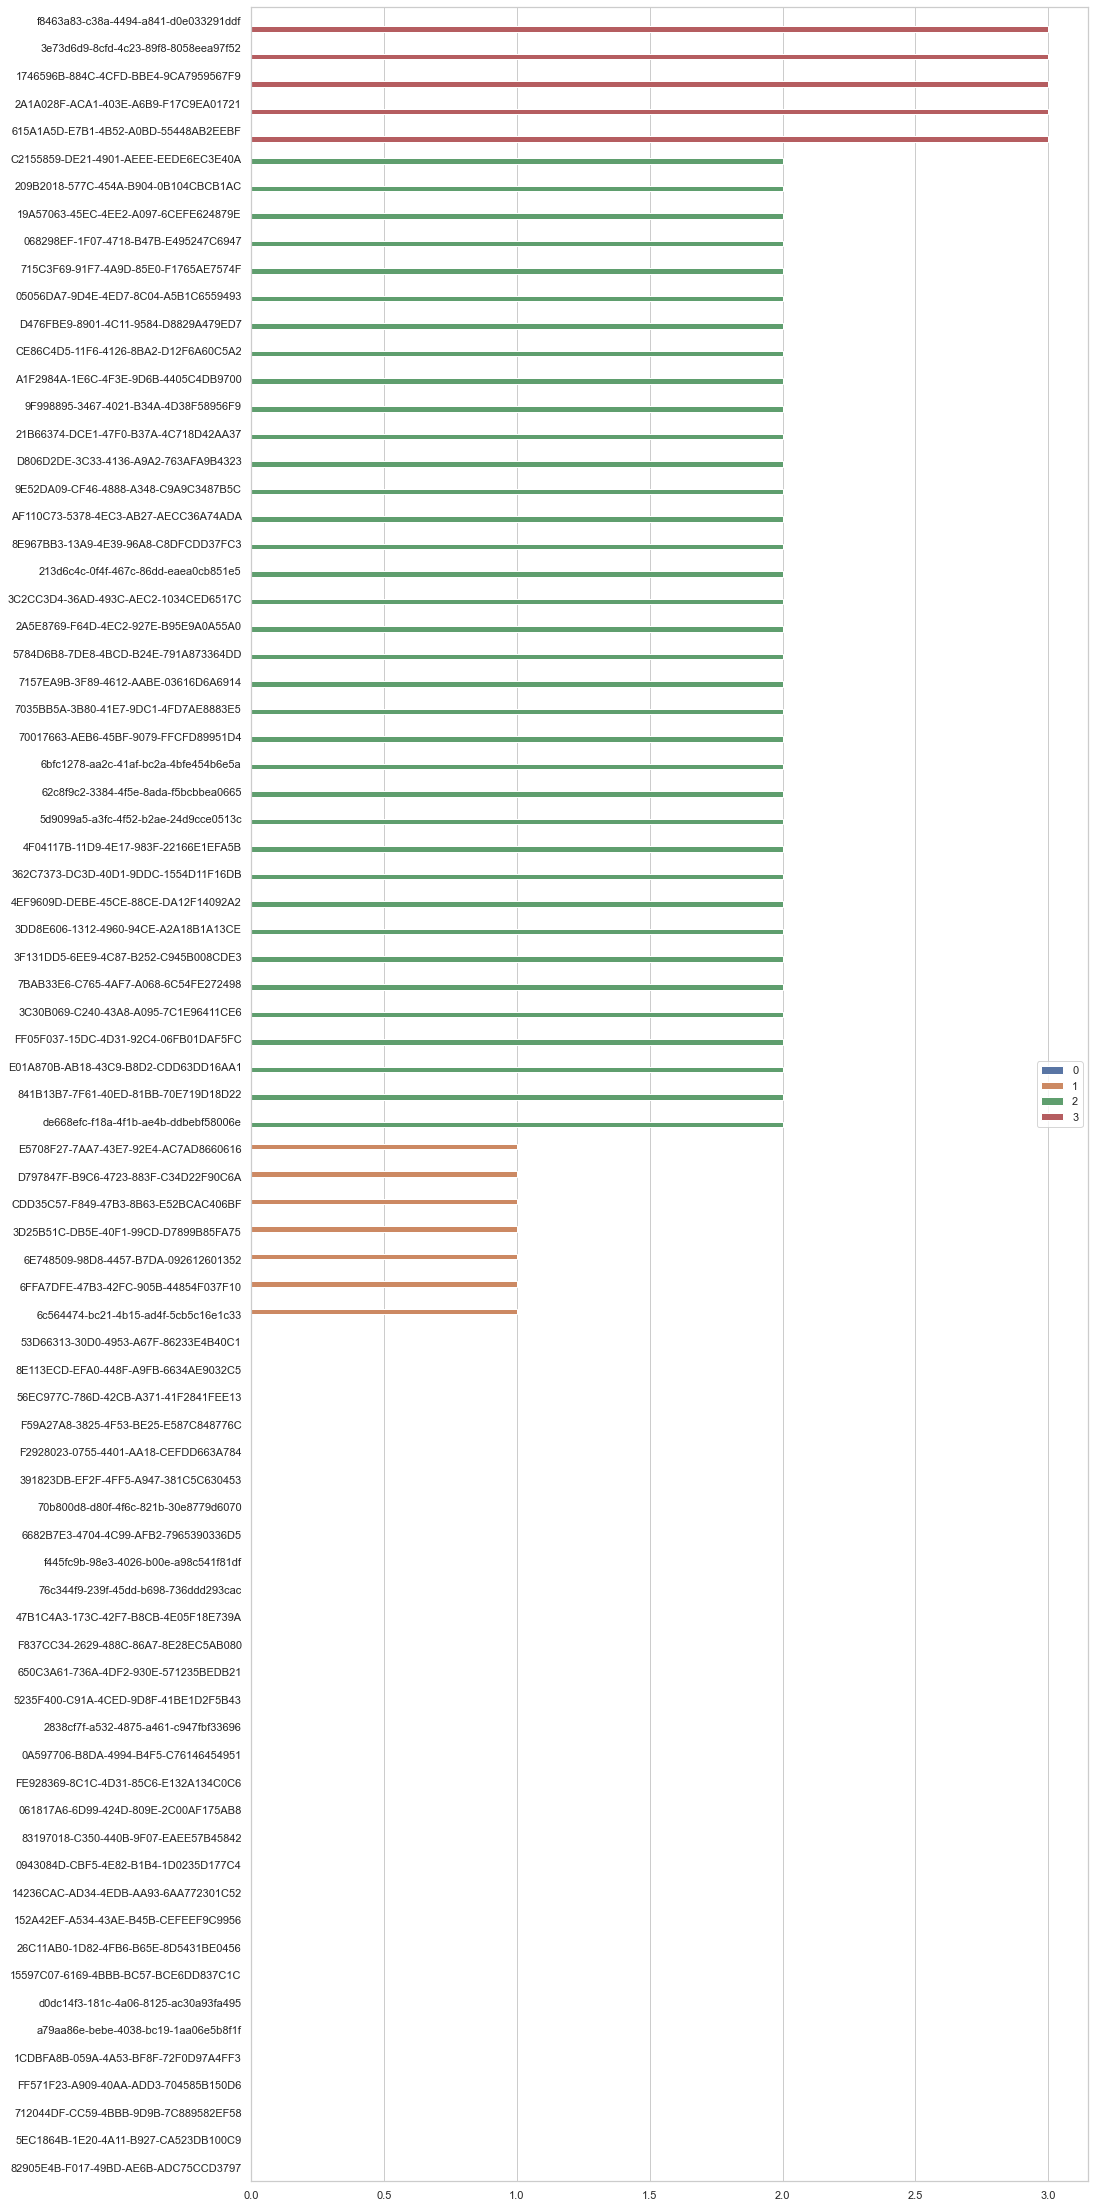

In [857]:
plt.figure(figsize=(15,40))
sns.barplot(y=res_015_t1441.sort_values("t1441",ascending=False).reset_index()["User_Id"].values
            ,x=res_015_t1441.sort_values("t1441",ascending=False).reset_index()["t1441"].values,
            hue=res_015_t1441.sort_values("t1441",ascending=False).reset_index()["t1441"].values,
            palette=sns.color_palette("deep", 25))

#2-15 min with model t1441 (log_e, n_clusters =4, pca n_components=3 and l1 regularization(lasso)

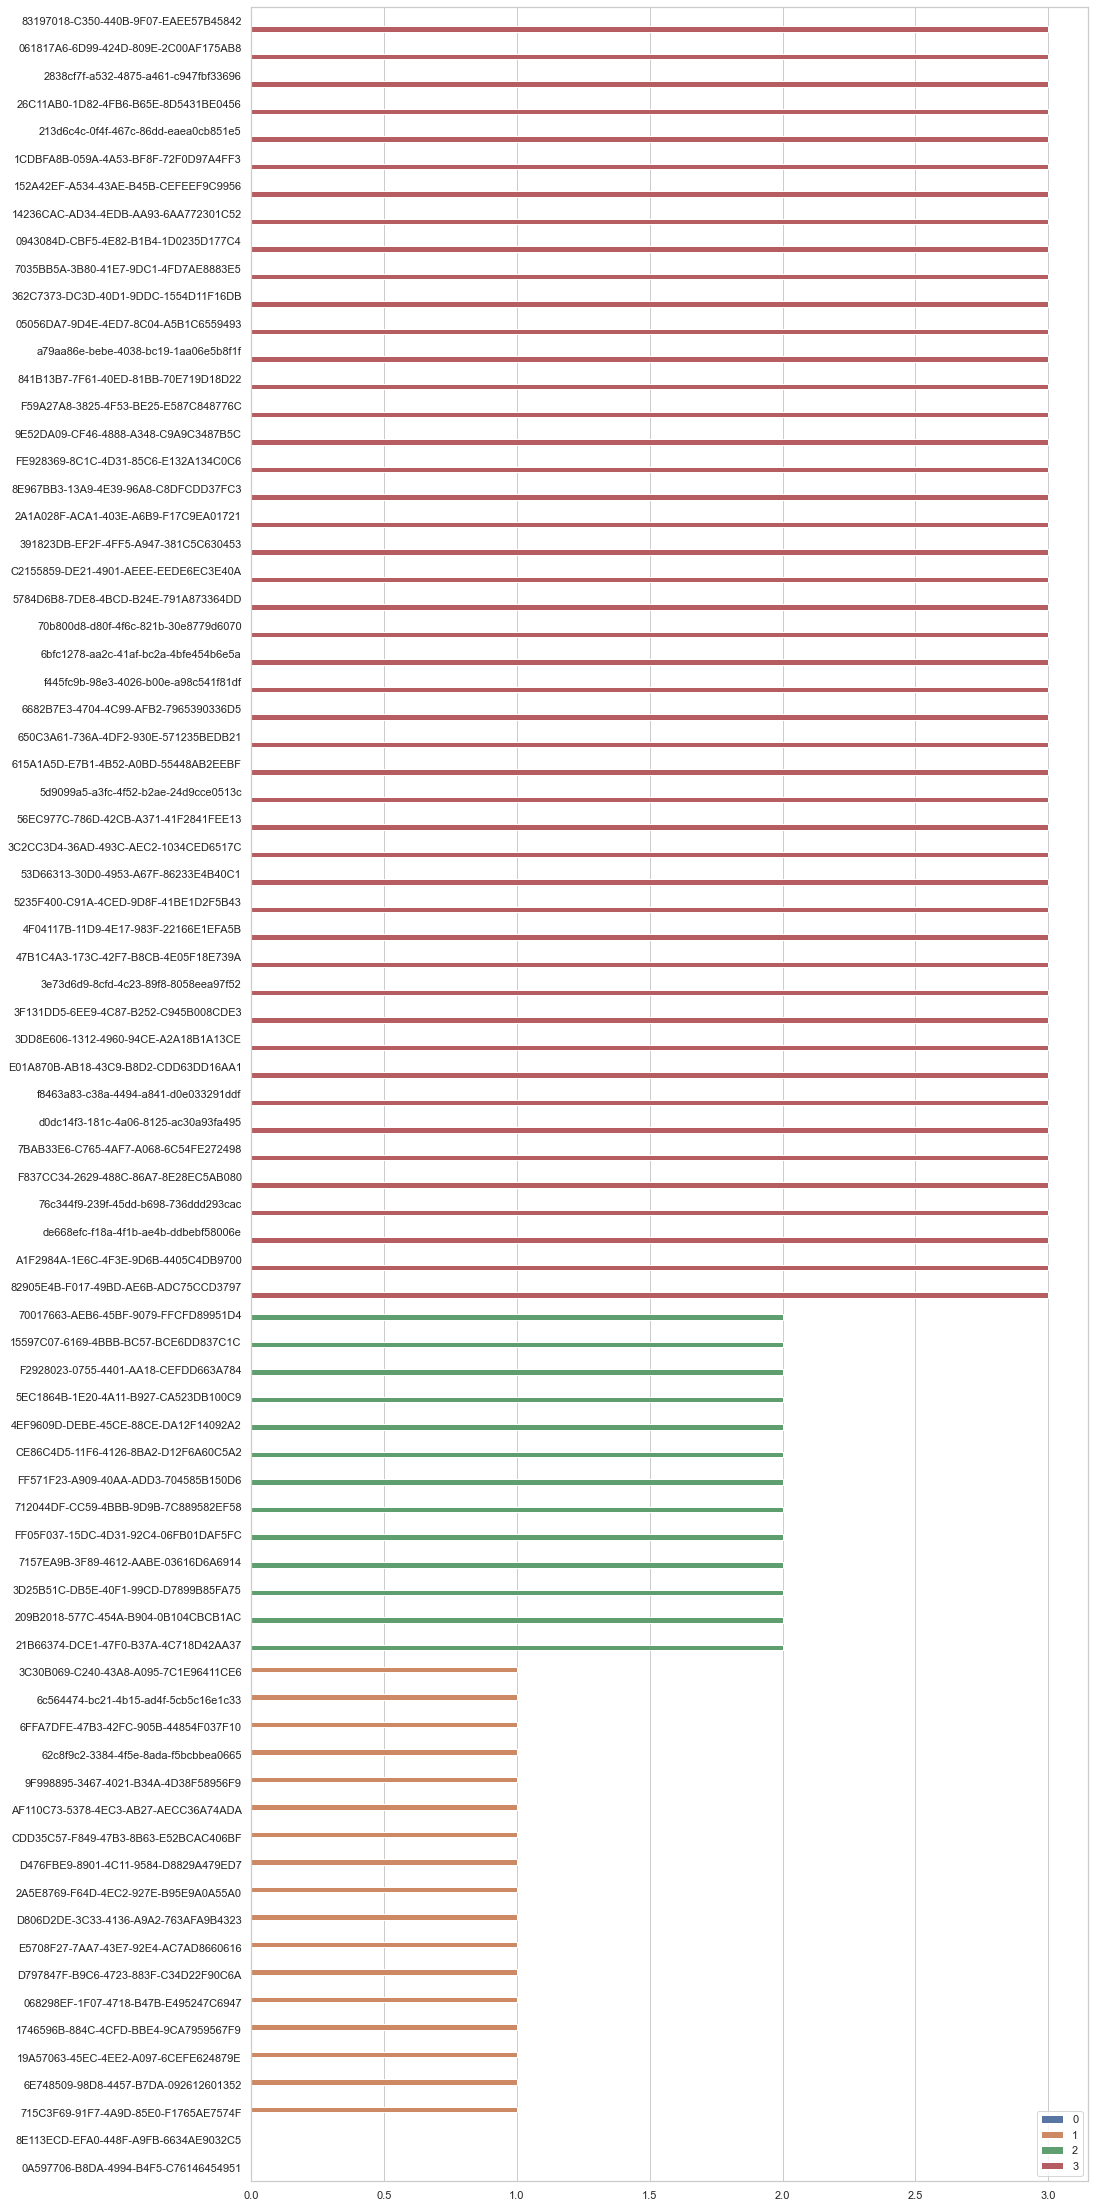

In [858]:
plt.figure(figsize=(15,40))
sns.barplot(y=res_010_t0431.sort_values("t0431",ascending=False).reset_index()["User_Id"].values
            ,x=res_010_t0431.sort_values("t0431",ascending=False).reset_index()["t0431"].values,
            hue=res_010_t0431.sort_values("t0431",ascending=False).reset_index()["t0431"].values,
            palette=sns.color_palette("deep", 25))

#2-10 min with model t0431 (log_e, n_clusters =4, pca n_components=3 and l1 regularization(lasso)

In [933]:
vis_test=dft_sv_csum0_2019_fc.sort_values("ReadedAt").copy()
vis_test

ReadedAt                               User_Id Time_Dif  \
3486  2019-01-02 07:41:57  15597C07-6169-4BBB-BC57-BCE6DD837C1C 00:36:12   
6054  2019-01-02 07:42:36  1746596B-884C-4CFD-BBE4-9CA7959567F9 00:08:58   
19728 2019-01-02 07:47:52  3D25B51C-DB5E-40F1-99CD-D7899B85FA75 00:03:09   
3487  2019-01-02 07:48:07  15597C07-6169-4BBB-BC57-BCE6DD837C1C 00:06:09   
6055  2019-01-02 07:48:51  1746596B-884C-4CFD-BBE4-9CA7959567F9 00:06:15   
...                   ...                                   ...      ...   
14341 2019-12-31 19:17:47  21B66374-DCE1-47F0-B37A-4C718D42AA37 00:11:21   
3410  2019-12-31 19:25:50  0A597706-B8DA-4994-B4F5-C76146454951 00:08:06   
71879 2019-12-31 19:25:59  f8463a83-c38a-4494-a841-d0e033291ddf 00:58:40   
28094 2019-12-31 19:36:32  615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF 00:35:43   
28095 2019-12-31 19:41:53  615A1A5D-E7B1-4B52-A0BD-55448AB2EEBF 00:05:21   

      Time_Dif_Hr  Time_Dif_Float  Year      Time        Date  Month  Day  \
3486           00       36.200000  2019  07:41:57  2019-01-02      1    2   
6054           00        8.966667  2019  07:42:36  2019-01-02      1    2   
19728          00        3.150000  2019  07:47:52  2019-01-02      1    2   
3487           00        6.150000  2019  07:48:07  2019-01-02      1    2   
6055           00        6.250000  2019  07:48:51  2019-01-02      1    2   
...           ...             ...   ...       ...         ...    ...  ...   
14341          00       11.350000  2019  19:17:47  2019-12-31     12   31   
3410           00        8.100000  2019  19:25:50  2019-12-31     12   31   
71879          00       58.666667  2019  19:25:59  2019-12-31     12   31   
28094          00       35.716667  2019  19:36:32  2019-12-31     12   31   
28095          00        5.350000  2019  19:41:53  2019-12-31     12   31   

       ...  Time_Dif_Std  Time_Dif_Median  Time_Dif_Min  Time_Dif_Max  \
3486   ...      0.000000        36.200000     36.200000     36.200000   
6054   ...      0.000000         8.966667      8.966667      8.966667   
19728  ...      0.000000         3.150000      3.150000      3.150000   
3487   ...     21.248559        21.175000      6.150000     36.200000   
6055   ...      1.920973         7.608333      6.250000      8.966667   
...    ...           ...              ...           ...           ...   
14341  ...     23.413606        11.350000      4.966667     48.333333   
3410   ...     19.477554         8.600000      8.100000     42.083333   
71879  ...     31.350403         4.500000      4.233333     58.666667   
28094  ...     16.633486        17.083333      2.533333     35.716667   
28095  ...     18.399283         5.350000      2.533333     35.716667   

       Time_Dif_CSum  Time_Dif_Q5  Time_Dif_Q20  Time_Dif_Q80  Time_Dif_Q95  \
3486       36.200000     2.255833      2.800000     29.566667     51.477500   
6054        8.966667     3.099167      4.966667     40.986667     55.683333   
19728       3.150000     2.833333      3.950000     40.033333     54.133333   
3487       42.350000     2.255833      2.800000     29.566667     51.477500   
6055       15.216667     3.099167      4.966667     40.986667     55.683333   
...              ...          ...           ...           ...           ...   
14341   53357.800000     2.783333      4.050000     35.766667     54.283333   
3410    24592.966667     3.066667      4.566667     26.926667     51.806667   
71879    4053.483333     2.632500      5.100000     35.943333     55.839167   
28094    4373.233333     2.395833      3.806667     46.830000     55.385000   
28095    4378.583333     2.395833      3.806667     46.830000     55.385000   

       Uid_Count  
3486        2568  
6054        2960  
19728       4086  
3487        2568  
6055        2960  
...          ...  
14341       2863  
3410        1653  
71879        220  
28094        188  
28095        188  

[71880 rows x 22 columns]

In [934]:
vis_test['unix_timestamp_from_2019']=(vis_test.ReadedAt.values.flatten().astype(float)/1000000000)-1546300800

#Change readedAt col to unix-timestamp format then substract unix timestamp for 2019-1-1 00:00:00. Now we have
#unix timestamp in seconds for all 2019. I just plot the data for 2019 only, for 0 to 1 hour break time with 79 clusters,
#just to show how dense the dataset is. and creating 40 clusters or 26-27 clusters will be same. So its not very
#meaningful to split the data in 26/40 clusters because each cluster_label_density will be %5 at most.

In [935]:
le=LabelEncoder()
vis_test["uid_cat"]=le.fit_transform(vis_test["User_Id"])

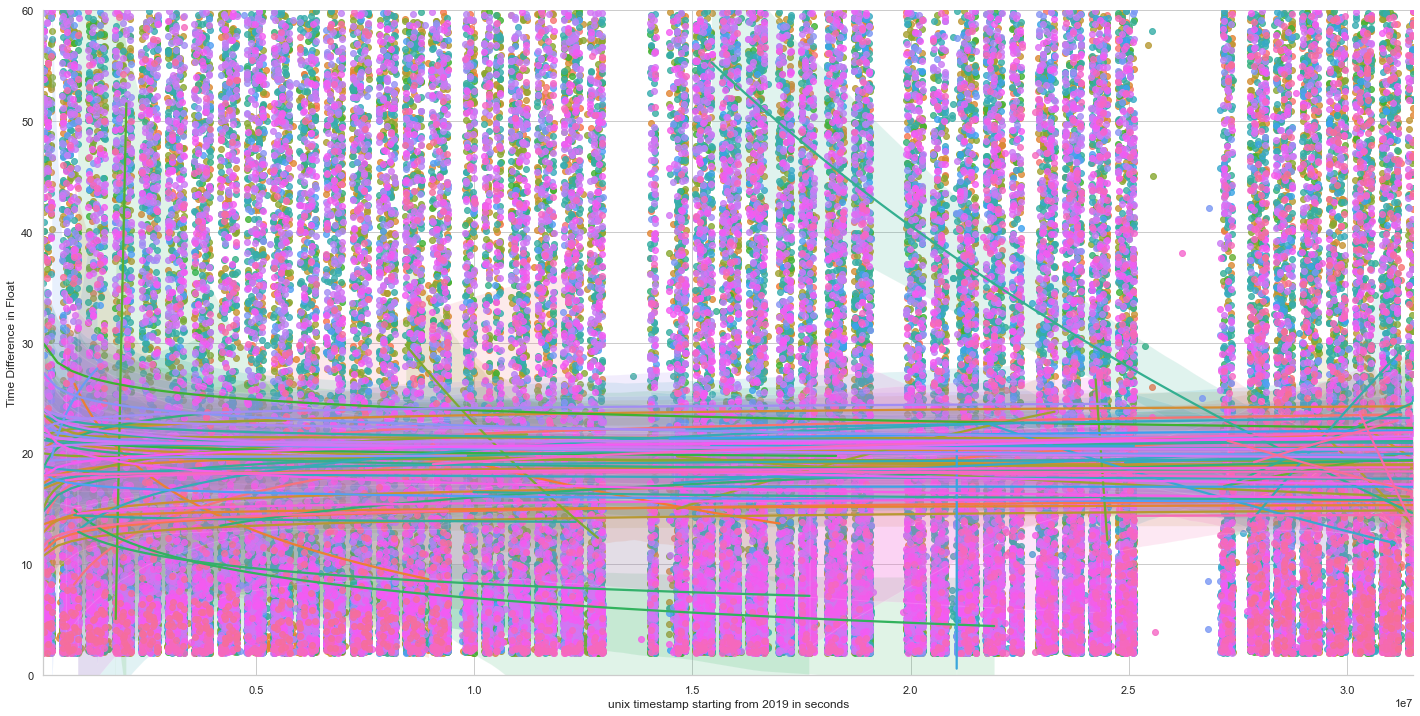

In [936]:
#plt.figure(figsize=(40,20))
sns.lmplot(data=vis_test,x="unix_timestamp_from_2019",y="Time_Dif_Float",hue="uid_cat",logx=True,legend=False,
          height=10,aspect=2)
plt.ylim(0,60)
plt.xlabel("unix timestamp starting from 2019 in seconds")
plt.ylabel("Time Difference in Float")
plt.show()

#this is for "every user have its own cluster scenario", however if you turn it into 2-3 users have a cluster type of
#scenario, thats not very meaningful either. thats why i create +10 features and pca to split the clusters however even that
#model cant have more than 5 clusters. We need more starting features for 26/40 cluster scenario

####  Some Extra Steps We can Done:

    1. Automatic feature engineering. Rather than manual feature engineering like we did, we could give our 12 features and algorithm could find features via combination of other features etc.
    
    2. We could use alternative clustering models such as HDBScan (if your dset doesnt have uniform round clusters, density based clusters like HDBScan could be better)
    
    3. We could use alternative dimensionality reduction models such as Kernel PCA (if data cant be linearly separated)
    
    4. We could use alternative transformers for our features, like power transformation (boxcox)
    
    5. Using H2o.automl and check feature engineering steps they did. we could use truncatedsvm to cluster & use cluster
    aggregation techniques for creating extra columns using user_id col.
    
    6.Bcs this is a unsupervised example, its hard to create extra features, or apply feature_importance, and target encoding steps. In later, forecasting example, it could be simpler to find more sound answers
    
***These are just assumptions, we cant be sure if these steps will work without proper testing***